Прочитаем файл .mat

In [5]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
data = scipy.io.loadmat("../sources/Buckley_Swc_0_Sor_0_M_2.mat")

массивы времени, координат и значений водонасыщенности

In [7]:
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
value = np.real(data['usol']).T

Построим графики распределения водонасыщенности на координатном промежутке в каждый момент времени

In [65]:
def simple_plot_x_slices(x, t, value):
    
    for i in range(len(t)):

        time_value = round(float(t[i]),2)

        plt.figure(figsize=(12, 8))
        plt.plot(x, value[i, :], alpha=0.7, linewidth=1.0)
    
        plt.xlabel('x', fontsize=14)
        plt.ylabel(f"u(x,{time_value} с)", fontsize=14)
        plt.title(f"Распределение S_w на координатном промежутке", fontsize=16)
        plt.grid(True, alpha=0.3)

        plt.savefig(f"pictures/time_{time_value}.png")

        plt.show()

        plt.close()

C:\Users\kns_user\AppData\Local\Temp\ipykernel_9000\622365400.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_value = round(float(t[i]),2)


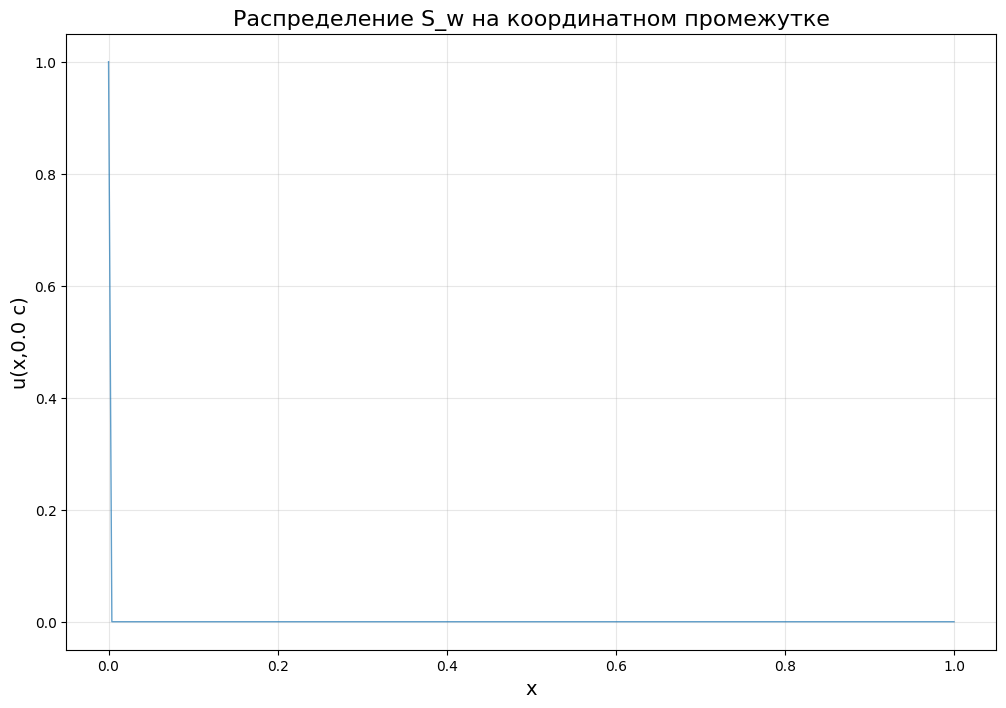

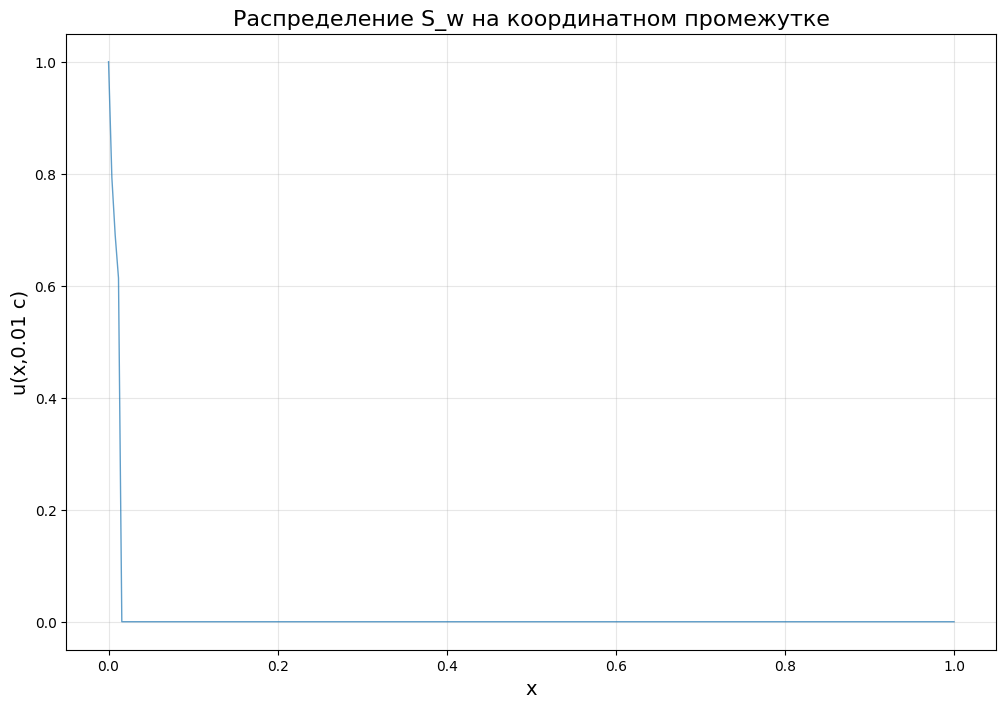

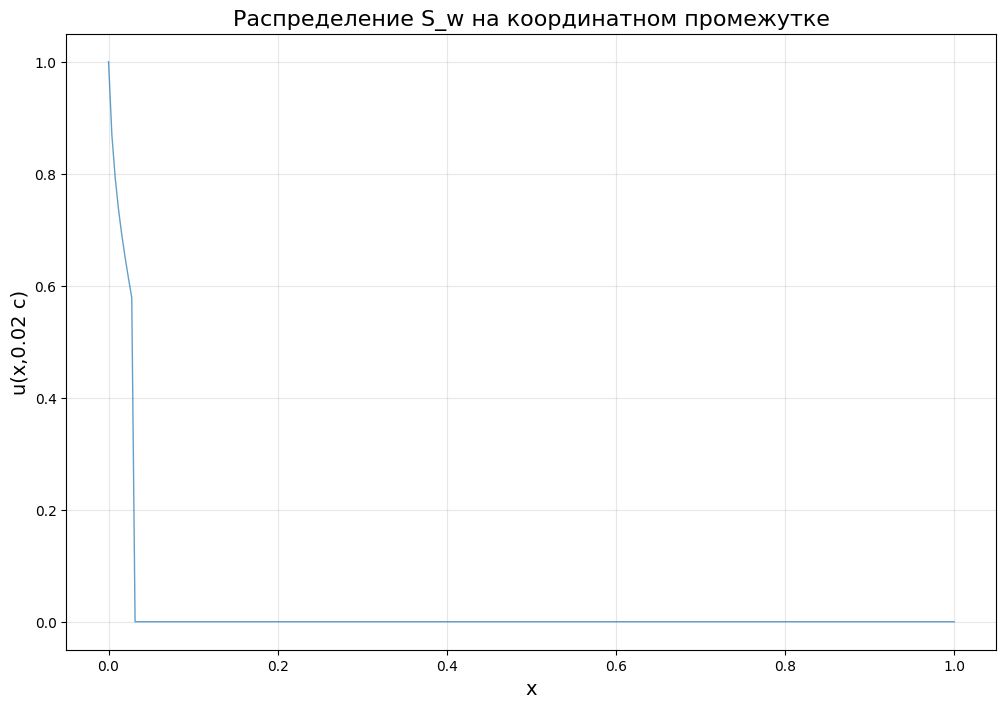

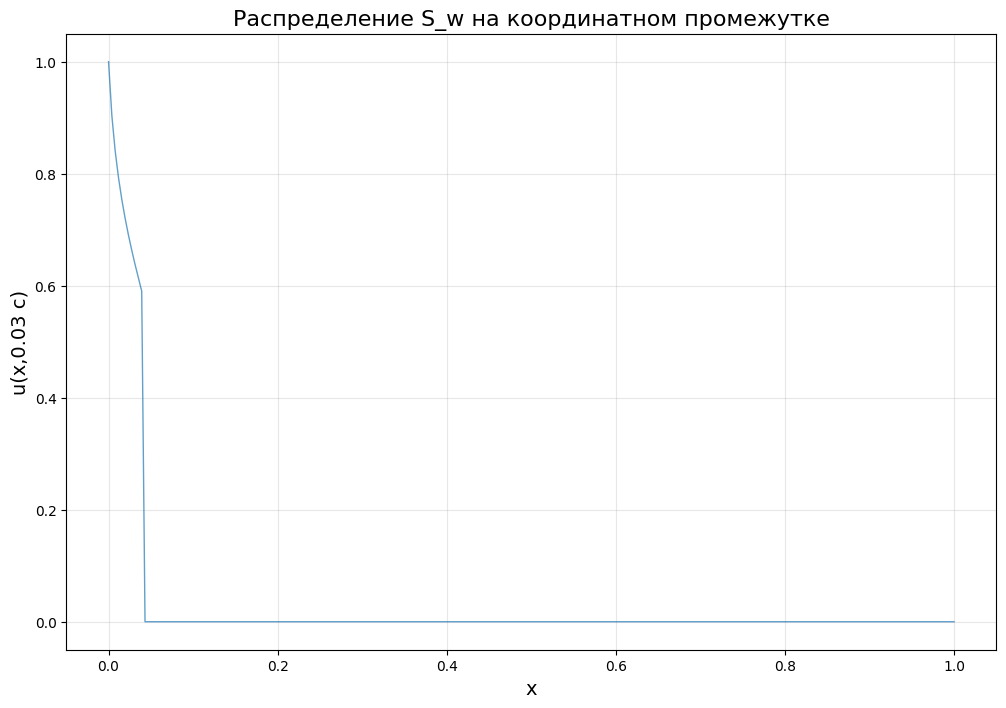

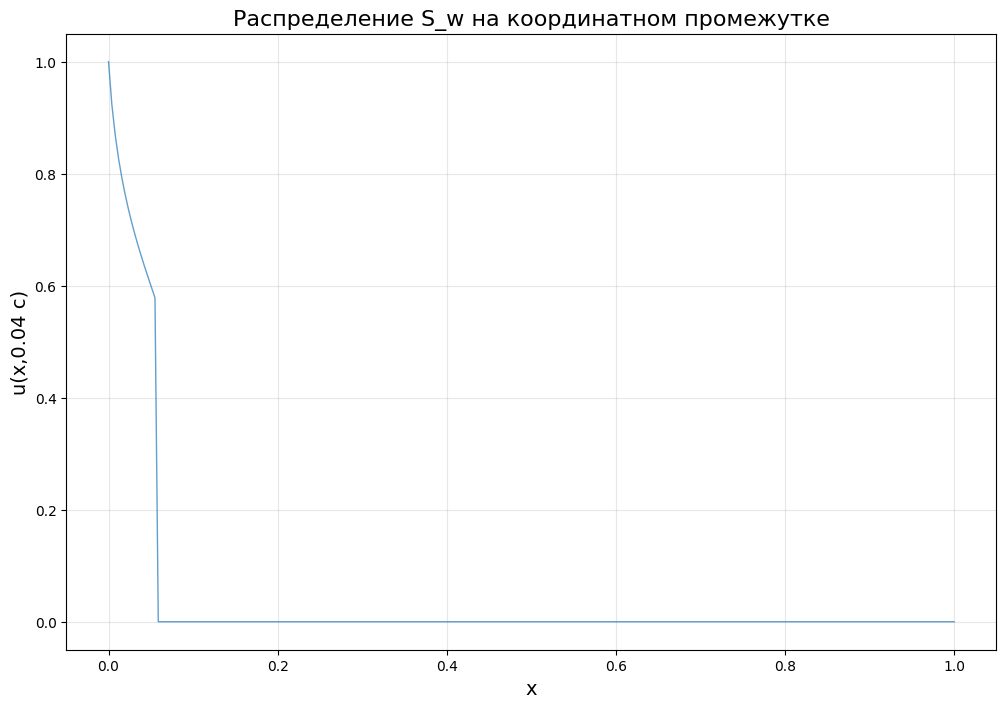

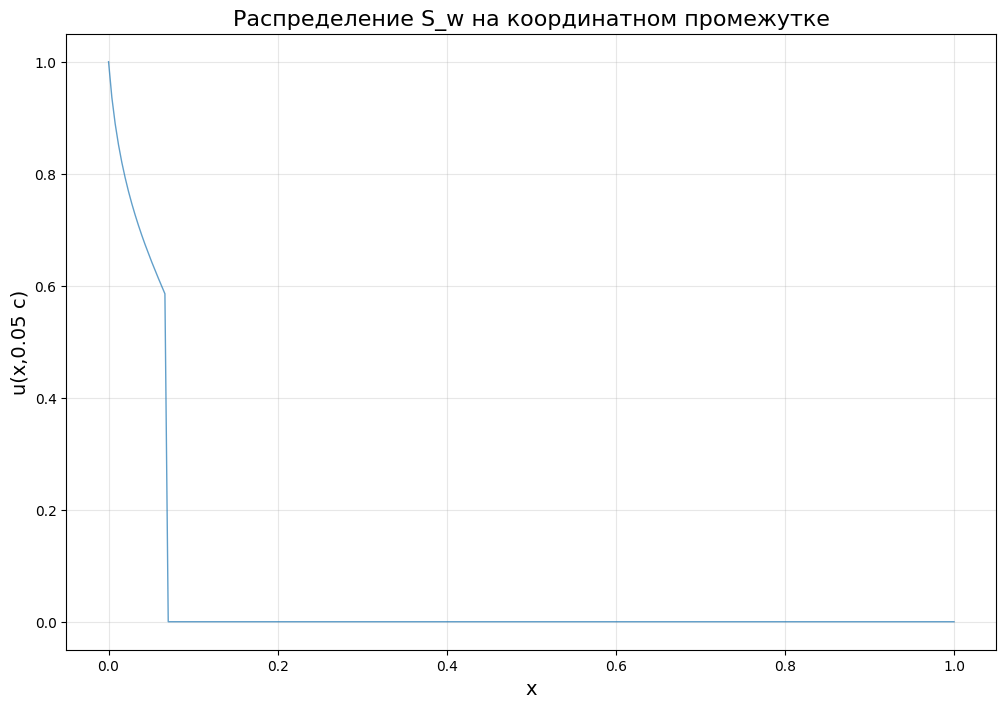

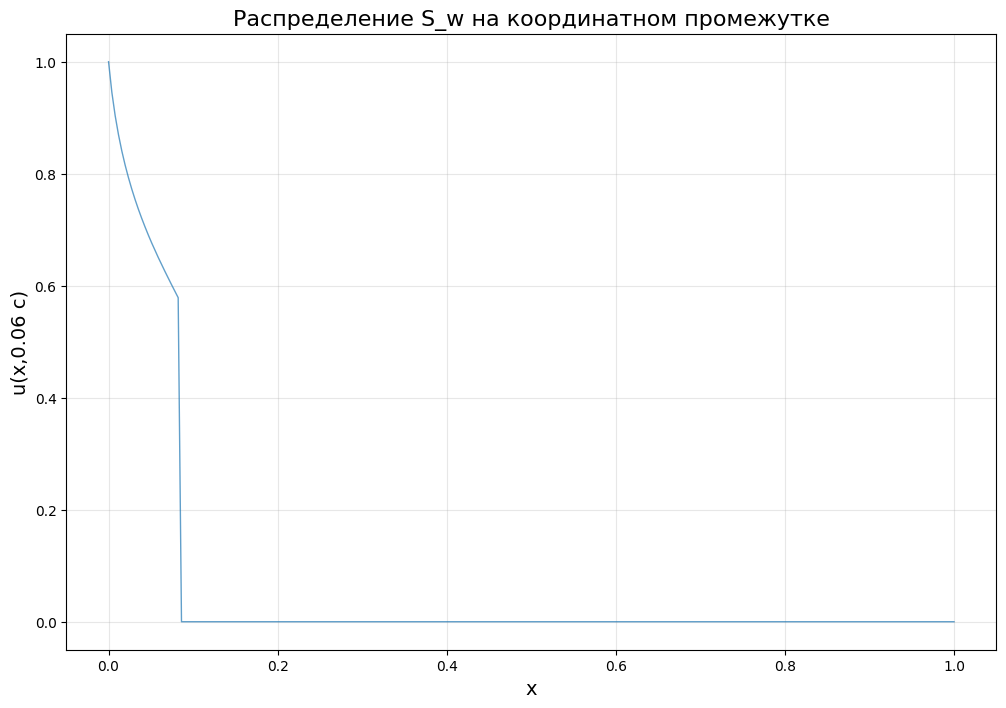

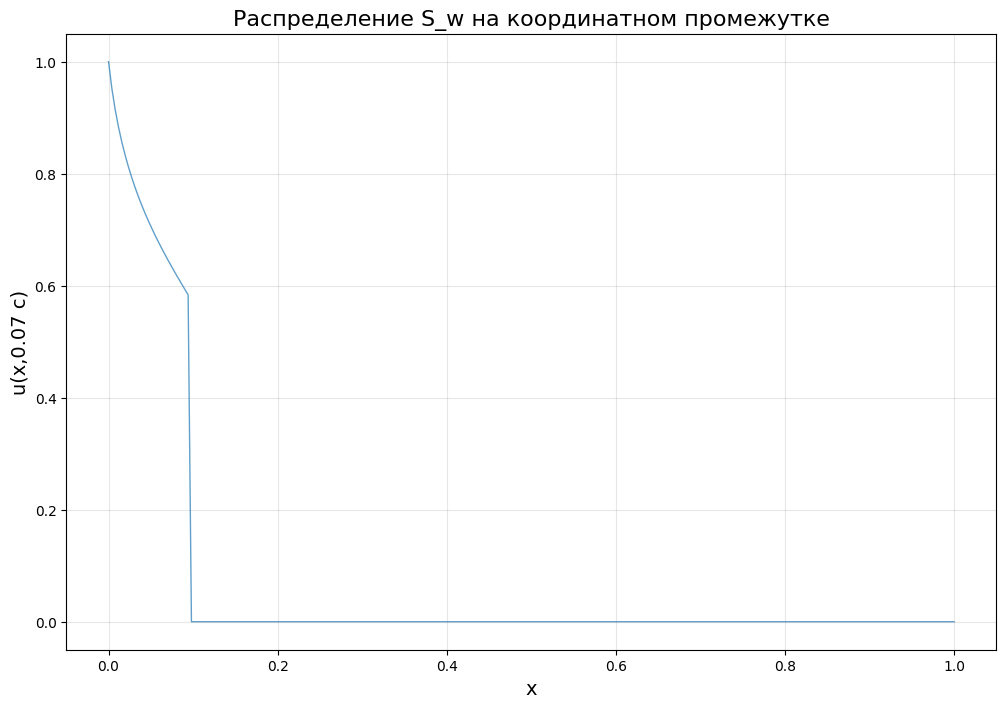

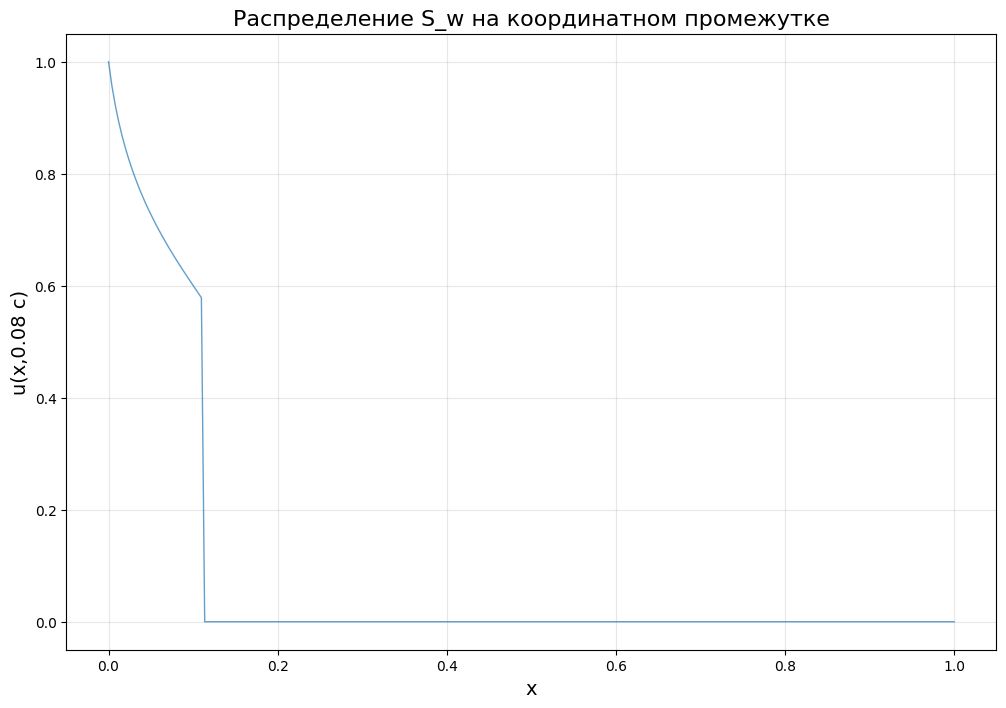

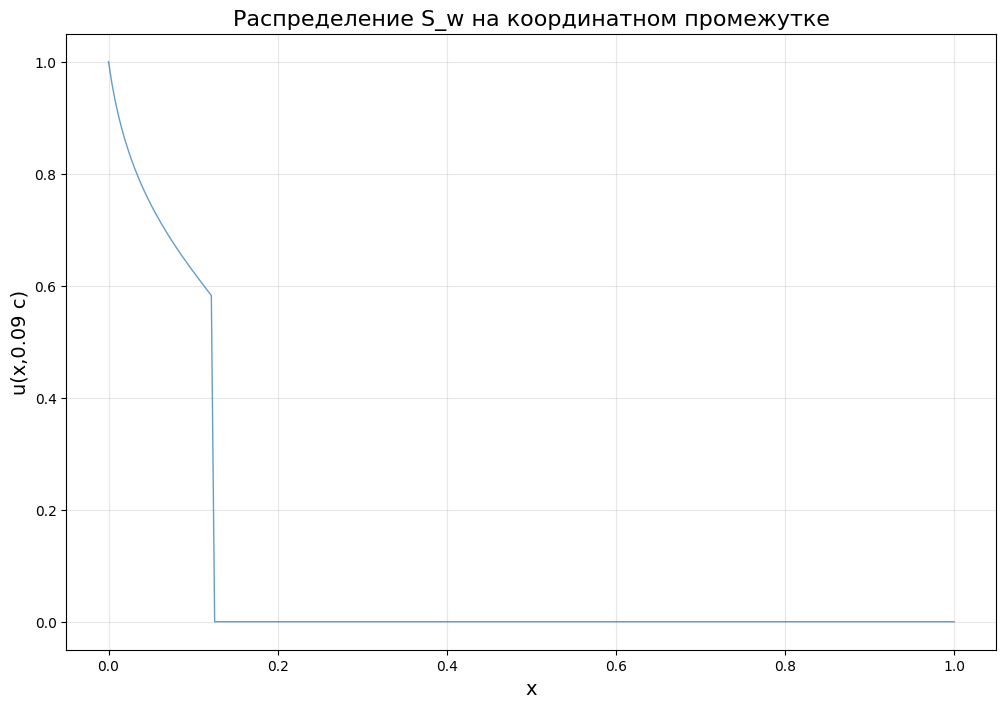

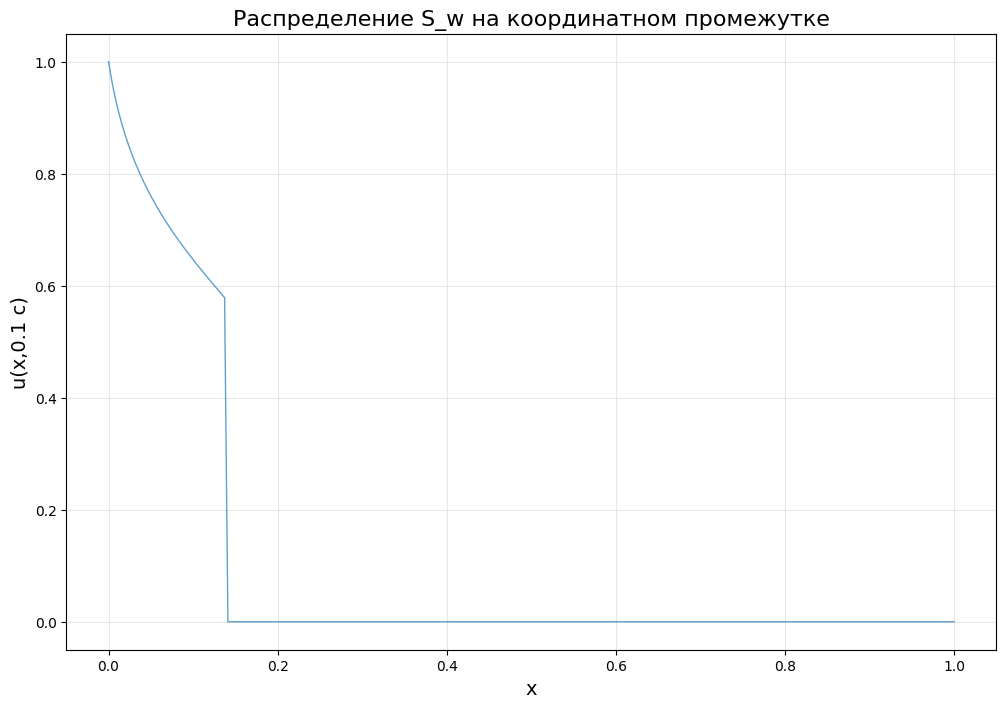

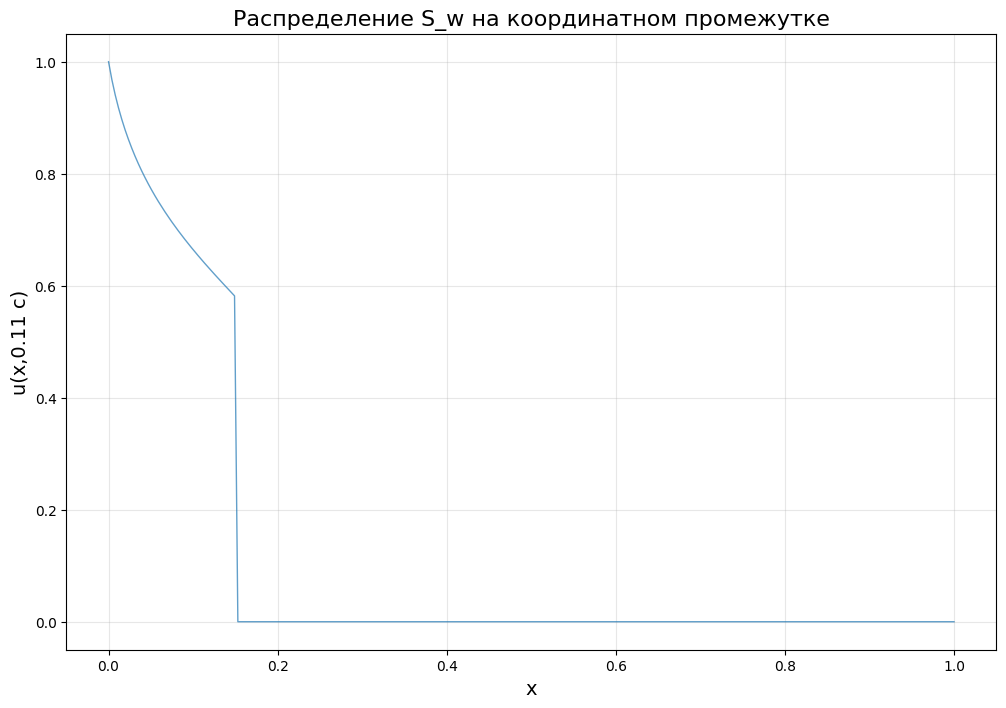

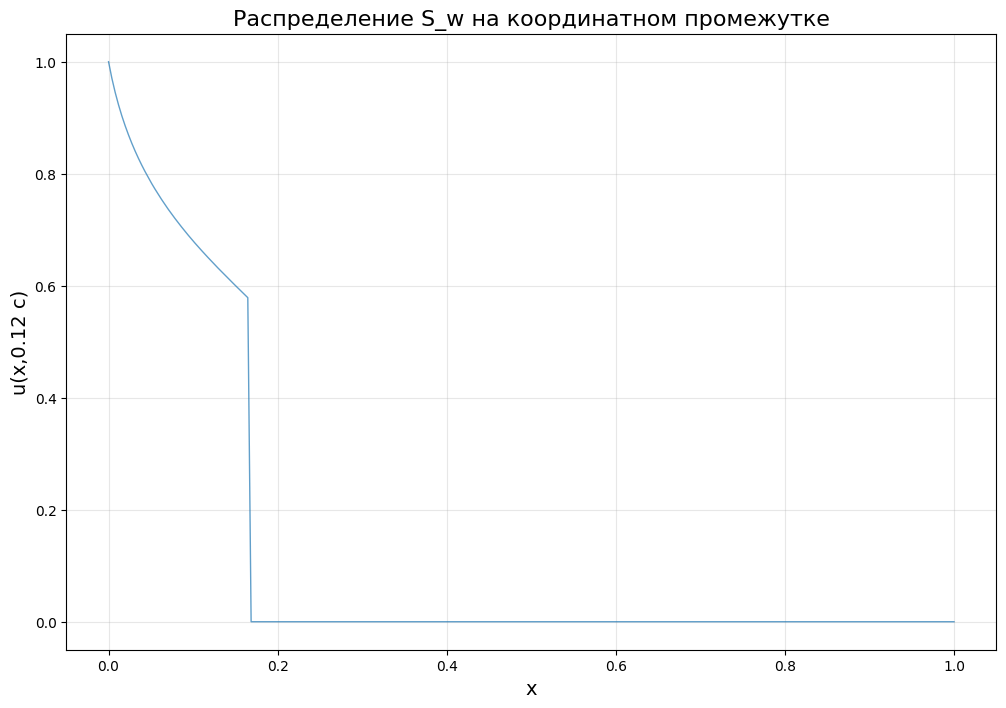

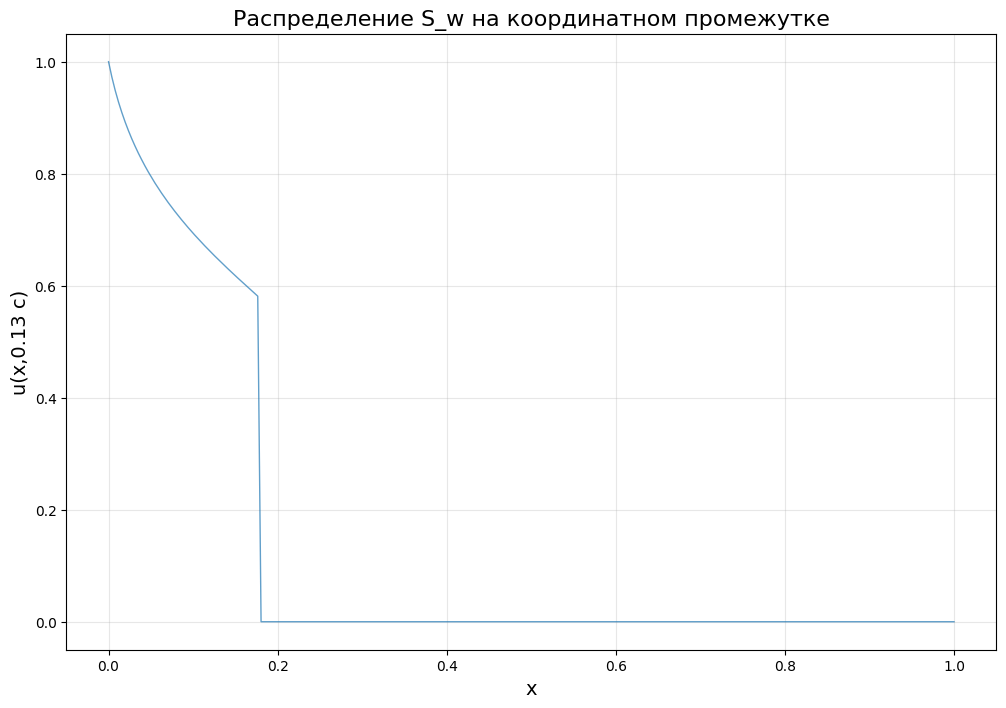

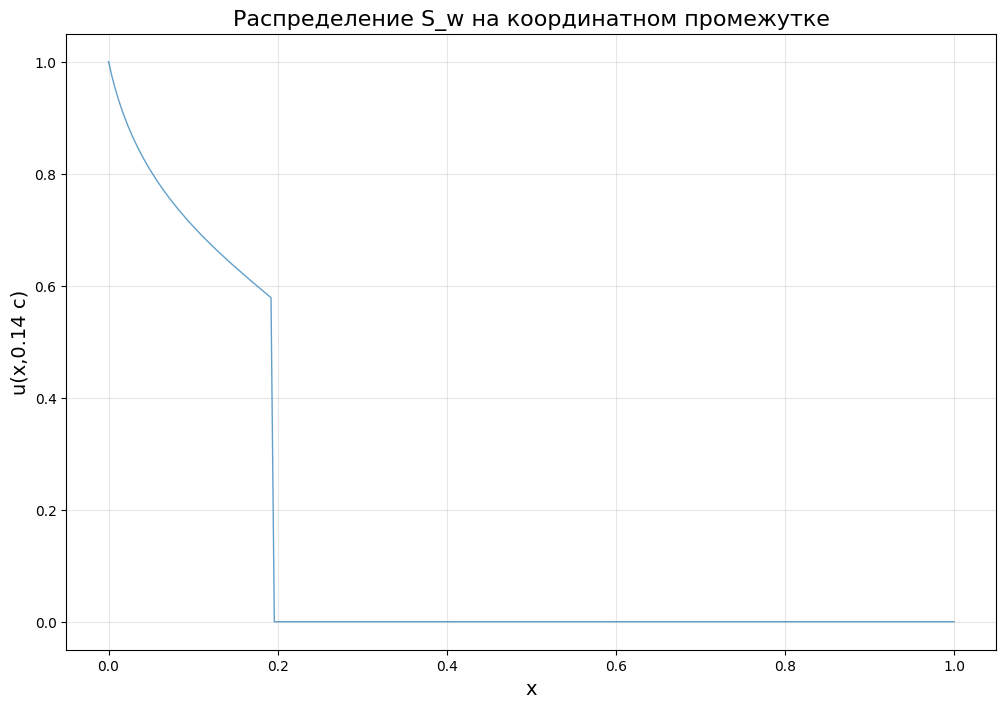

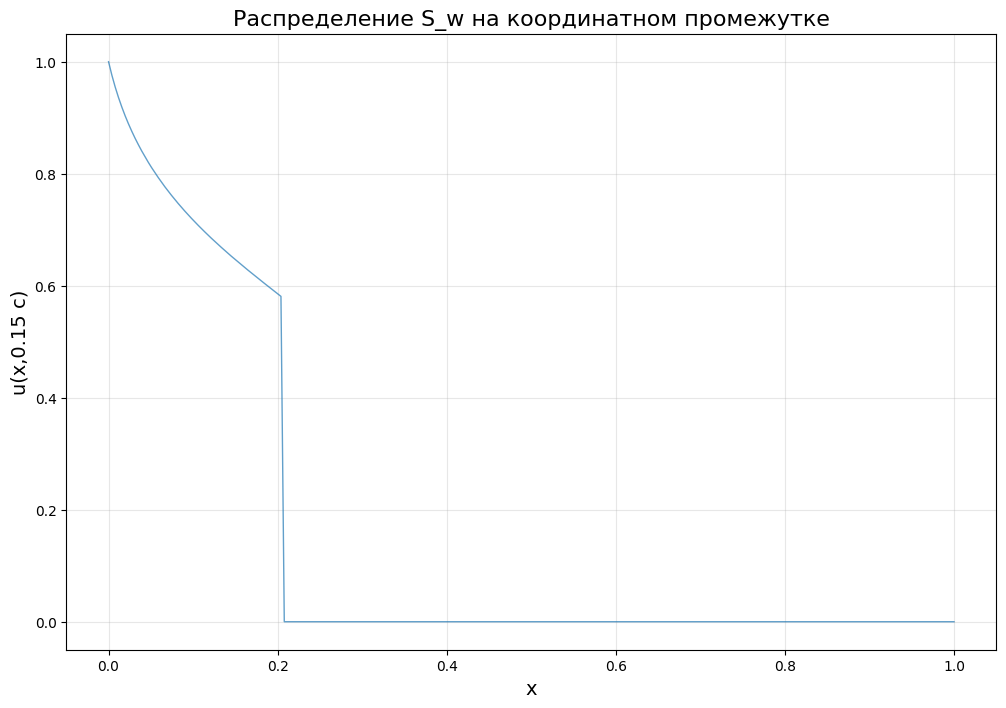

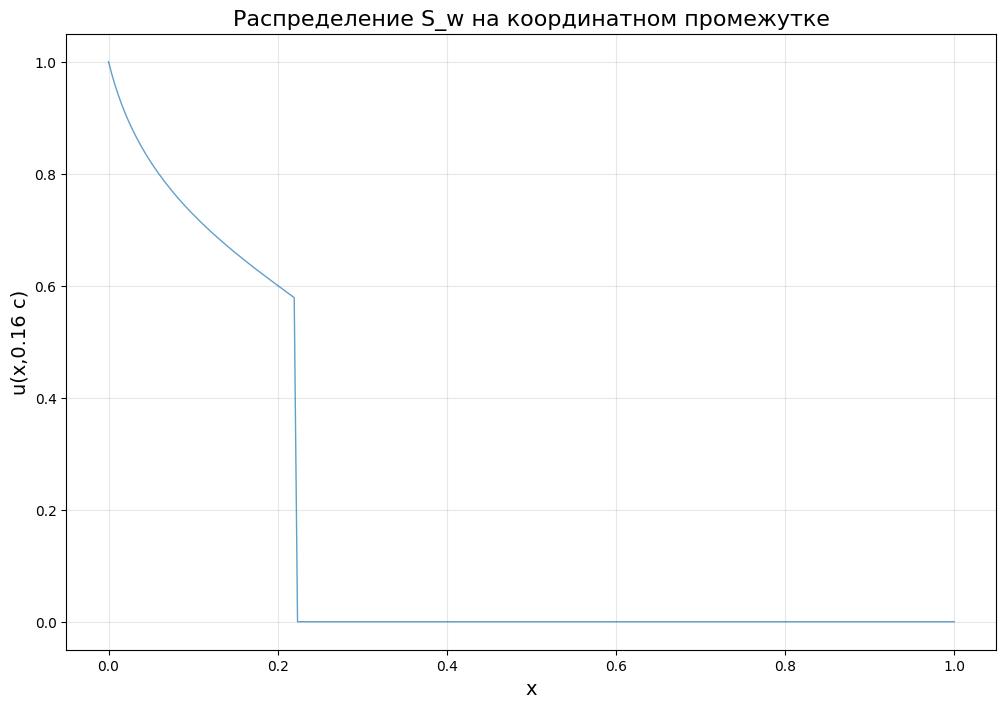

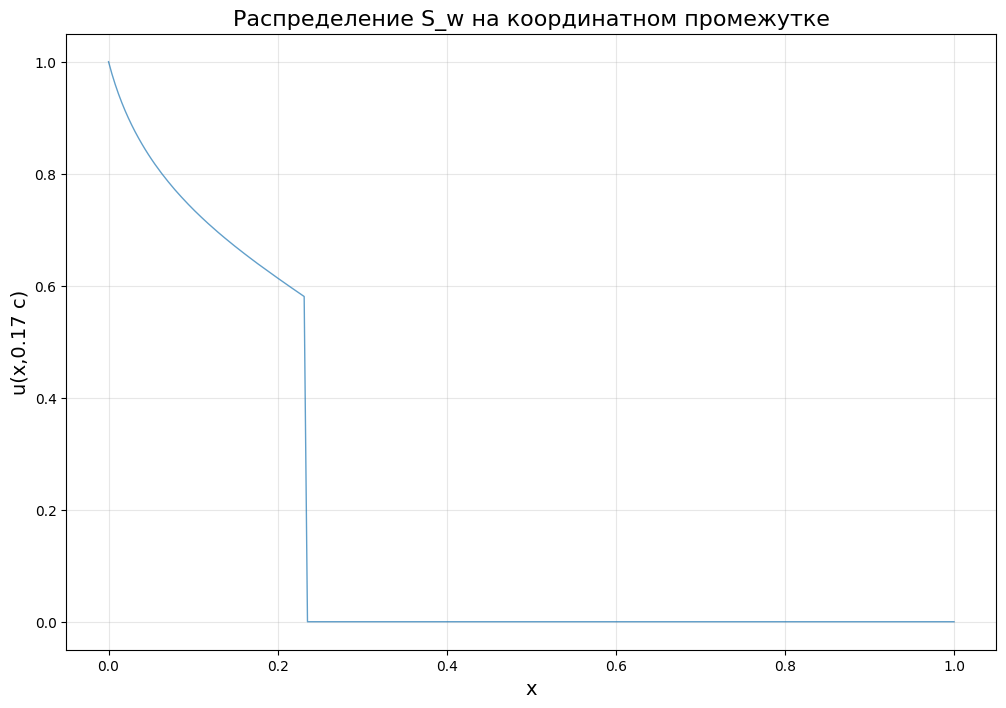

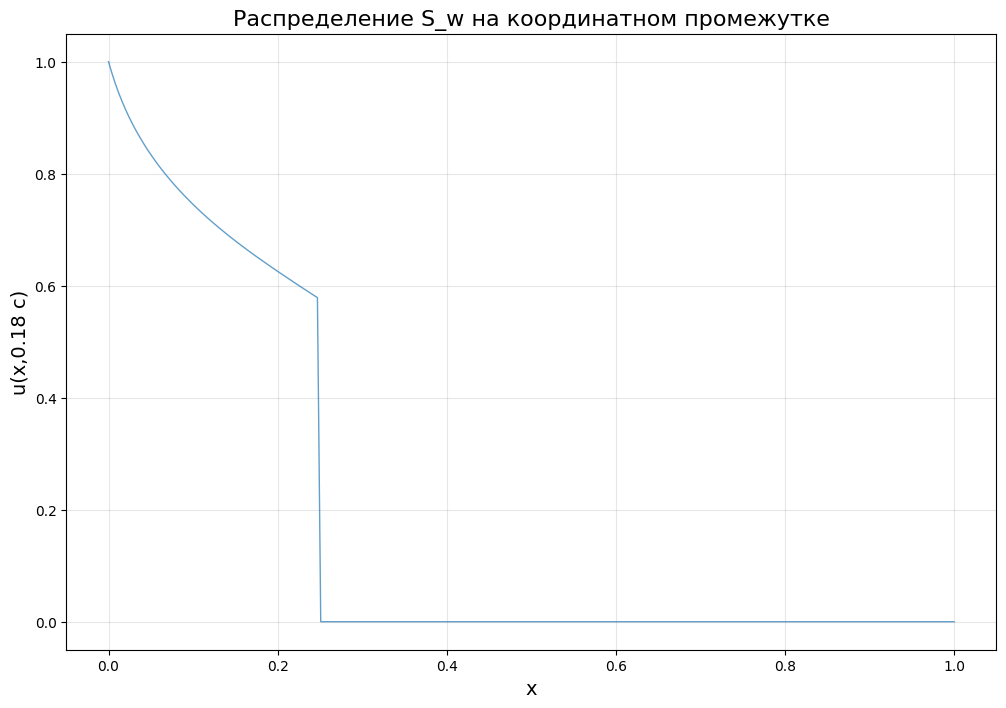

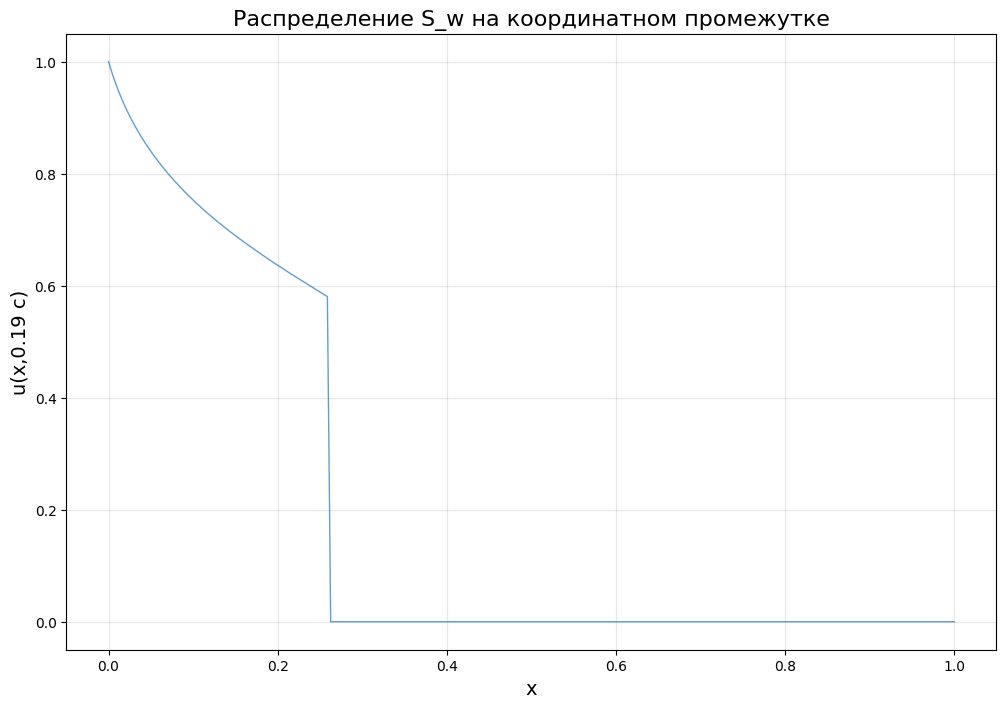

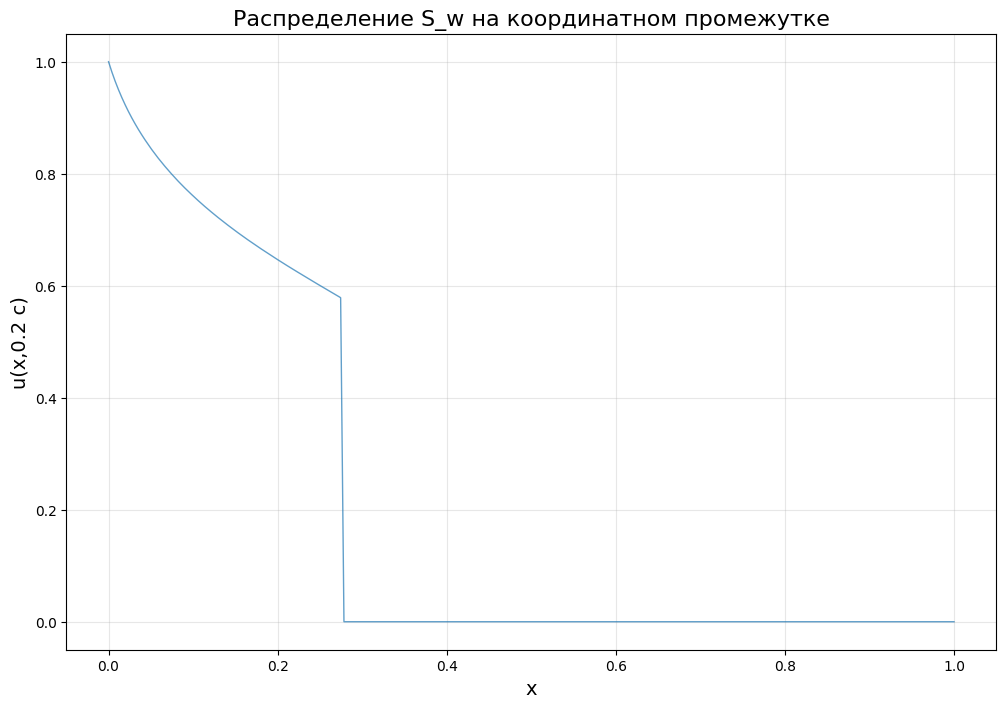

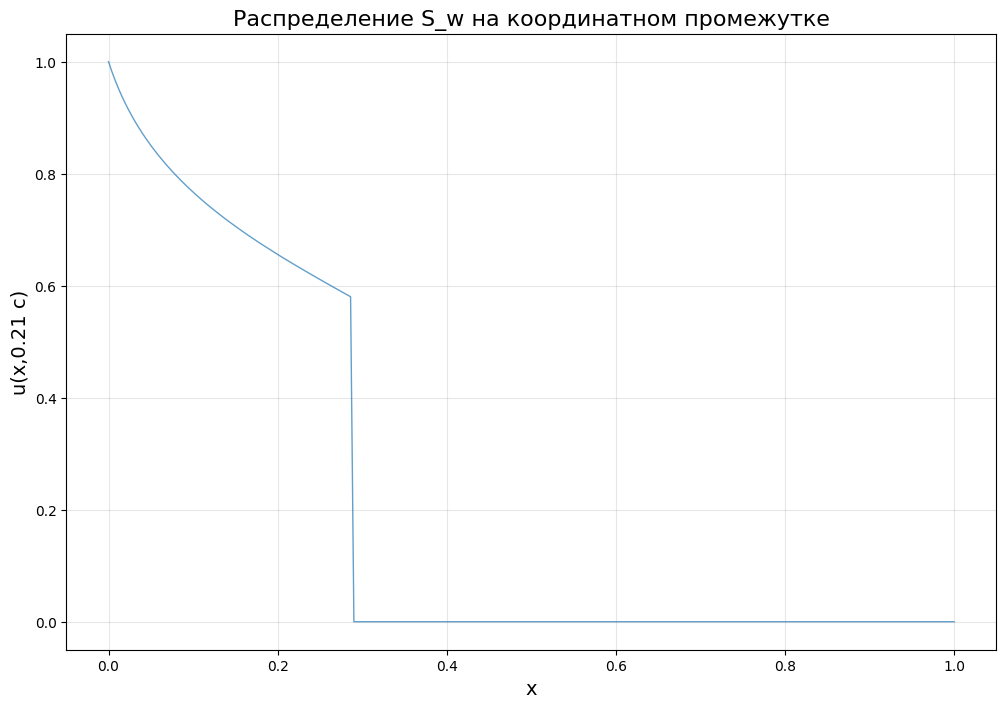

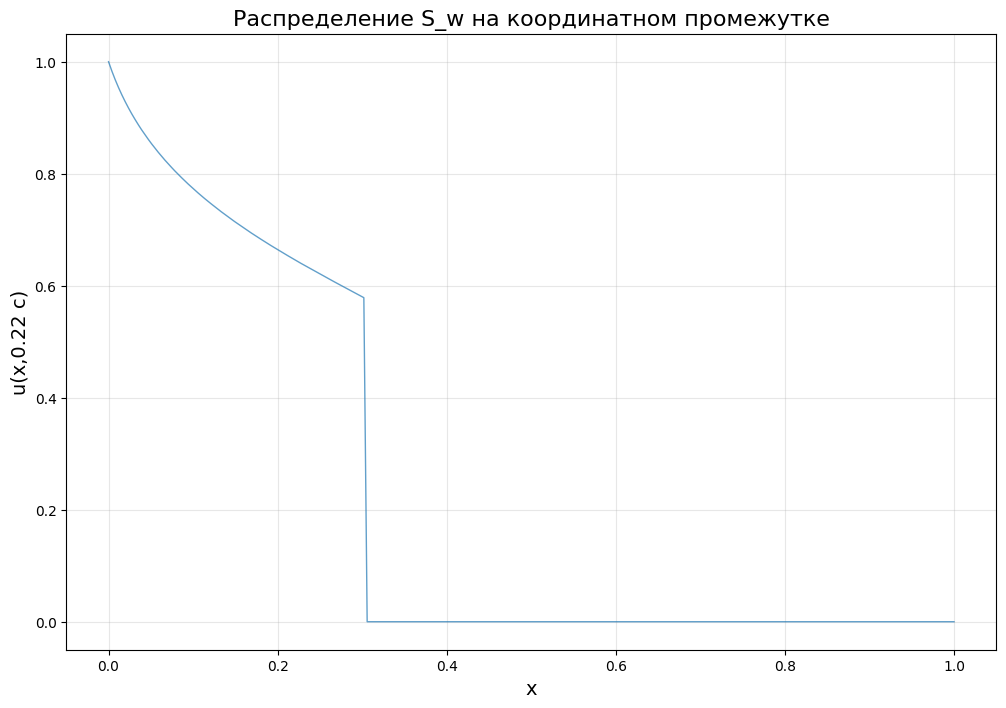

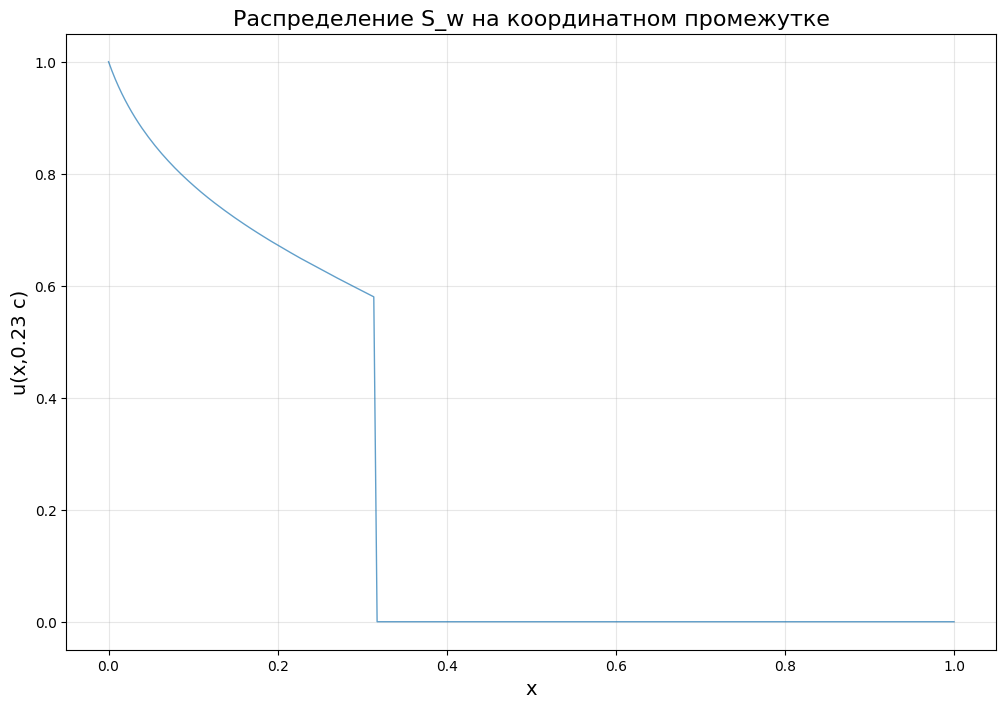

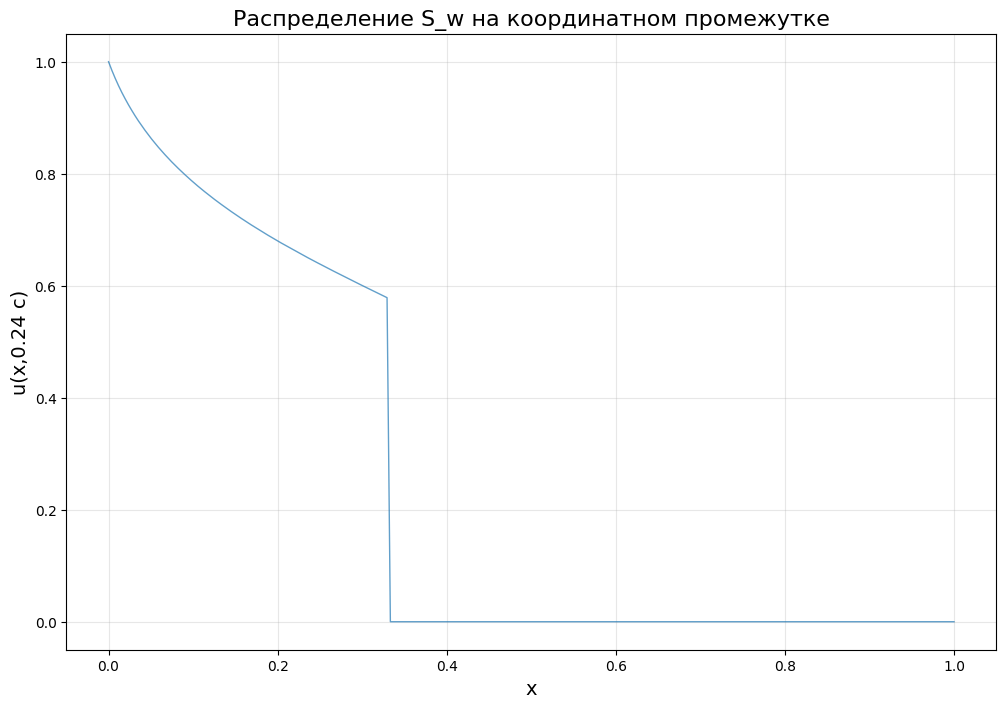

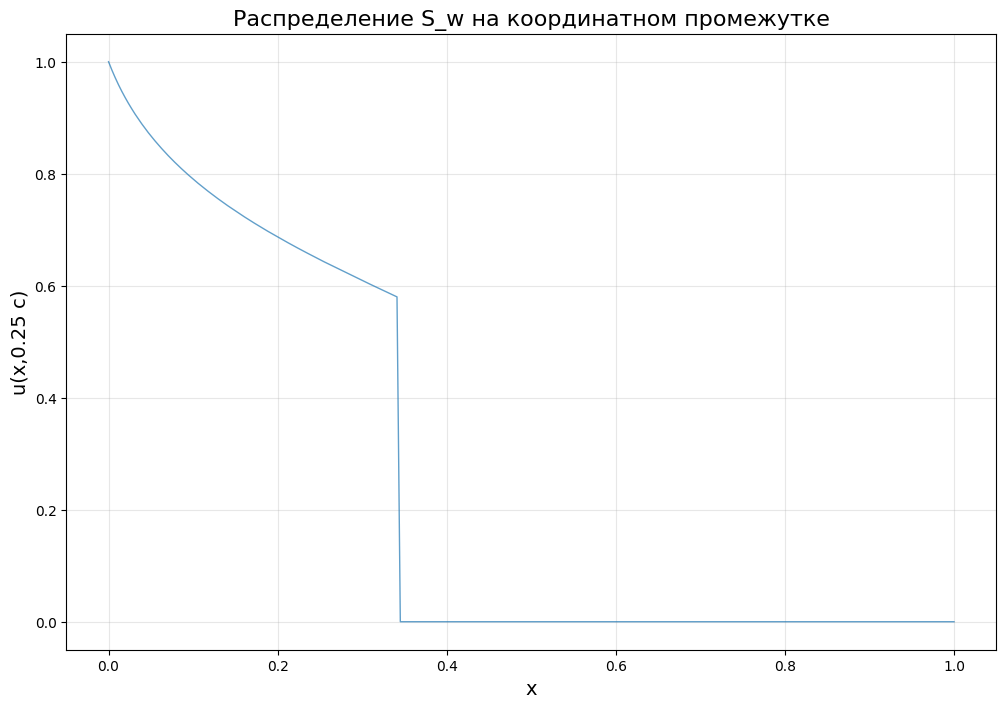

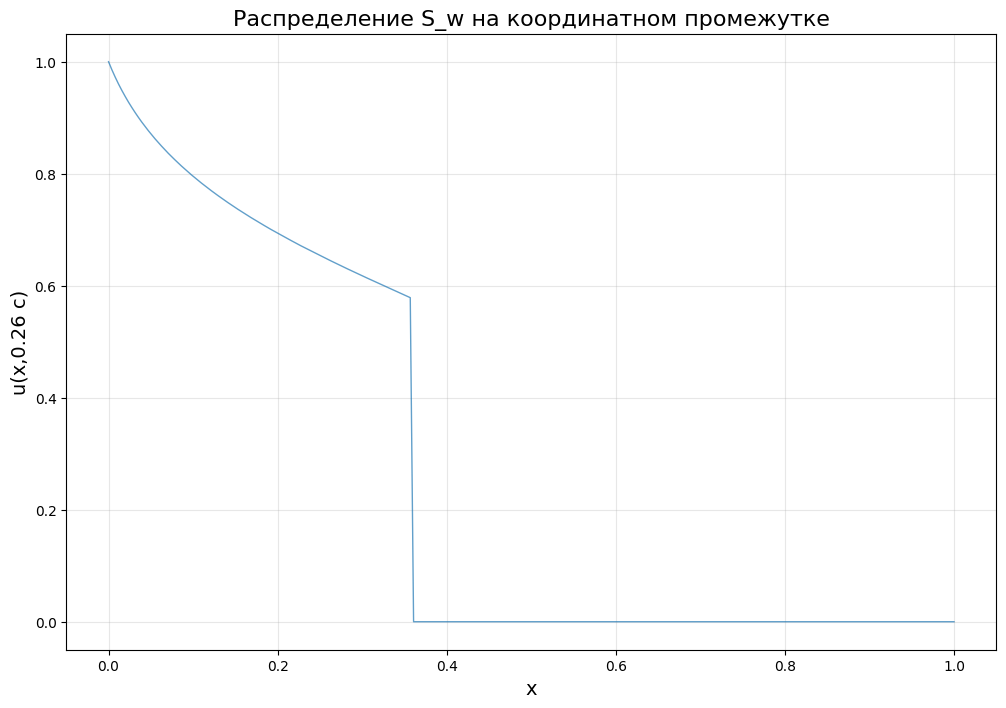

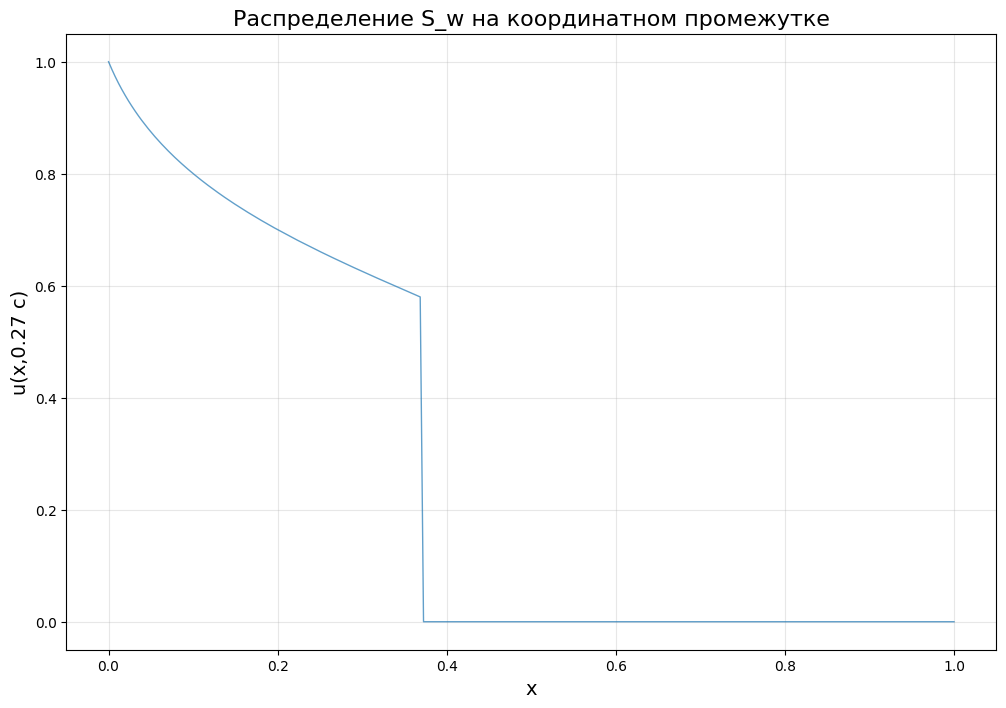

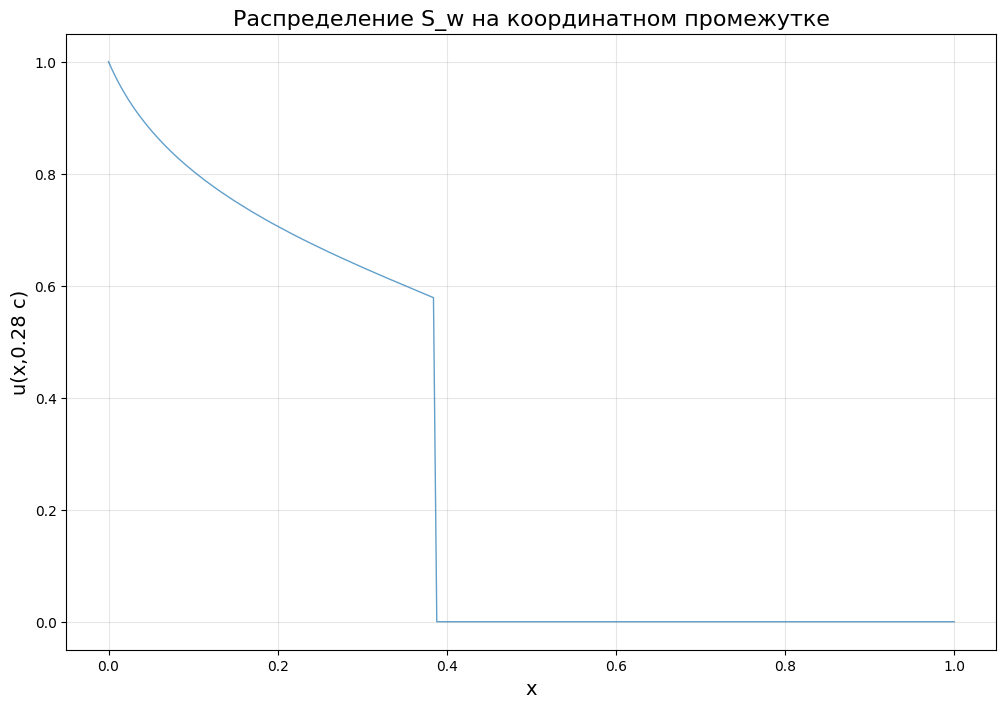

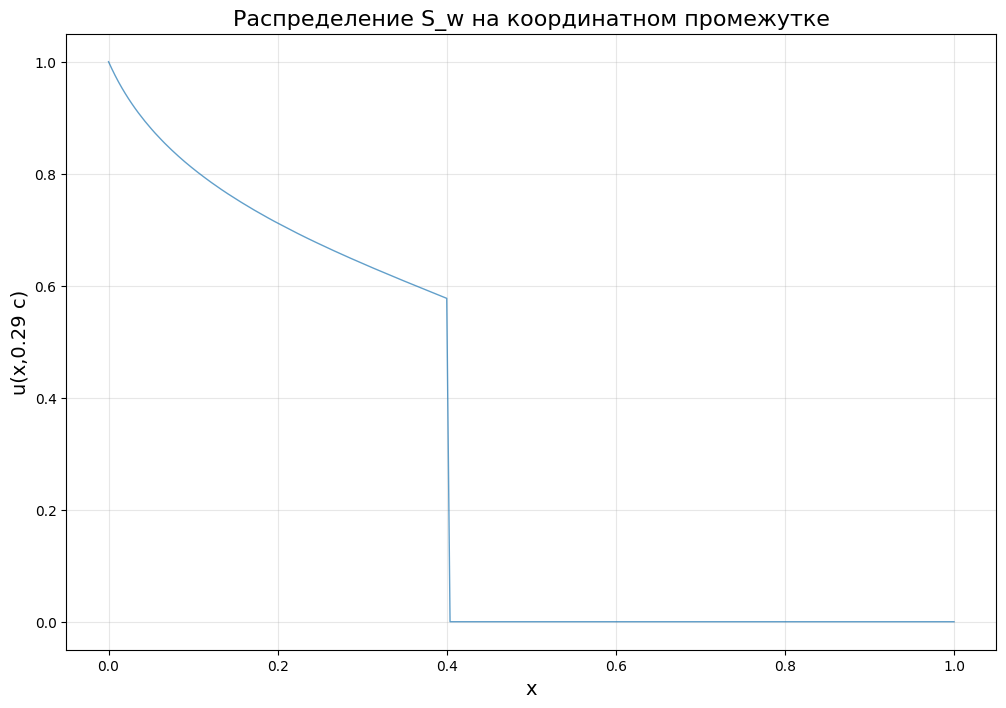

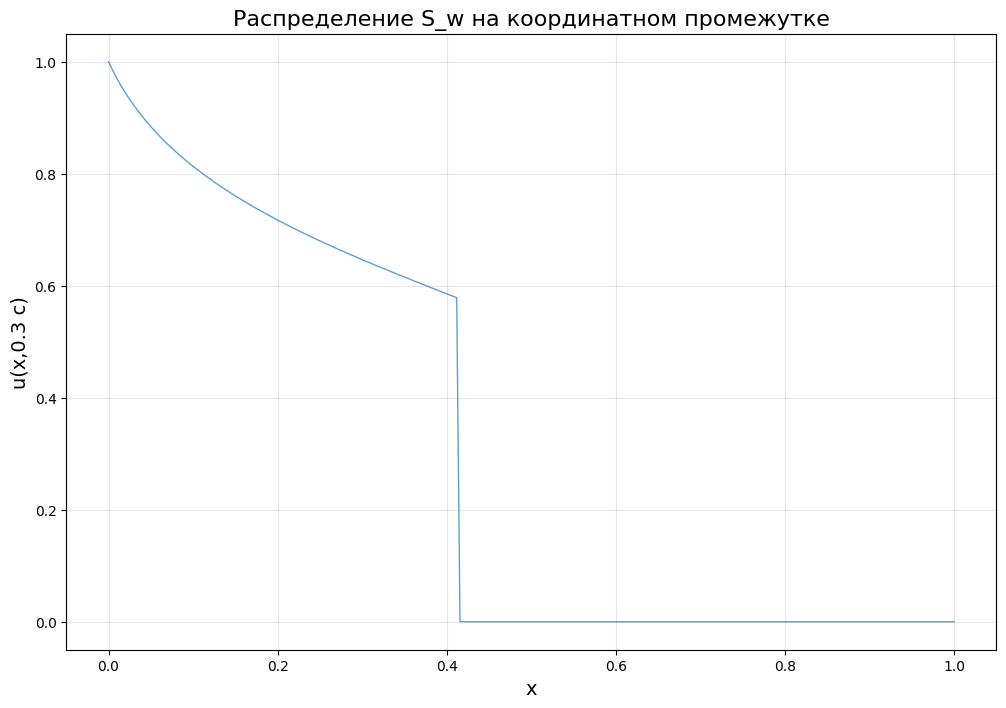

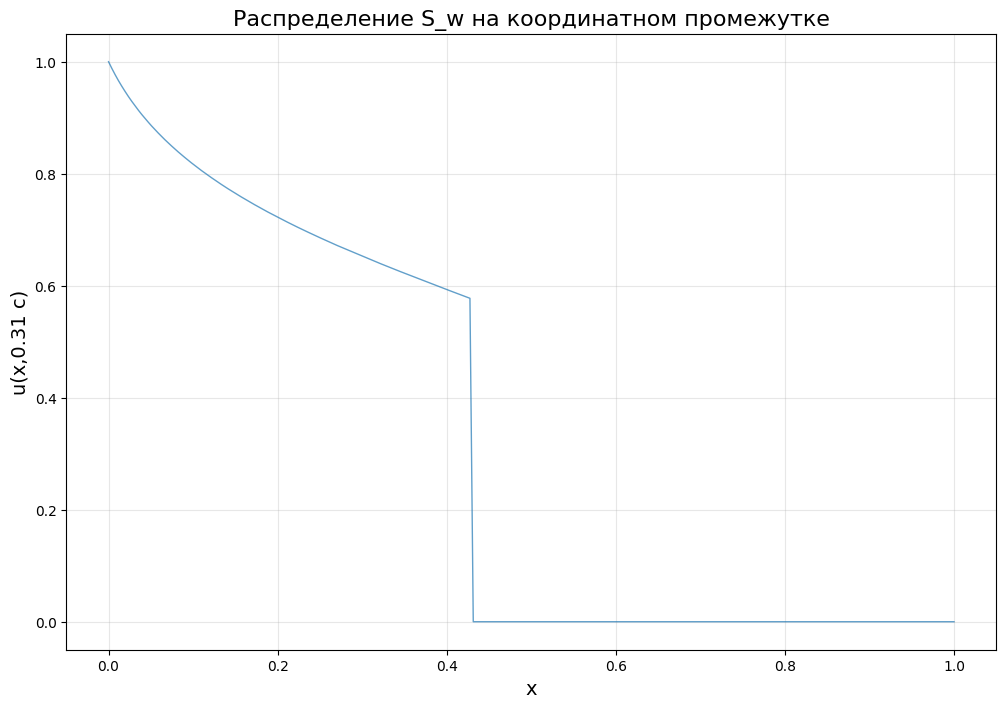

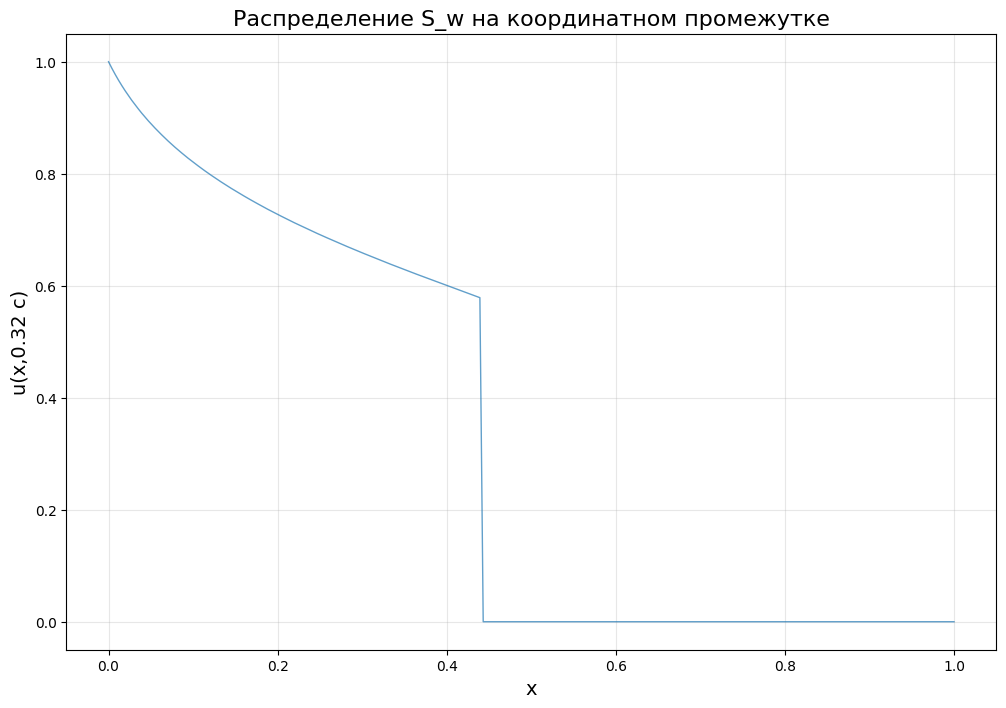

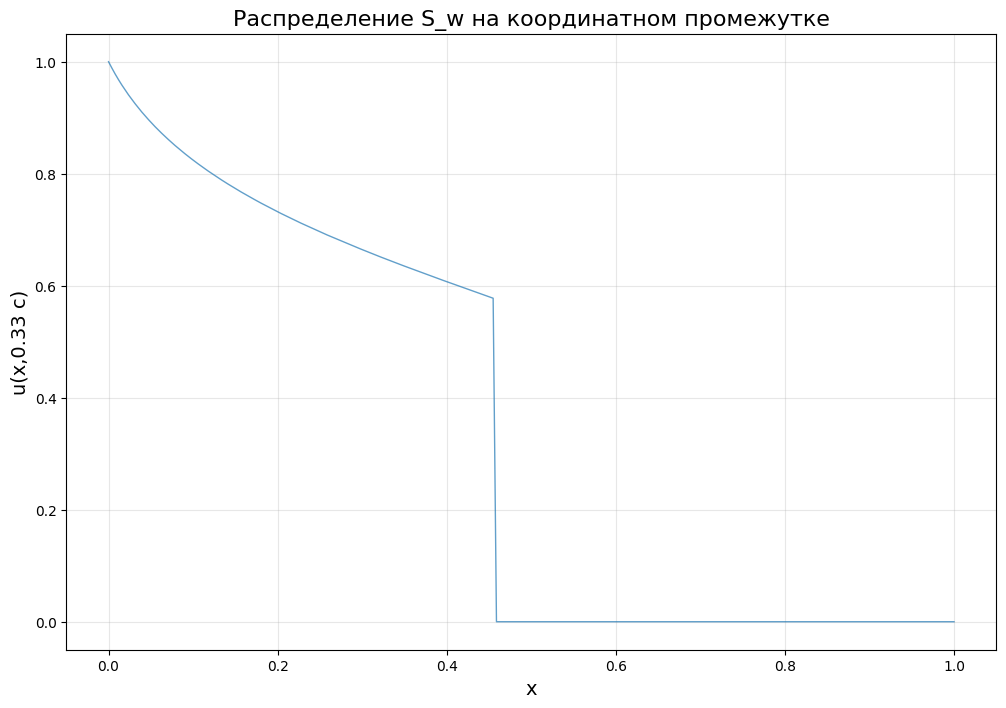

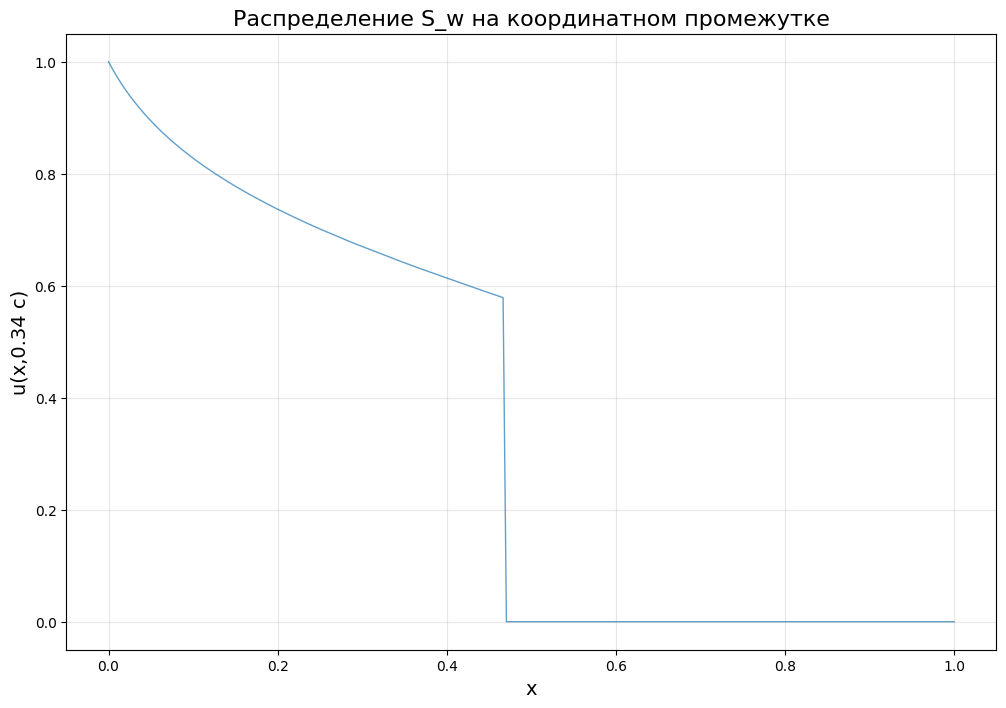

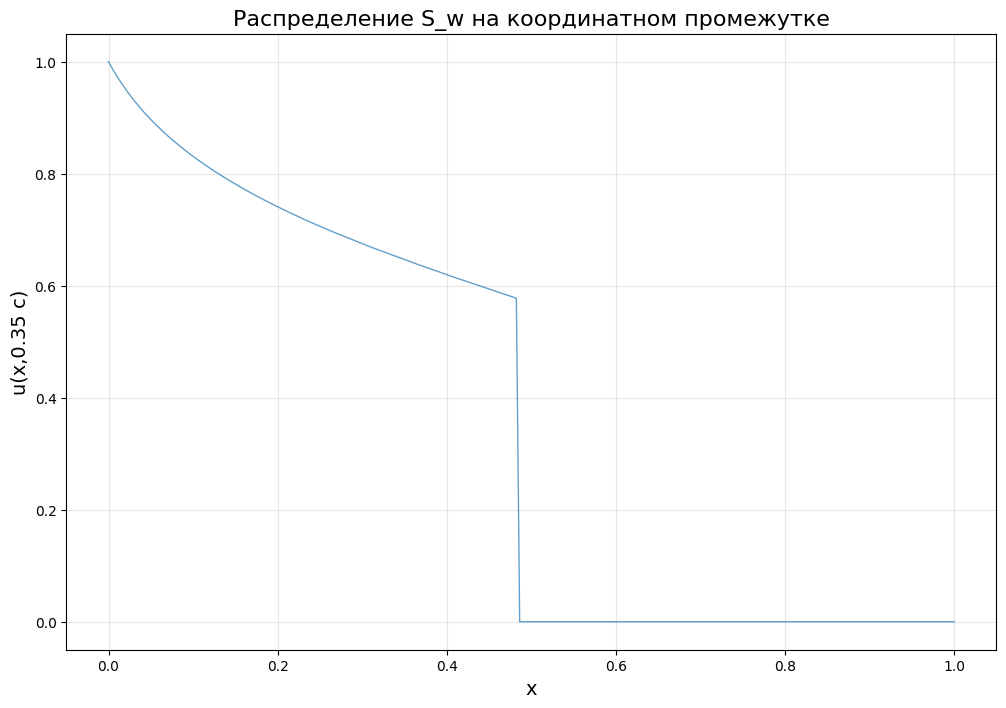

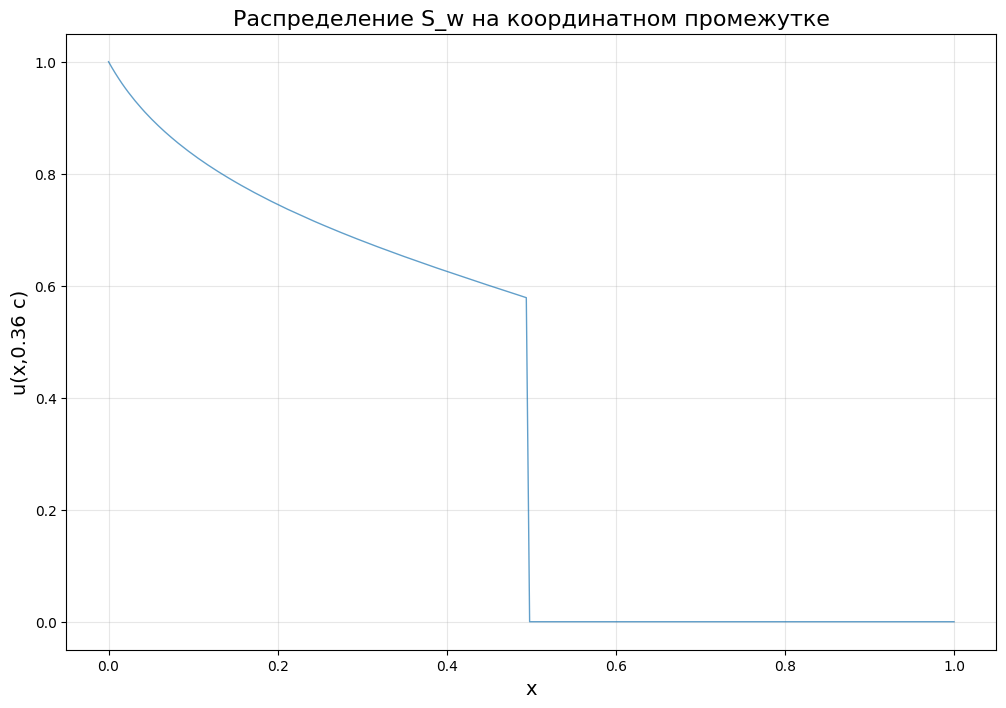

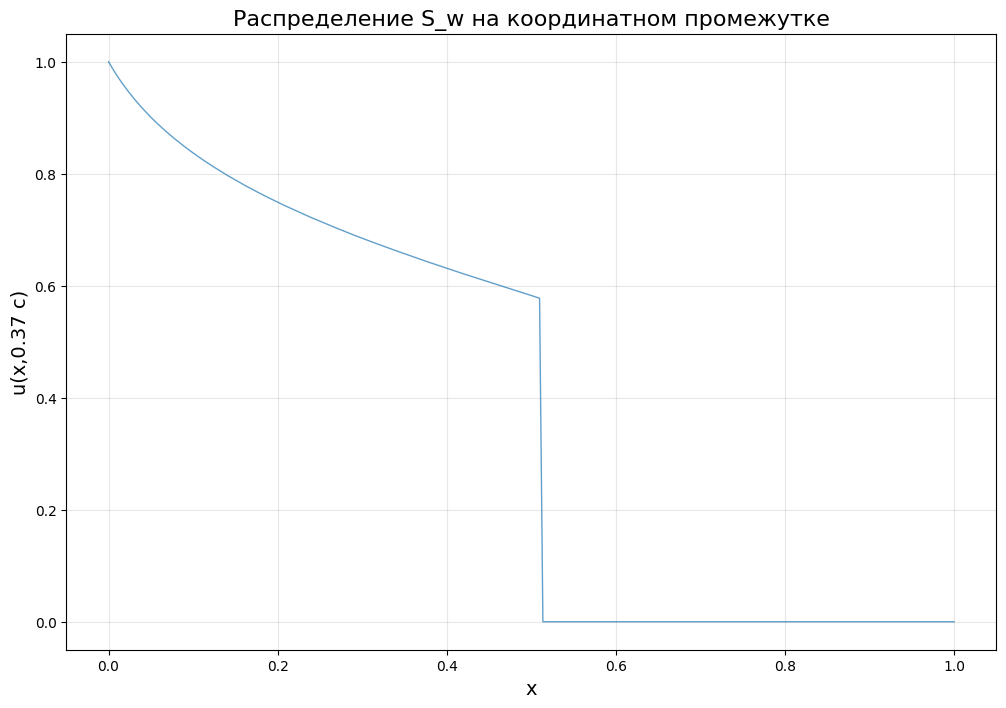

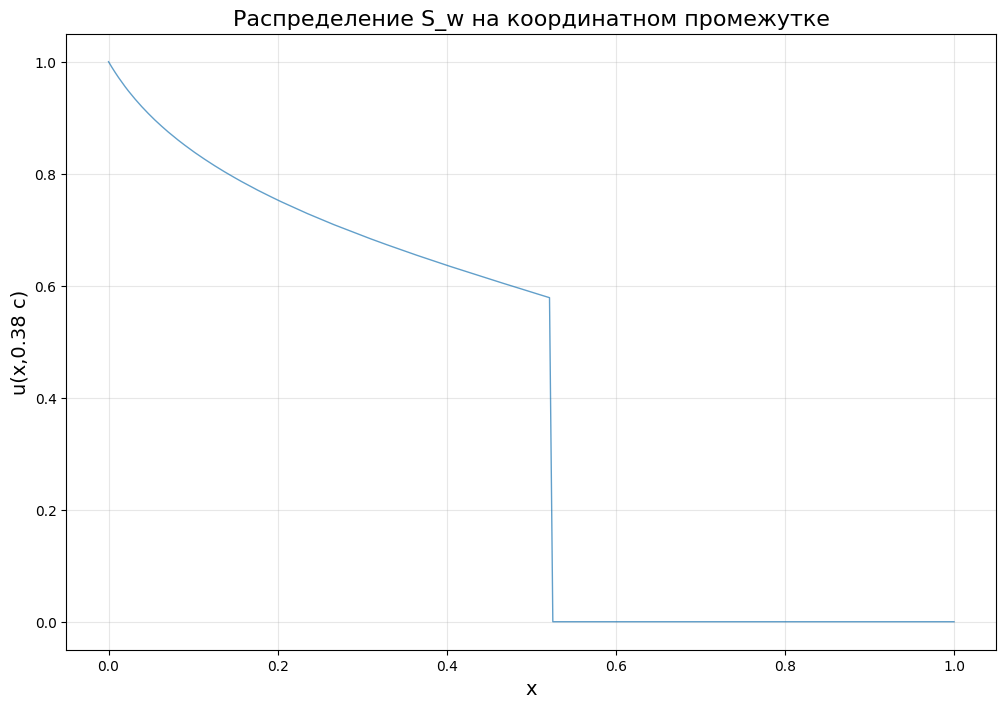

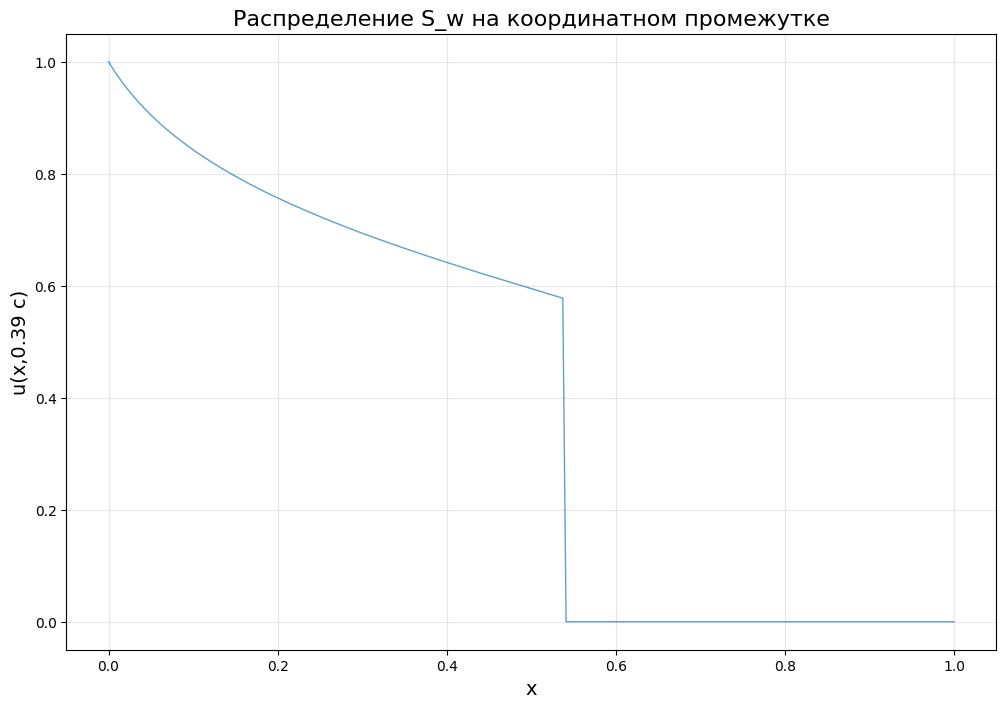

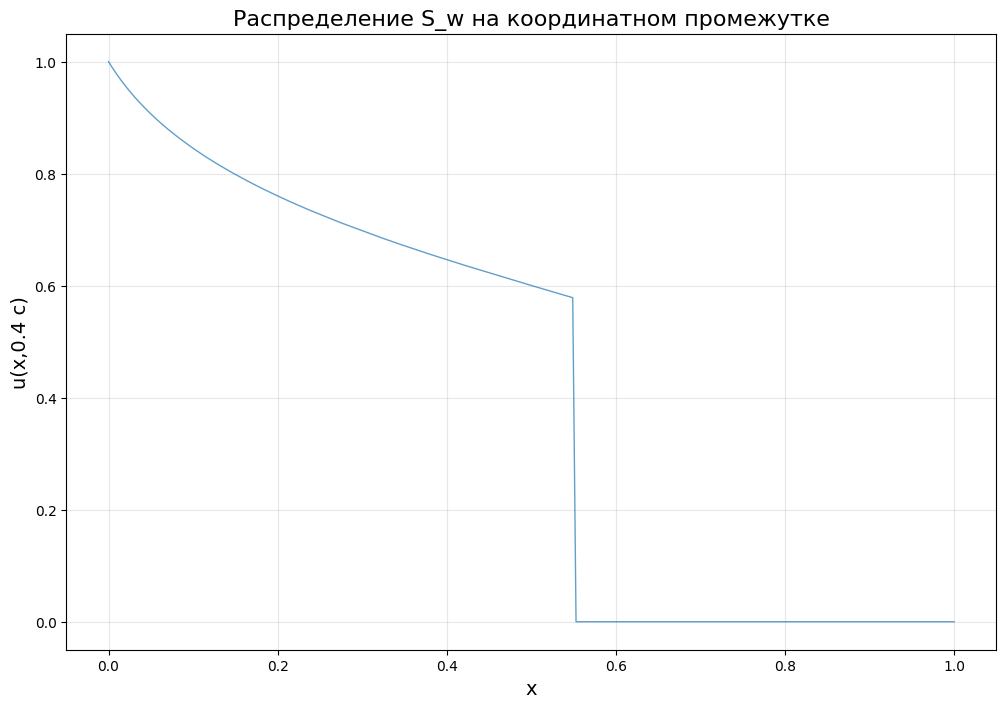

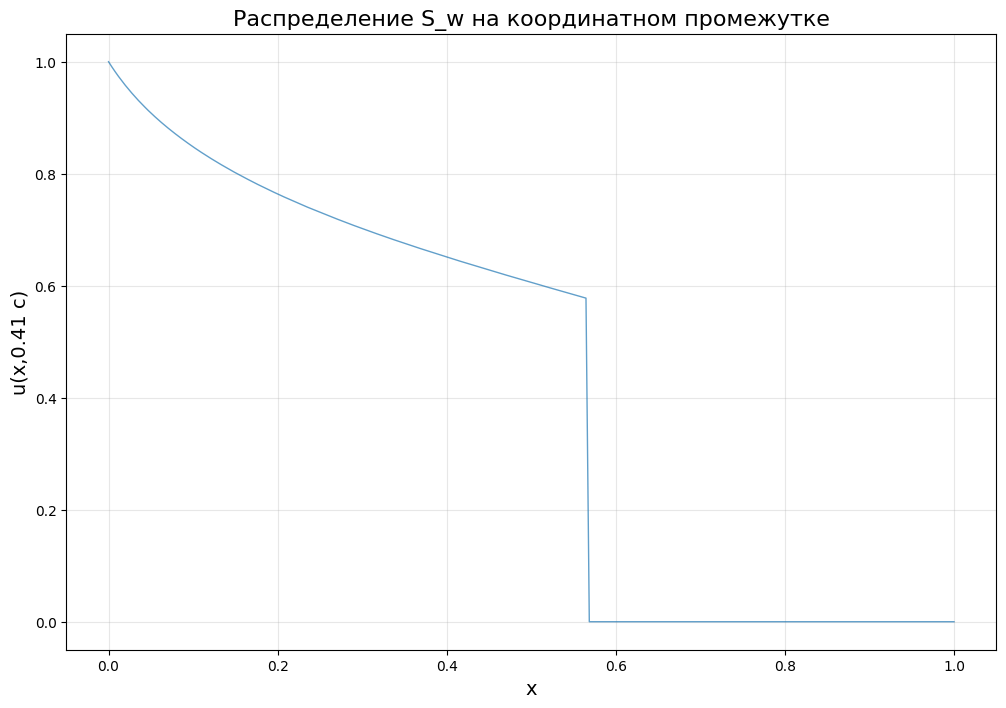

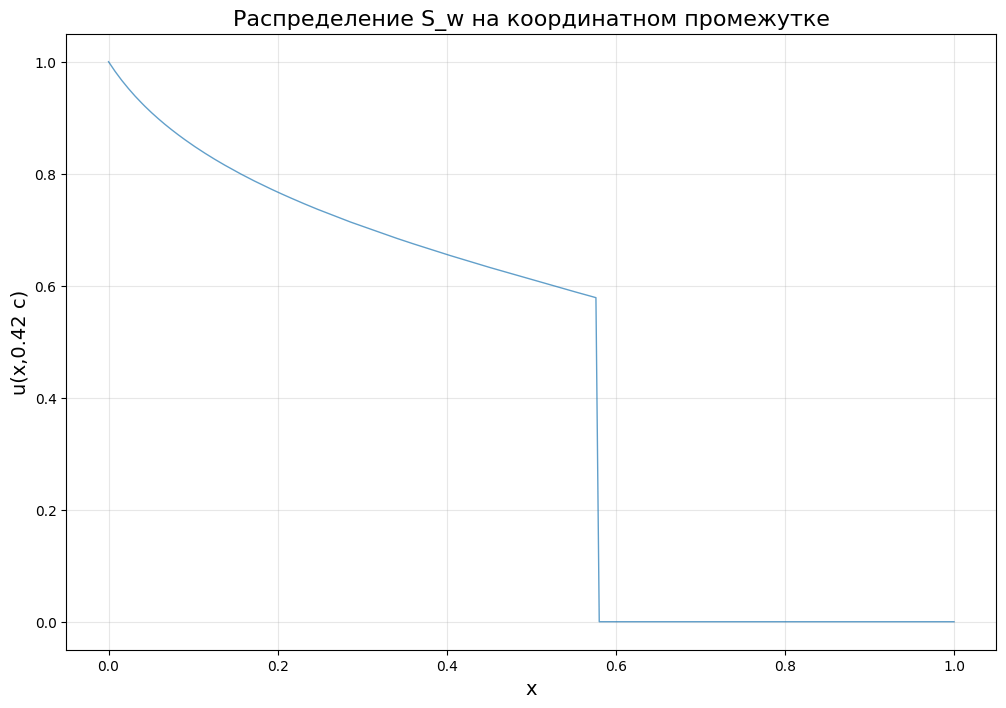

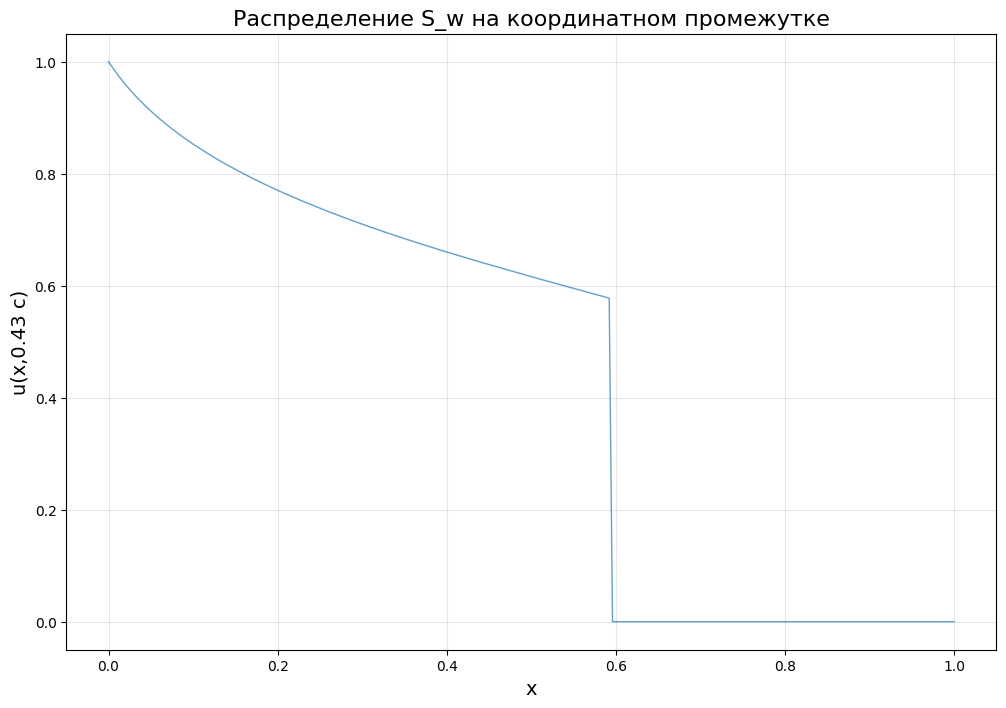

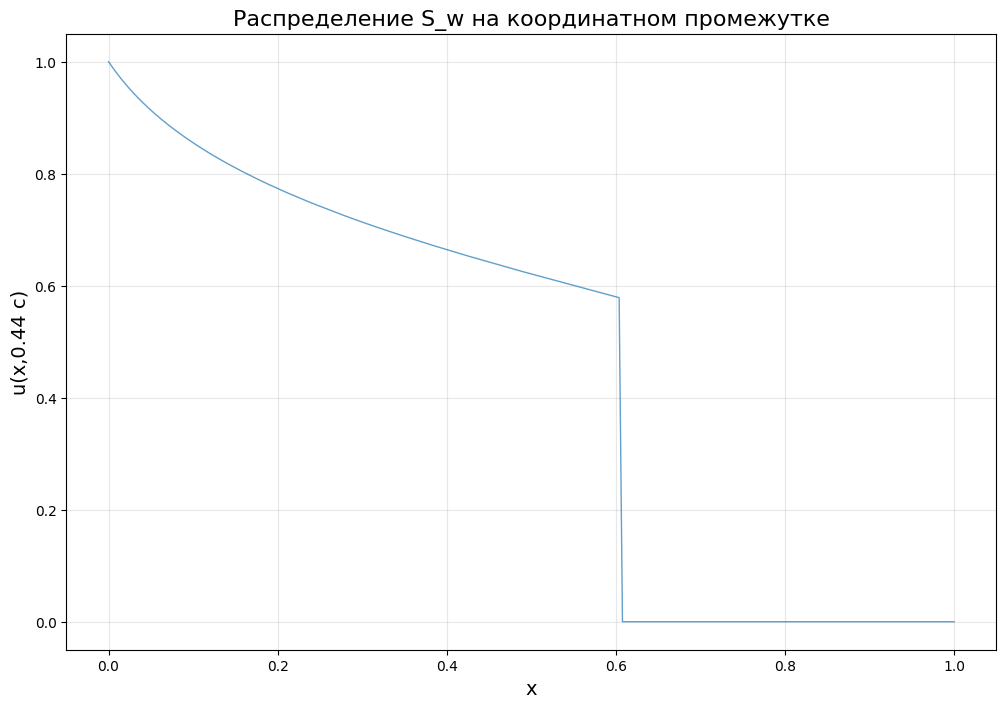

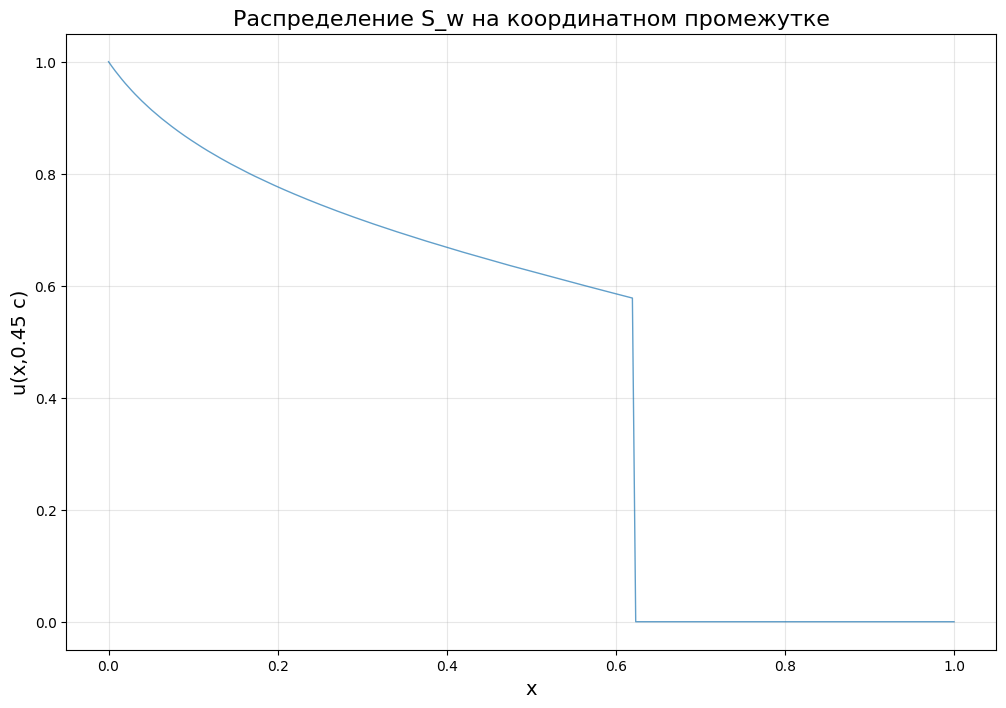

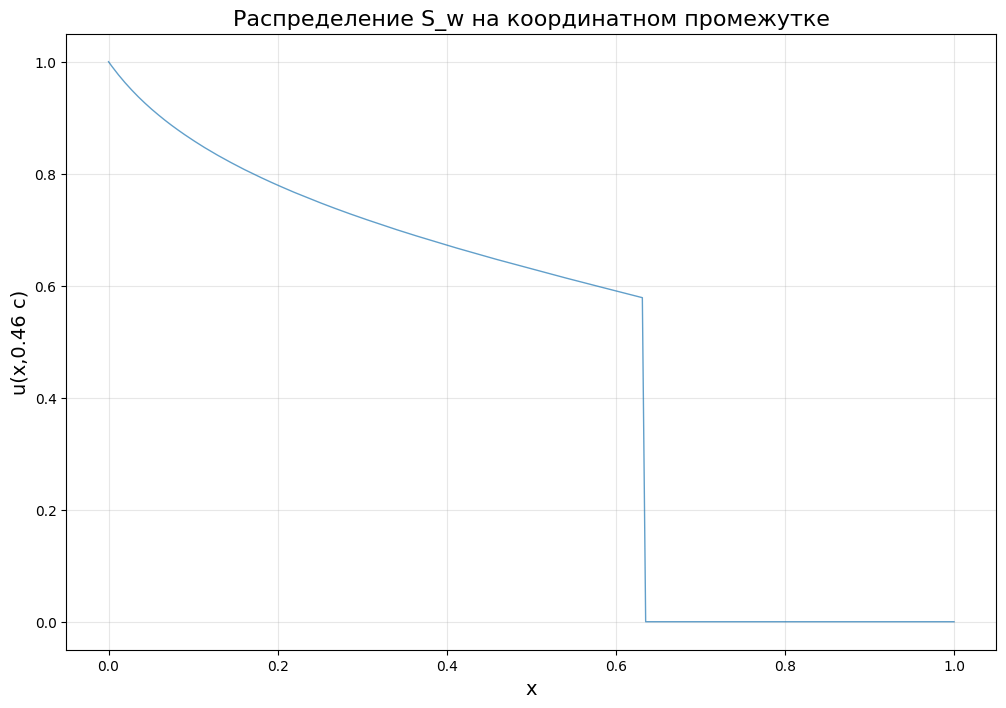

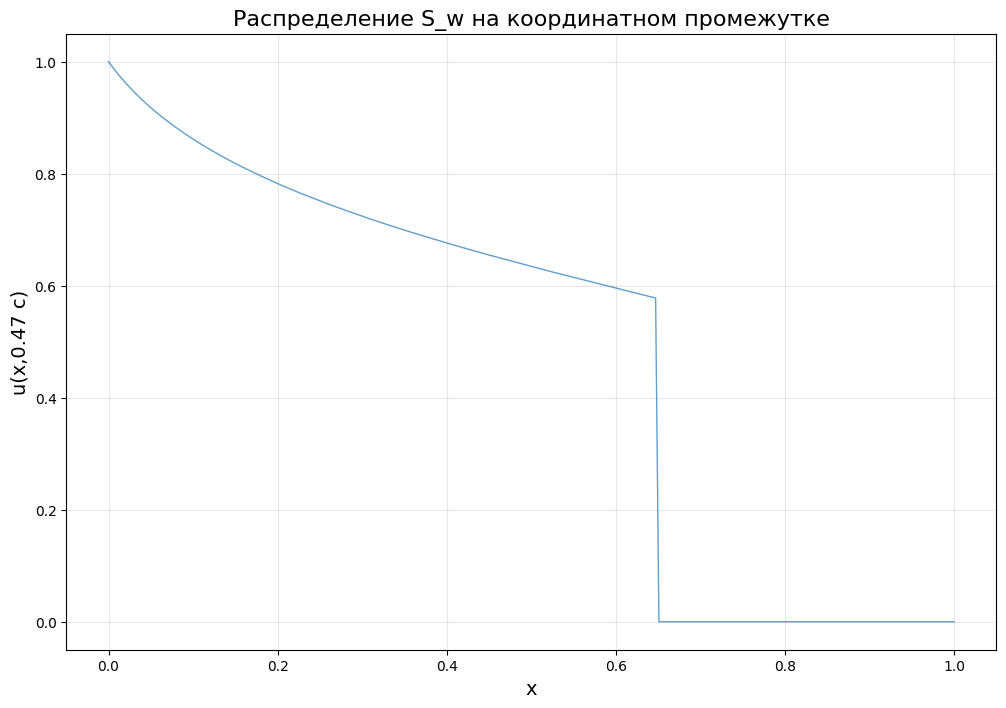

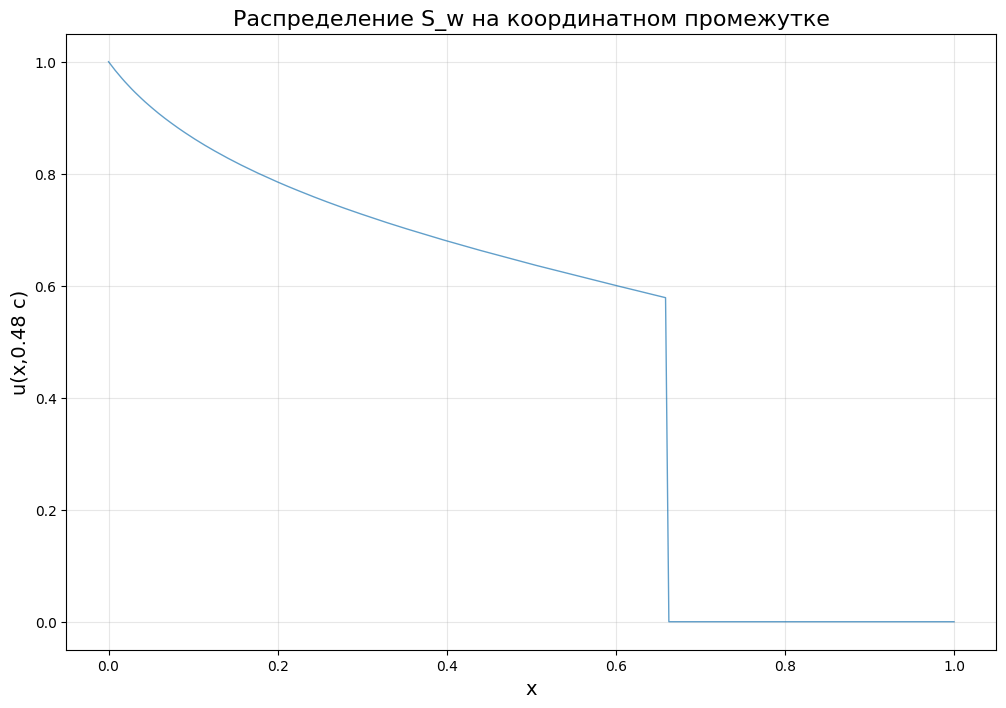

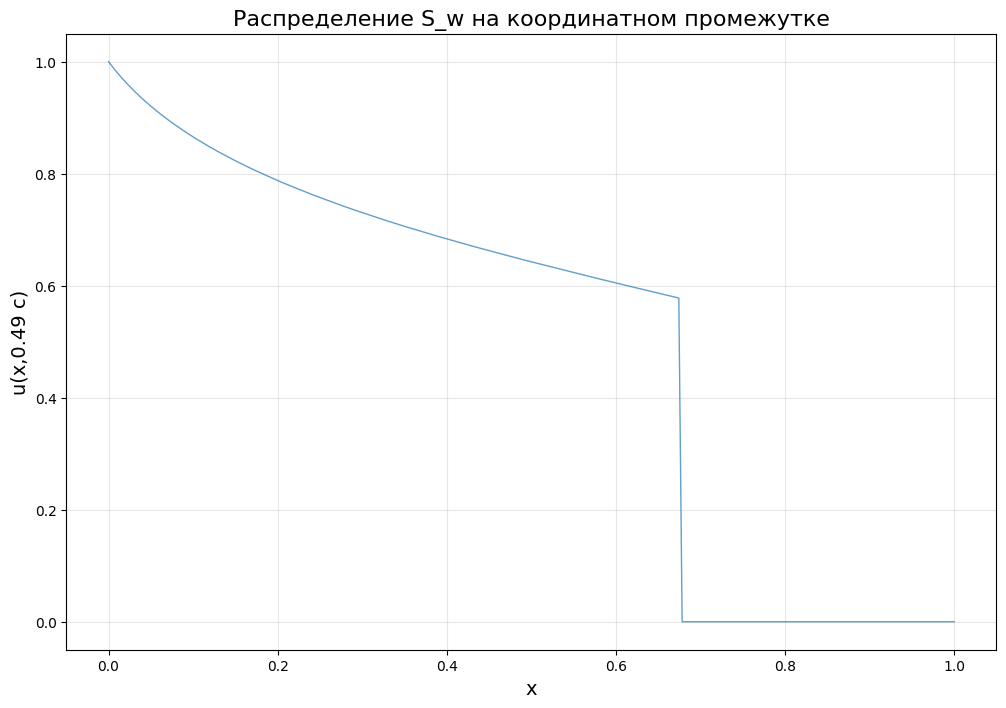

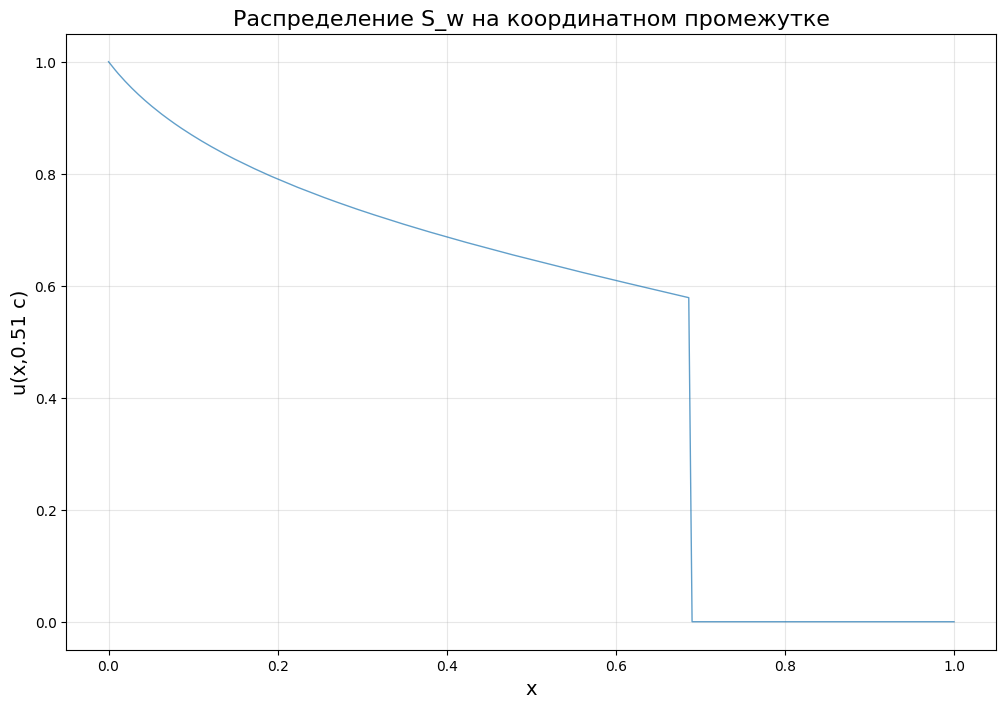

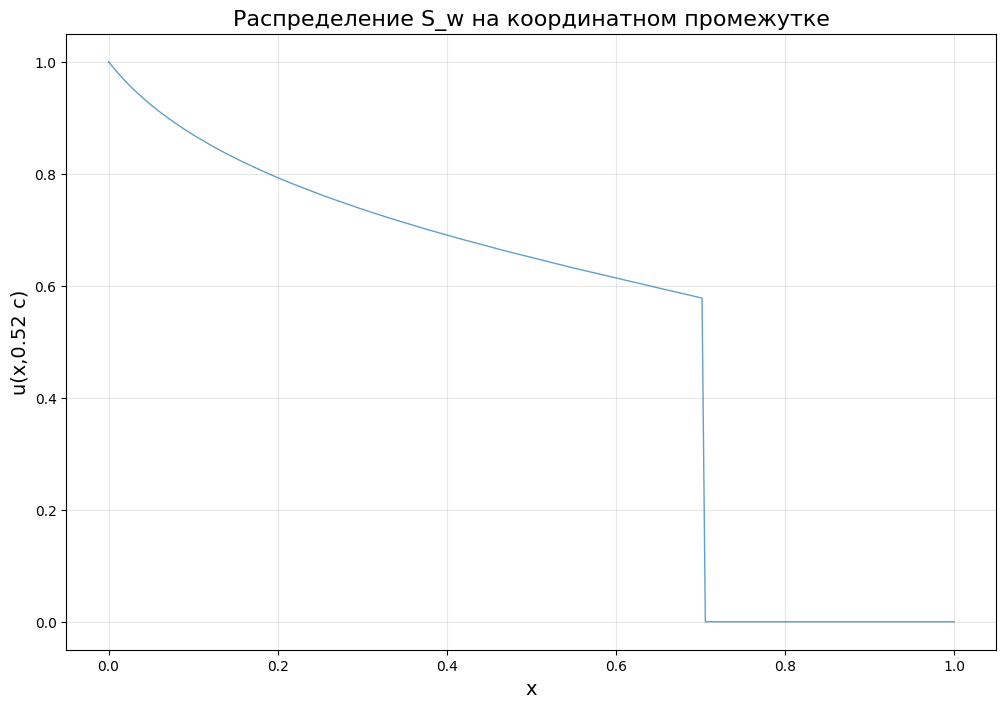

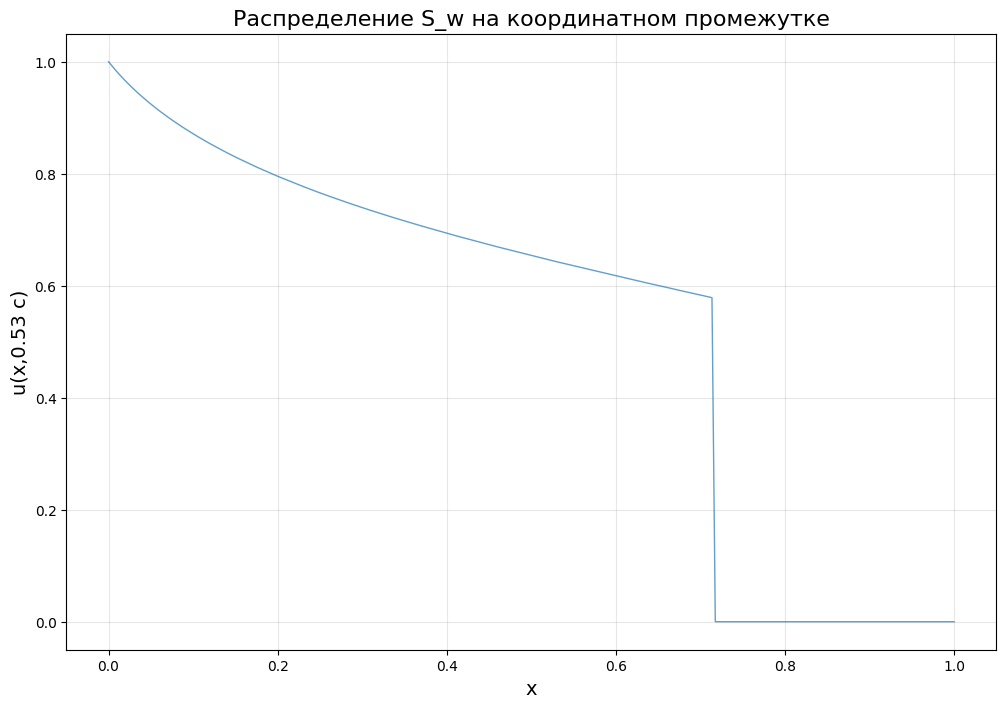

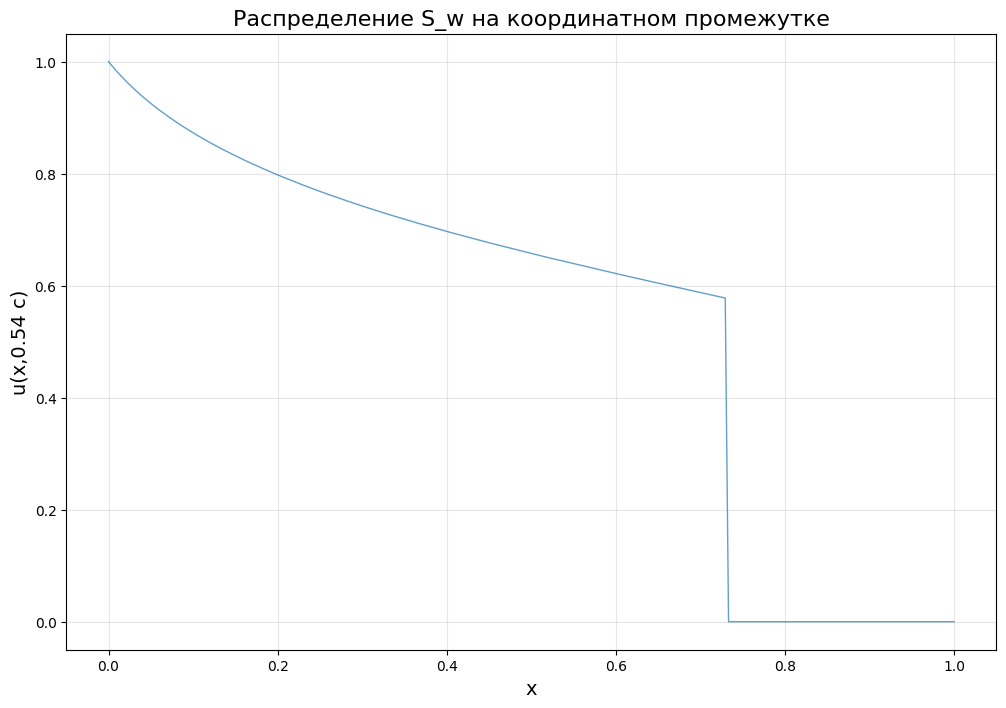

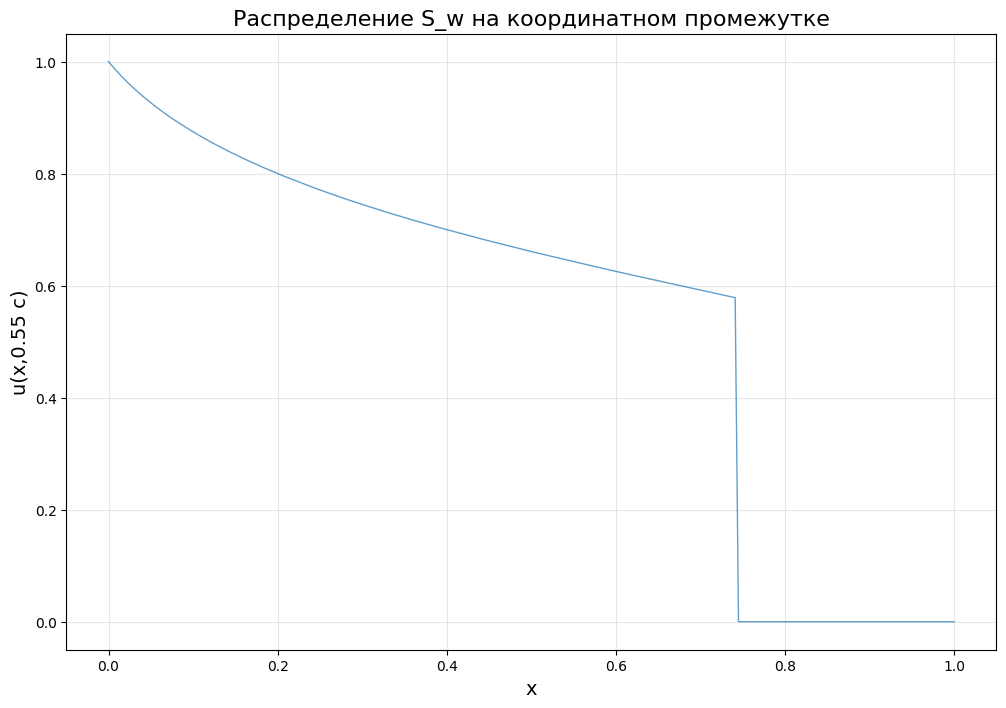

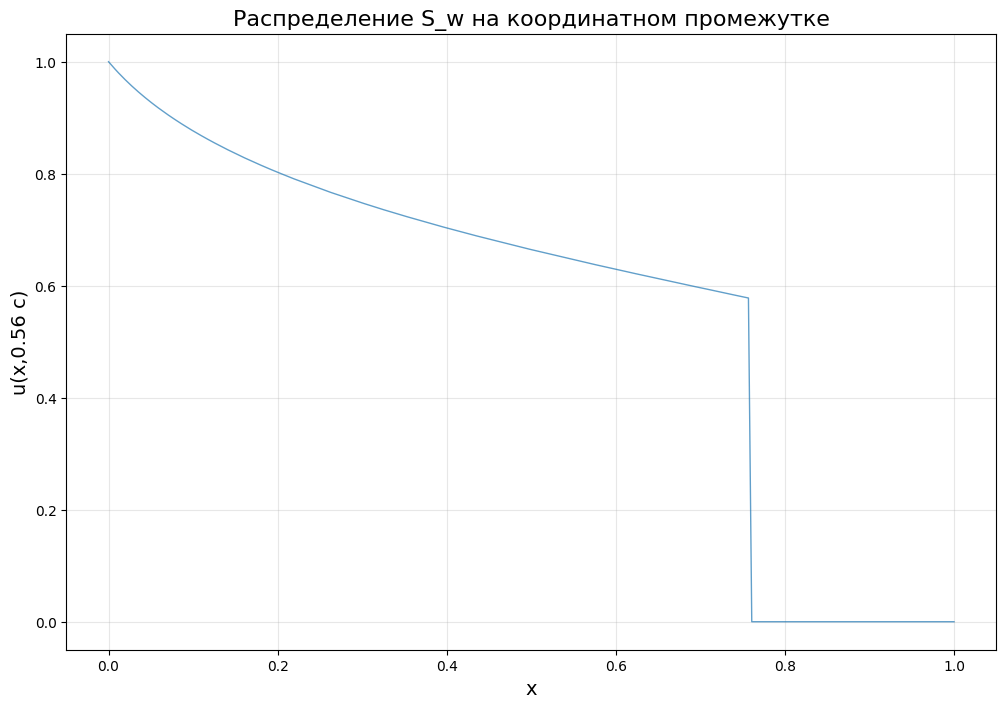

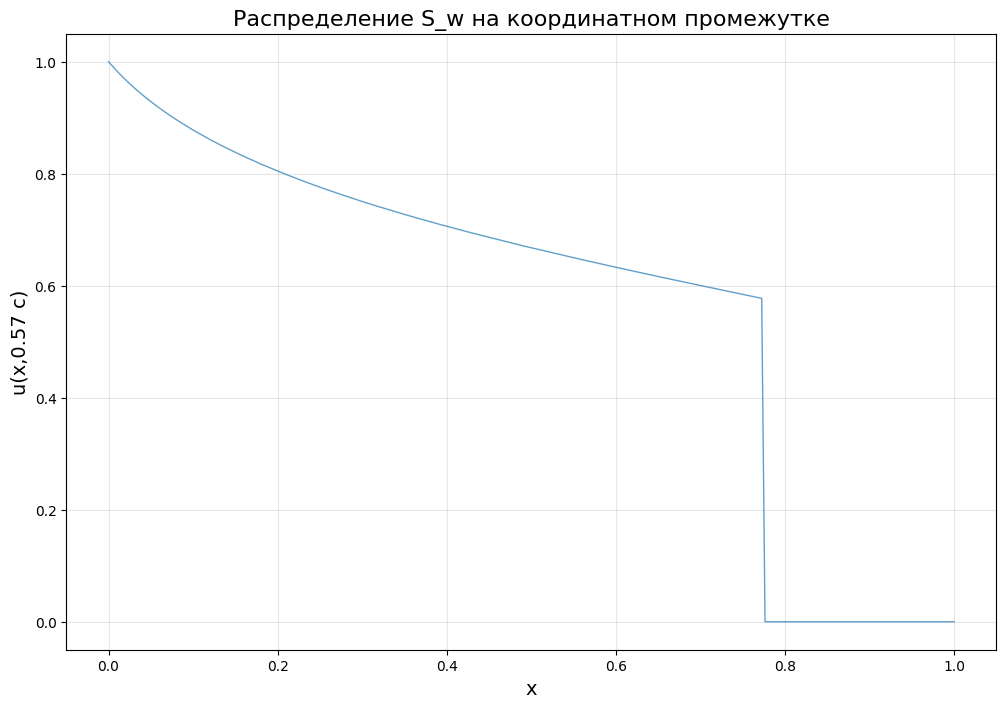

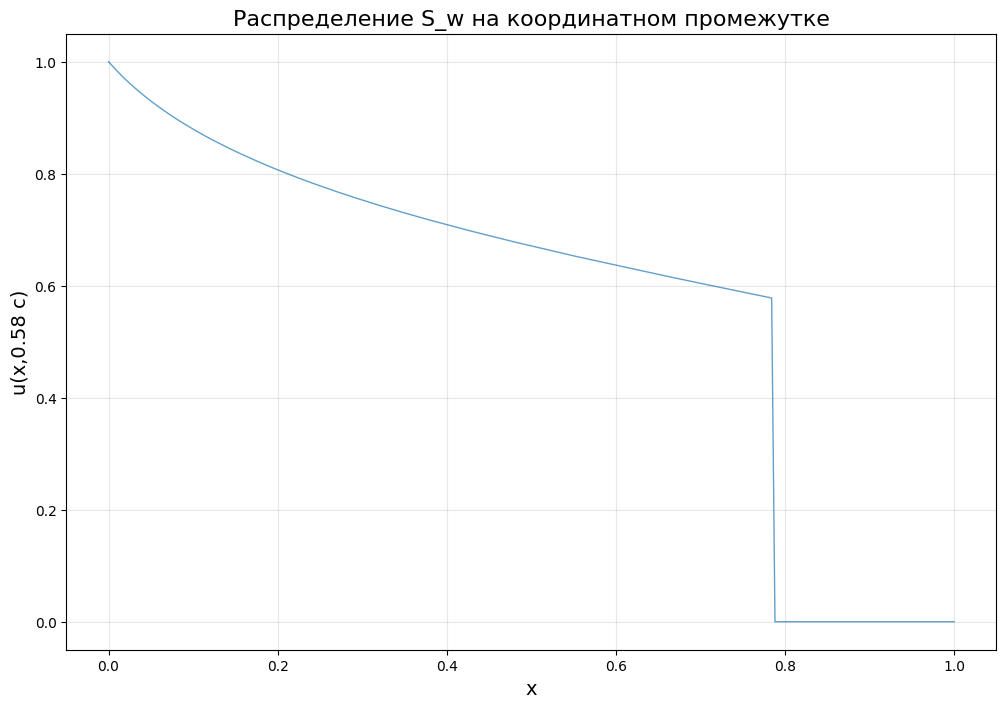

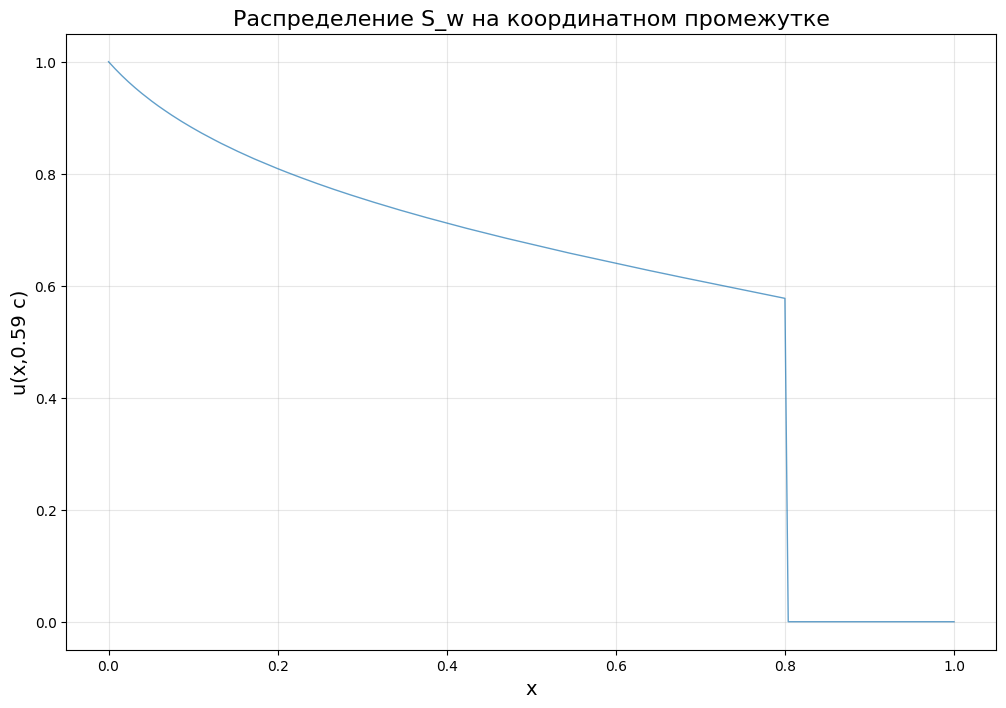

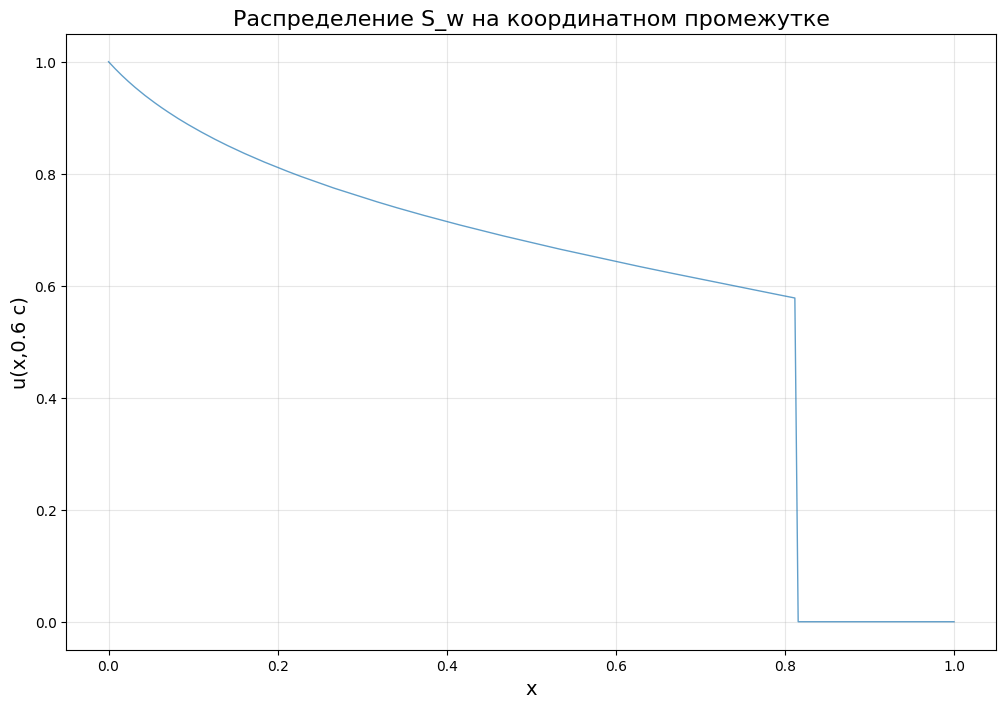

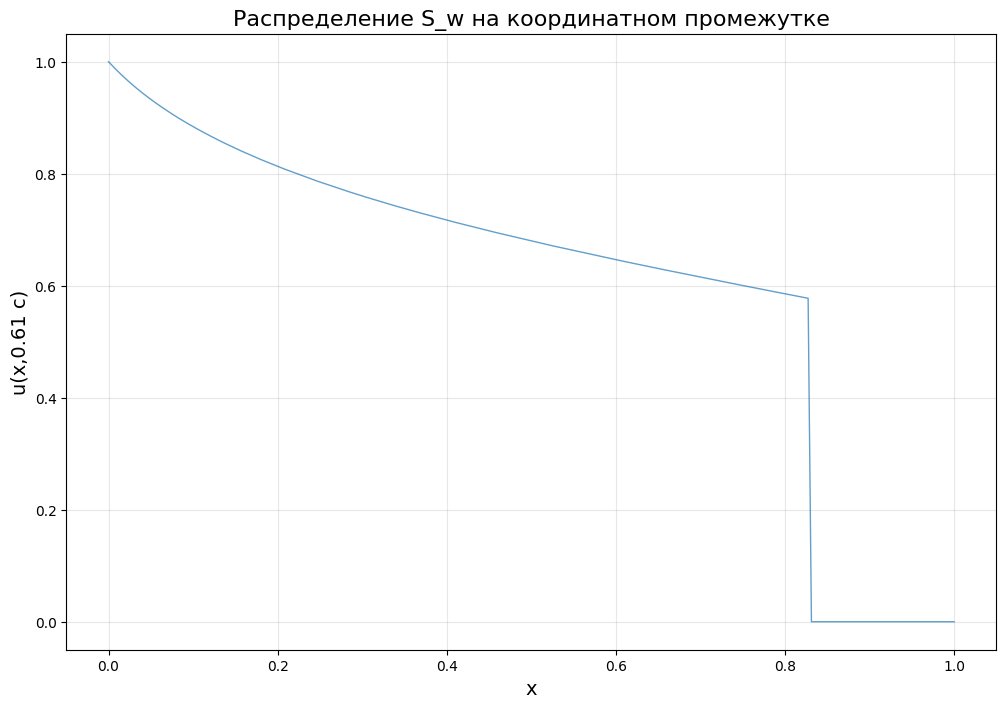

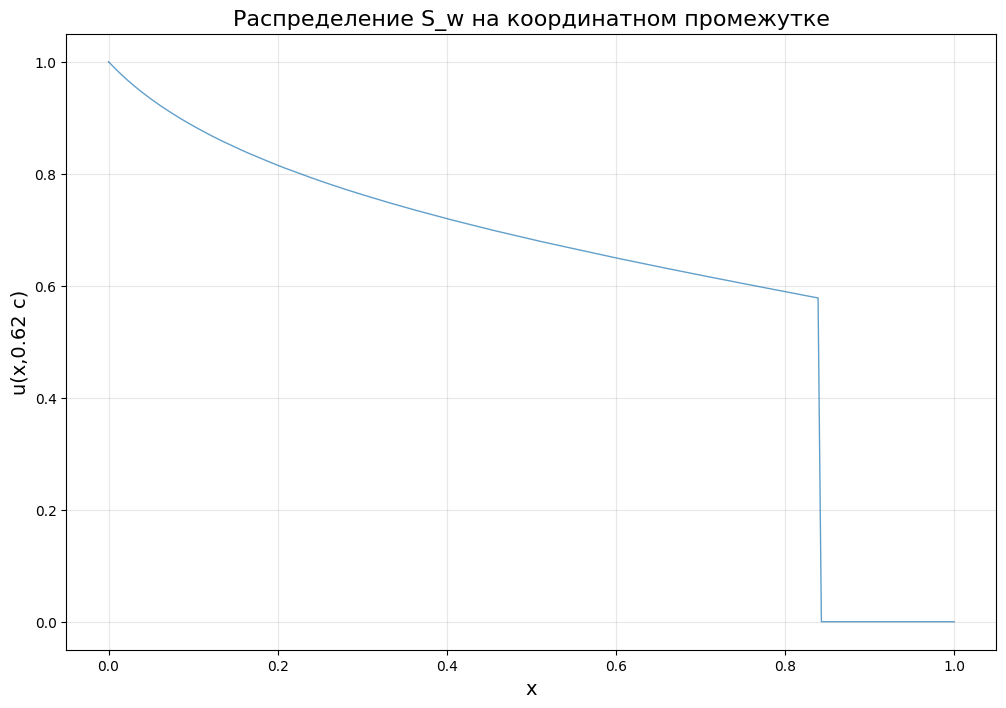

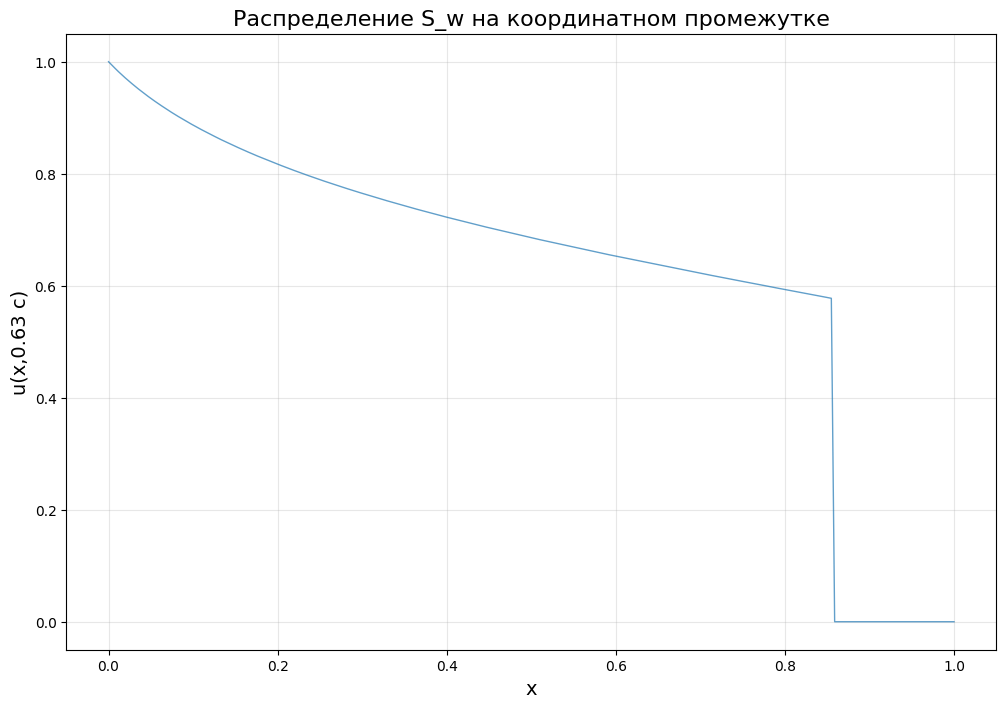

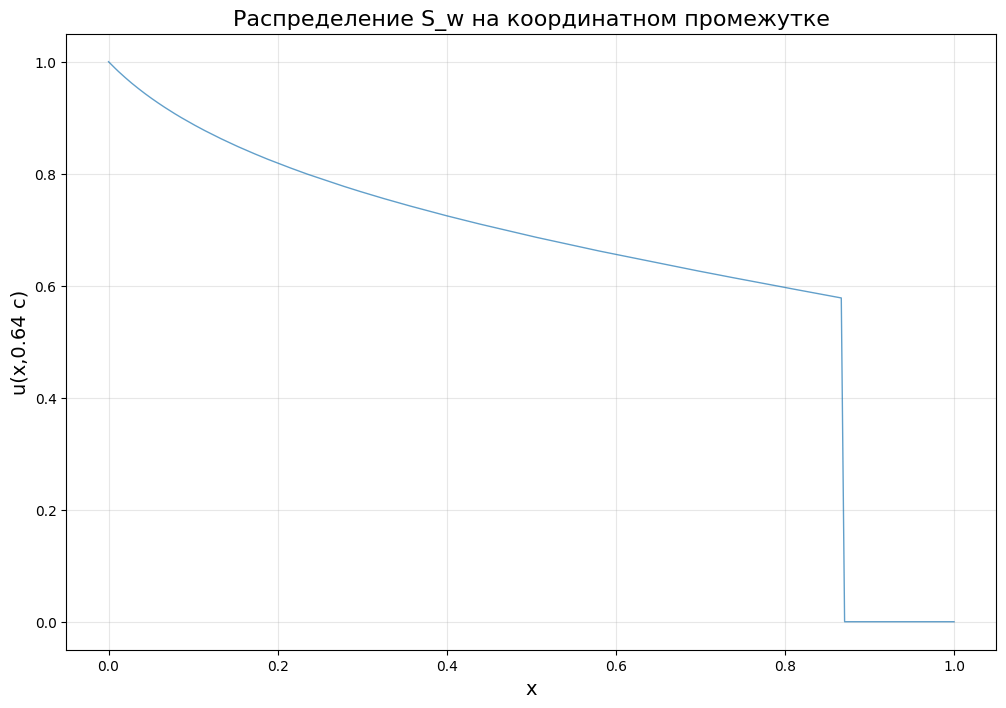

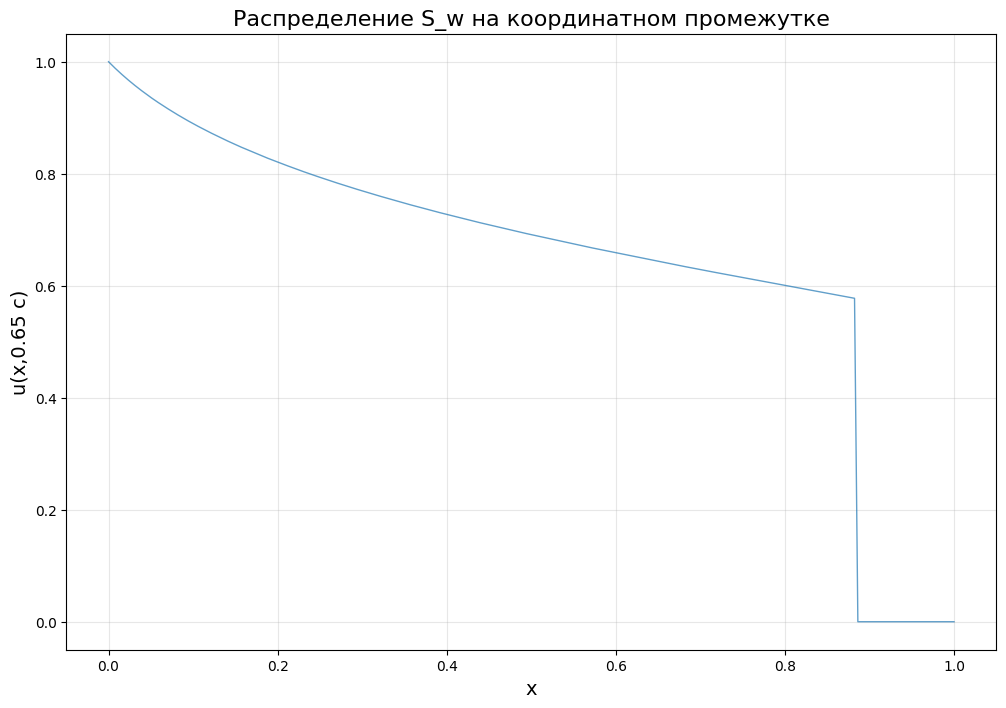

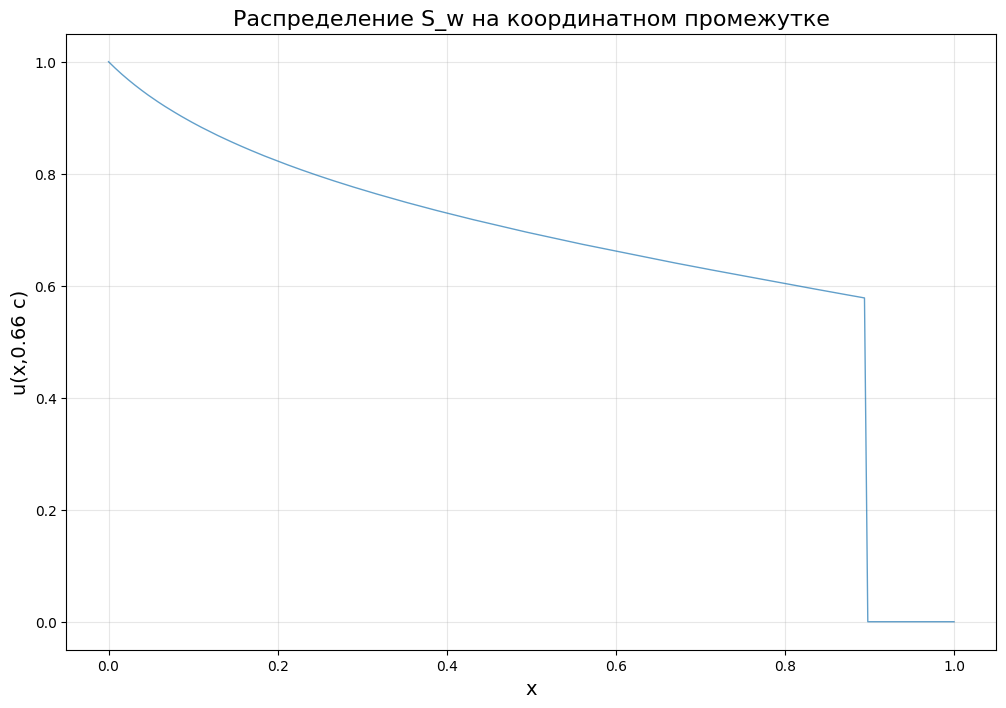

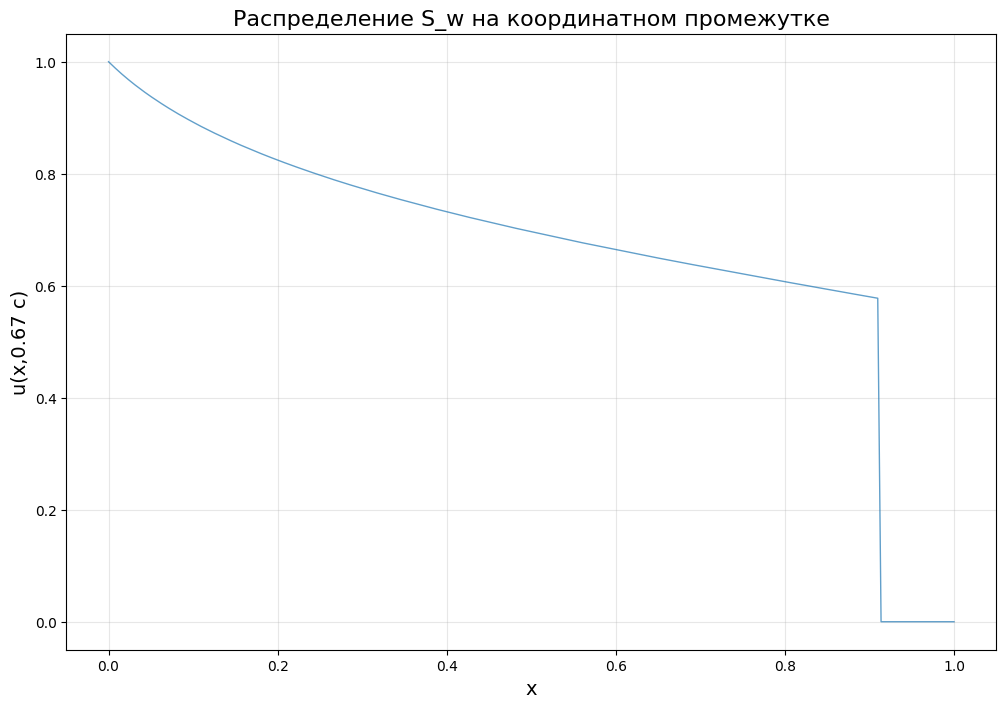

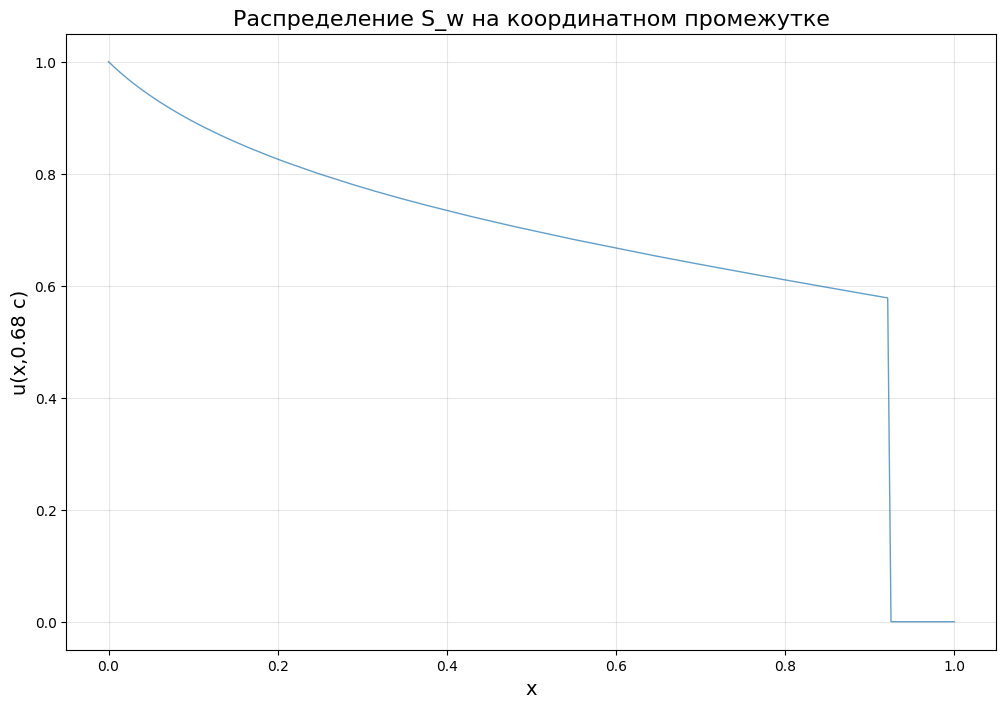

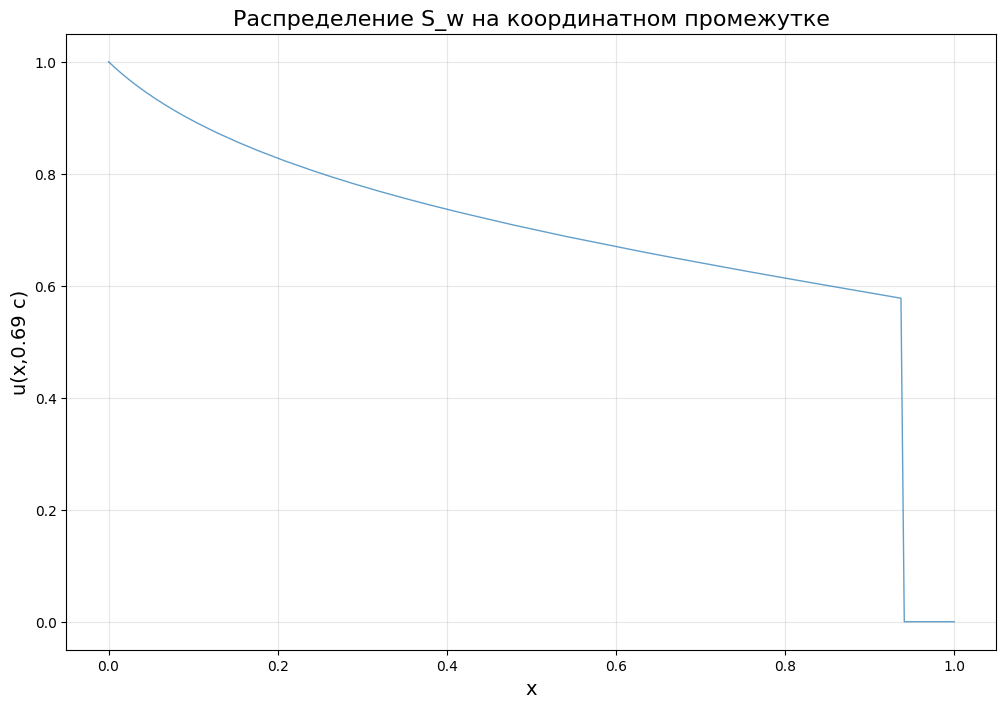

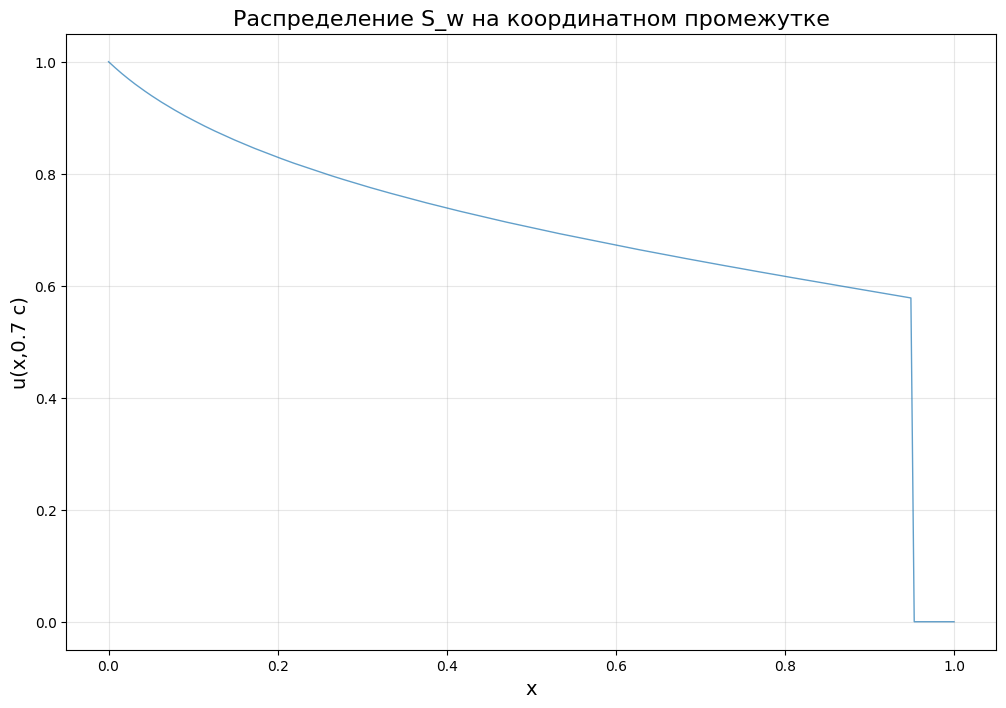

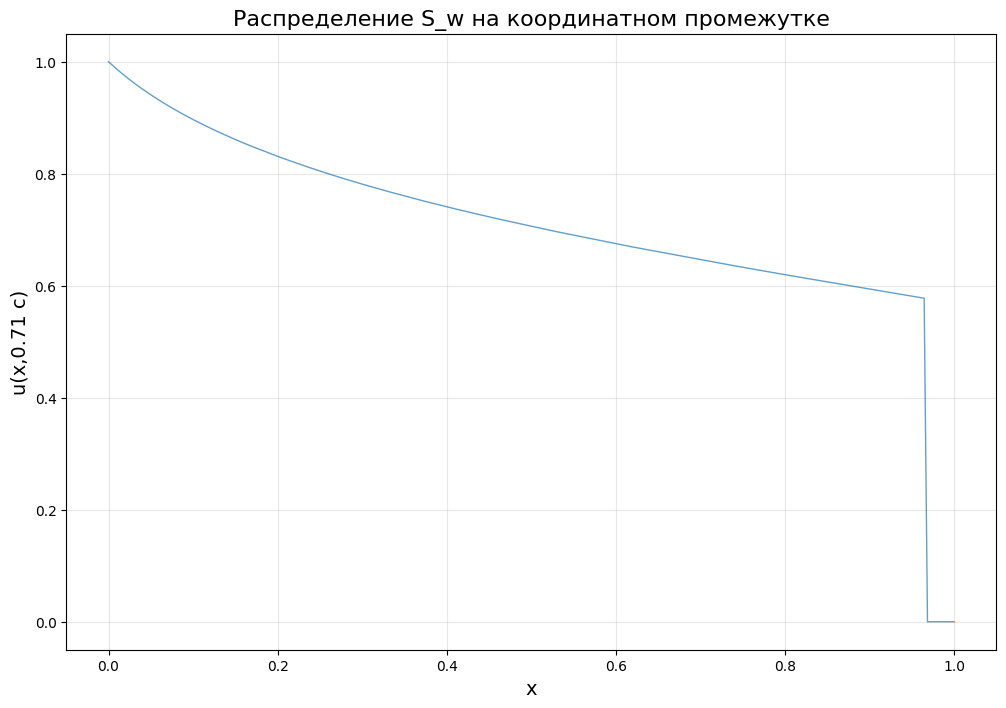

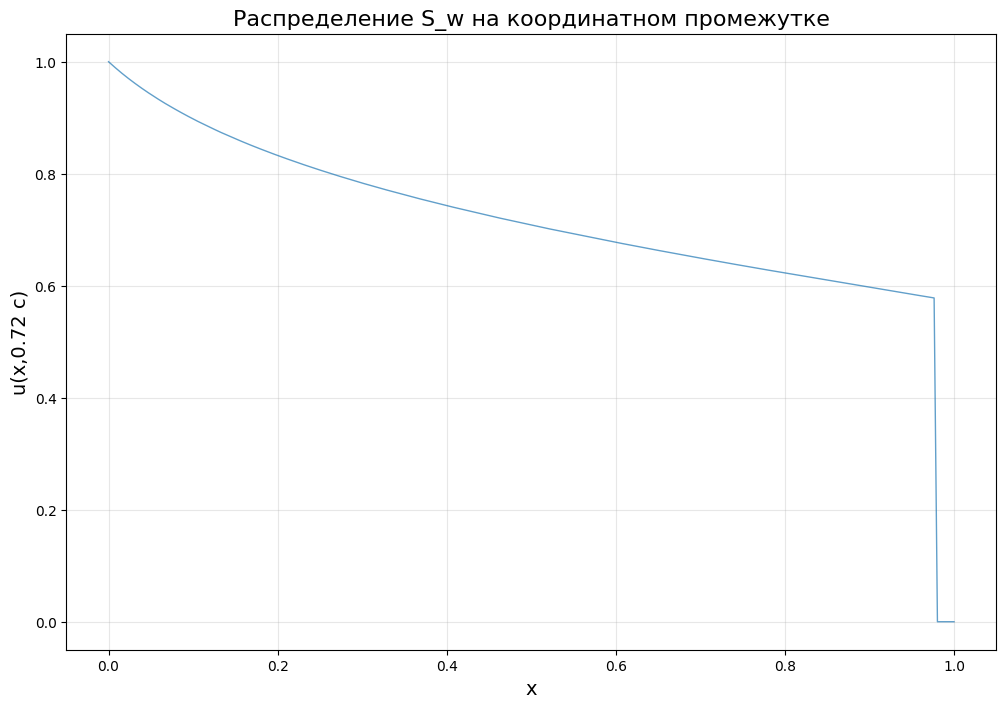

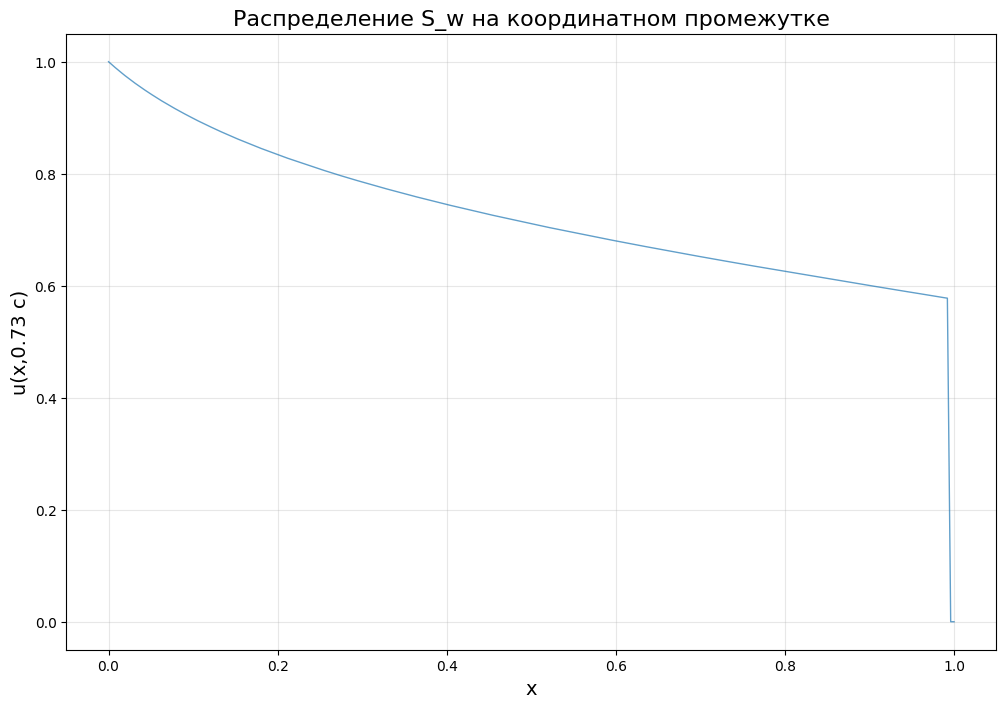

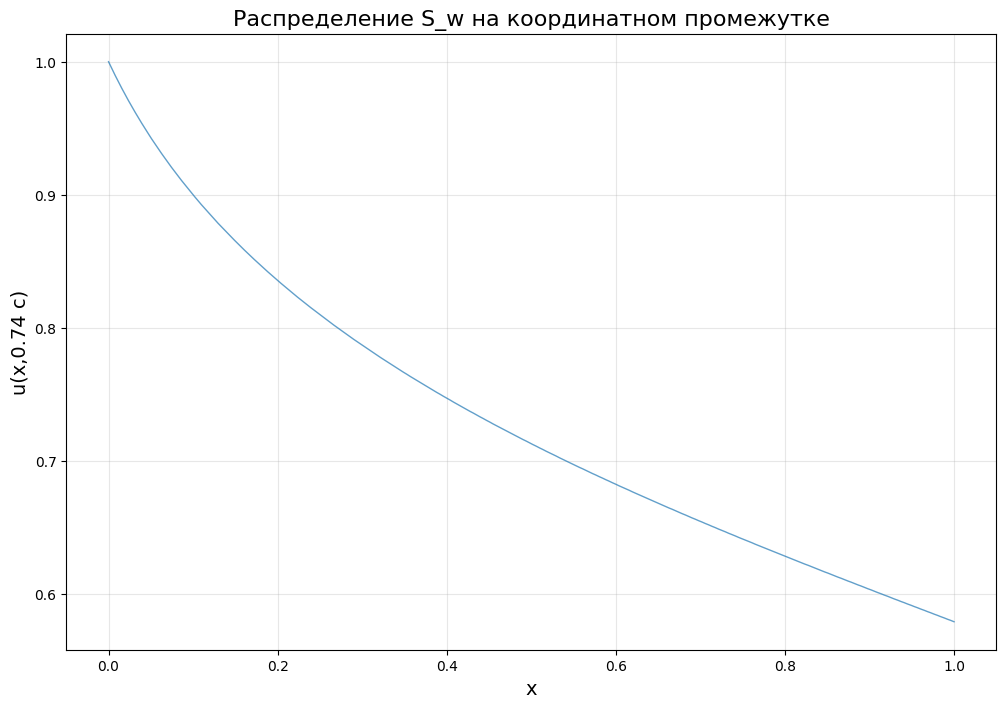

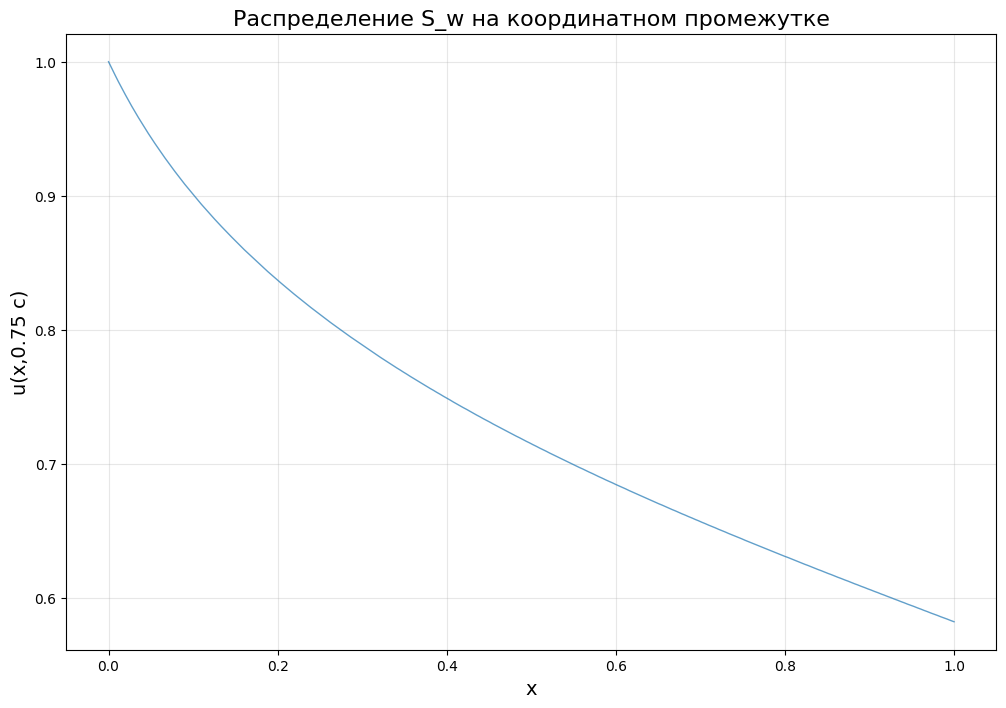

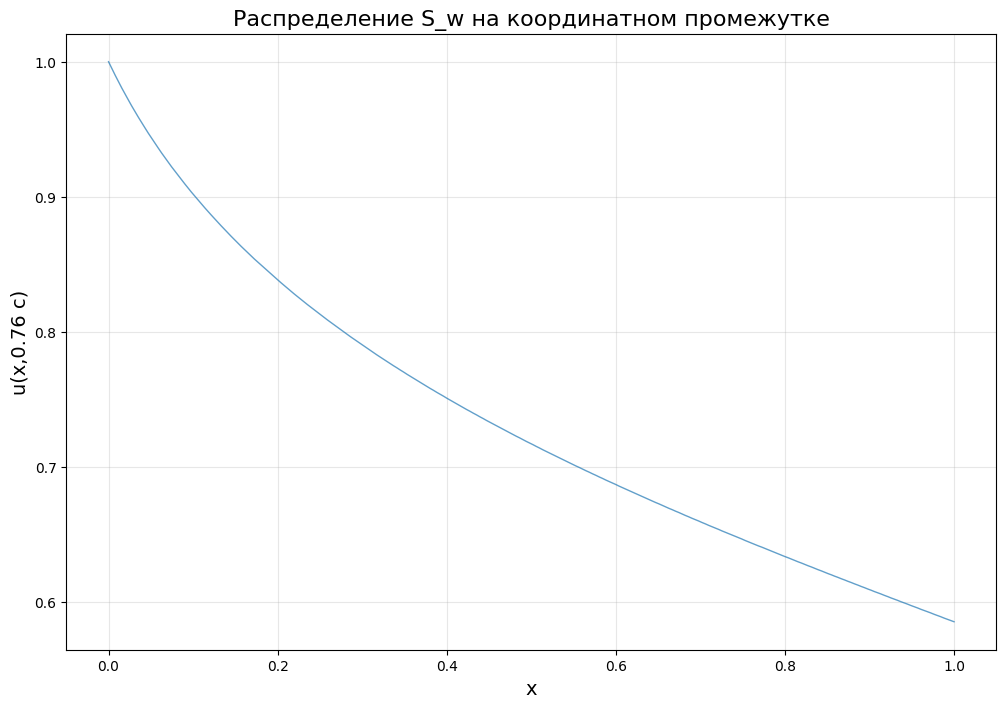

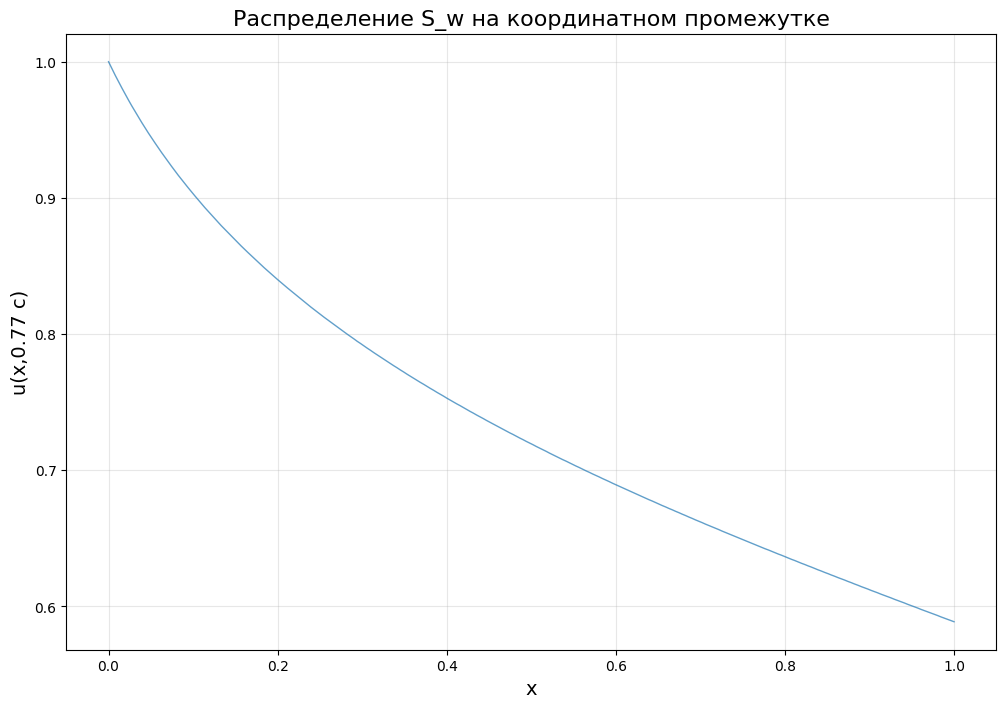

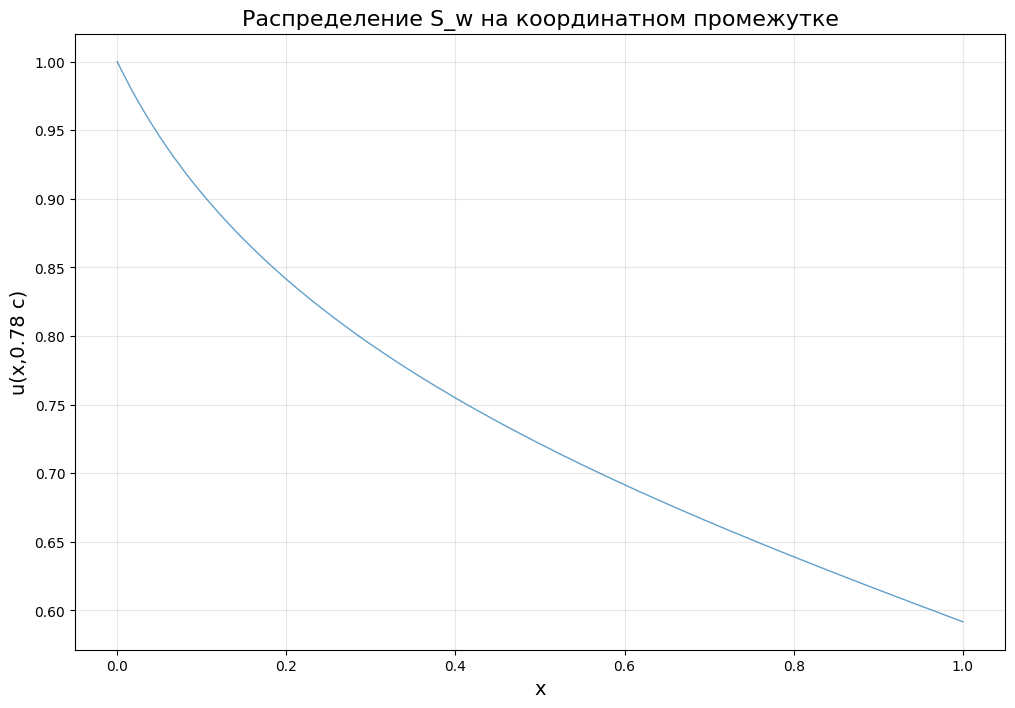

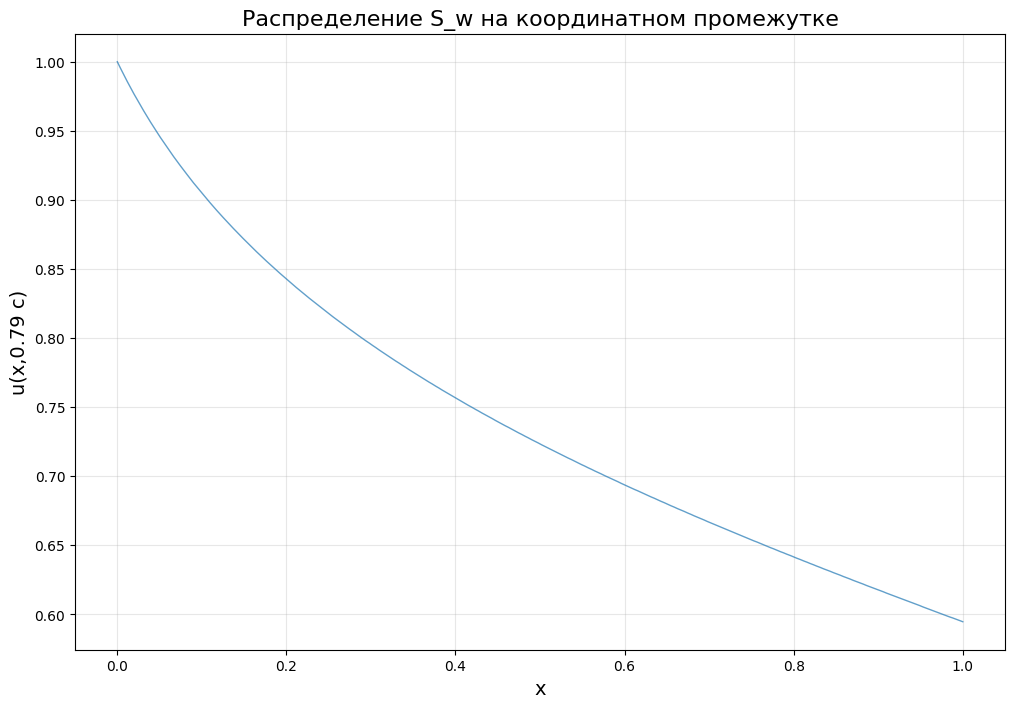

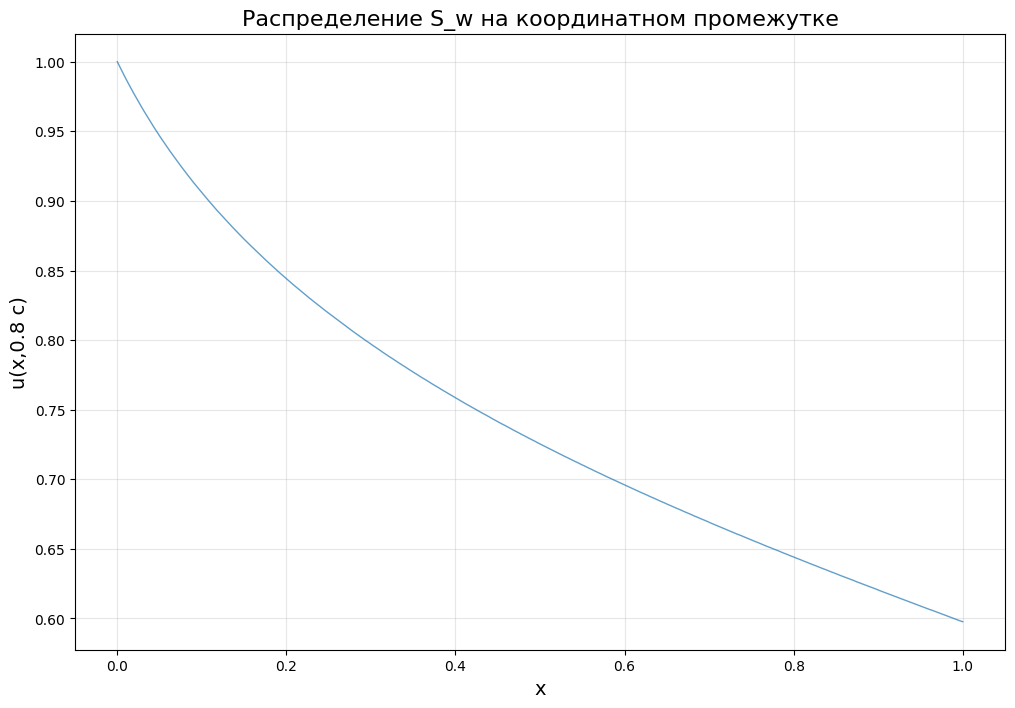

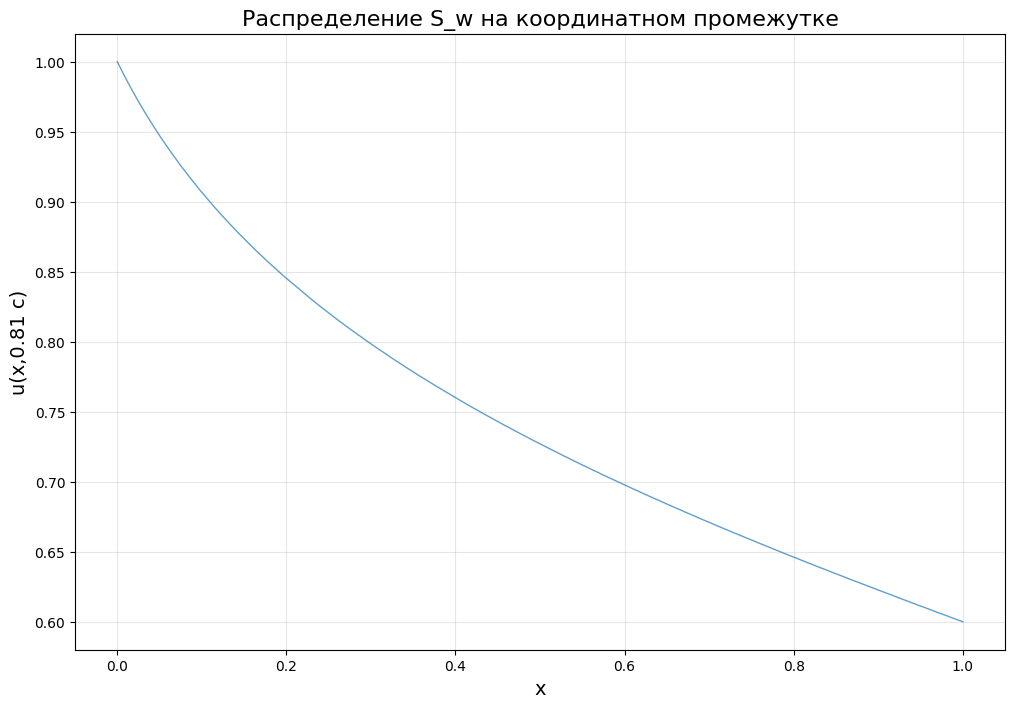

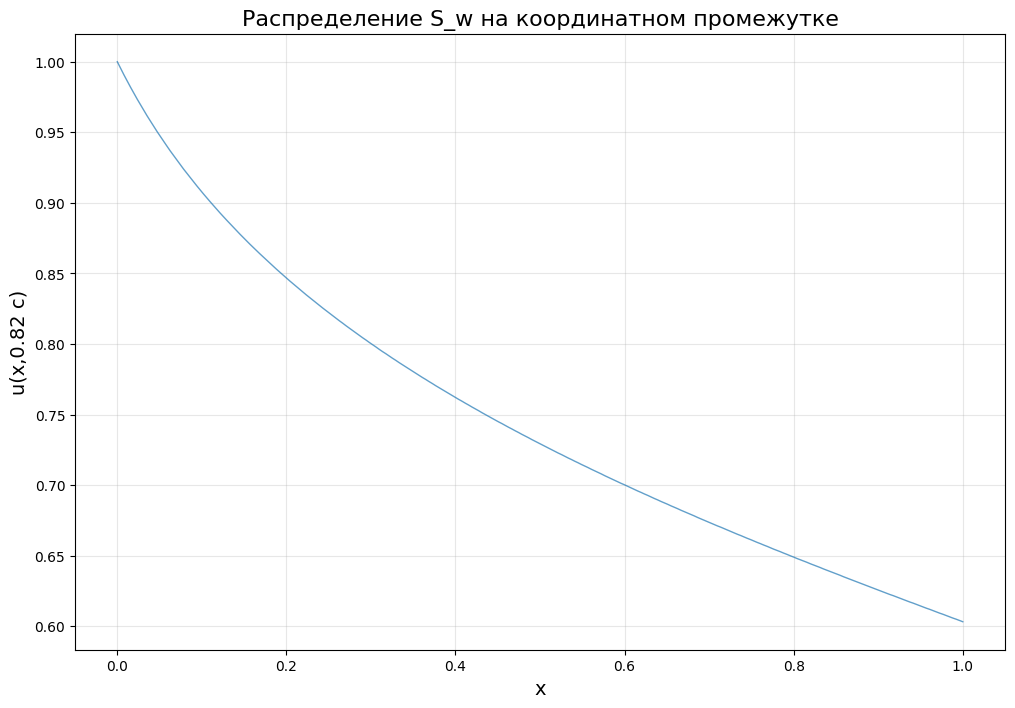

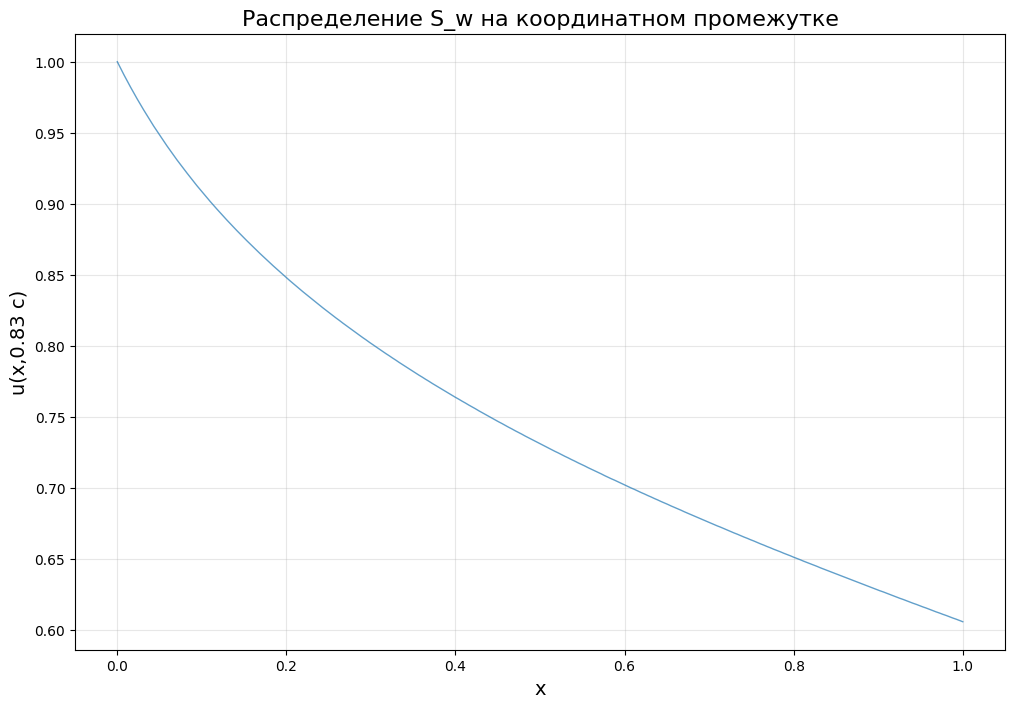

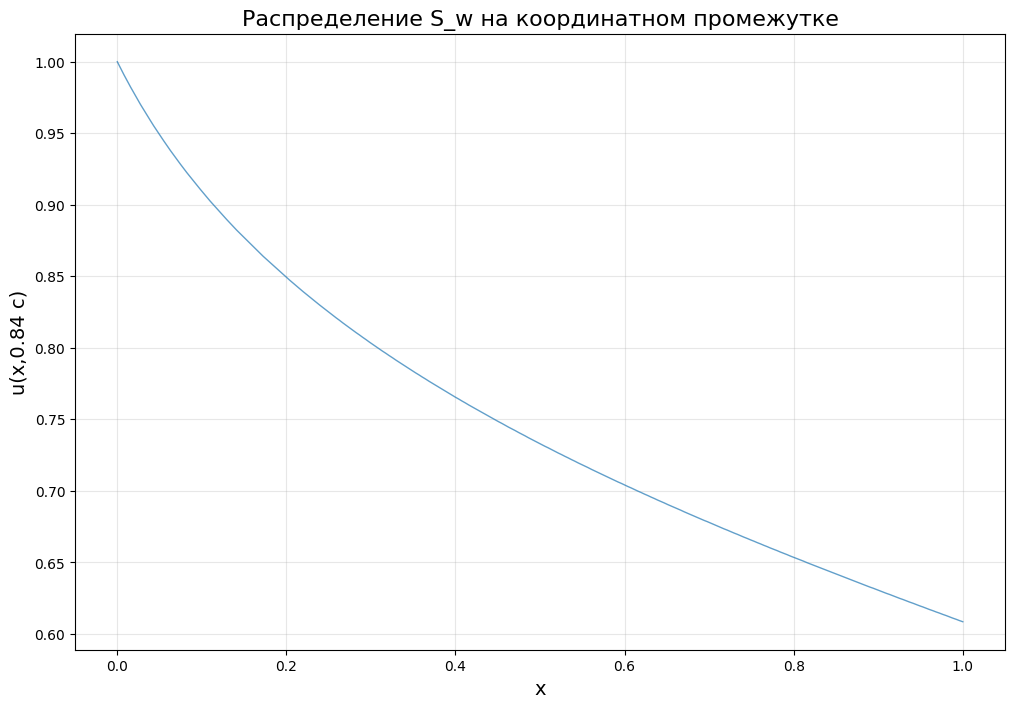

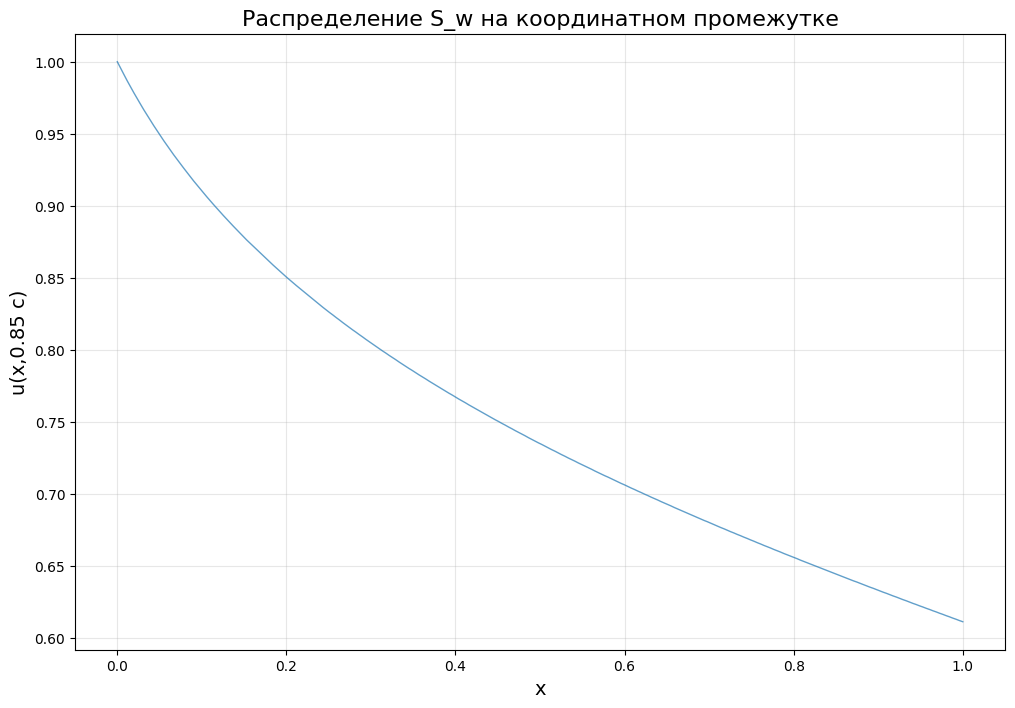

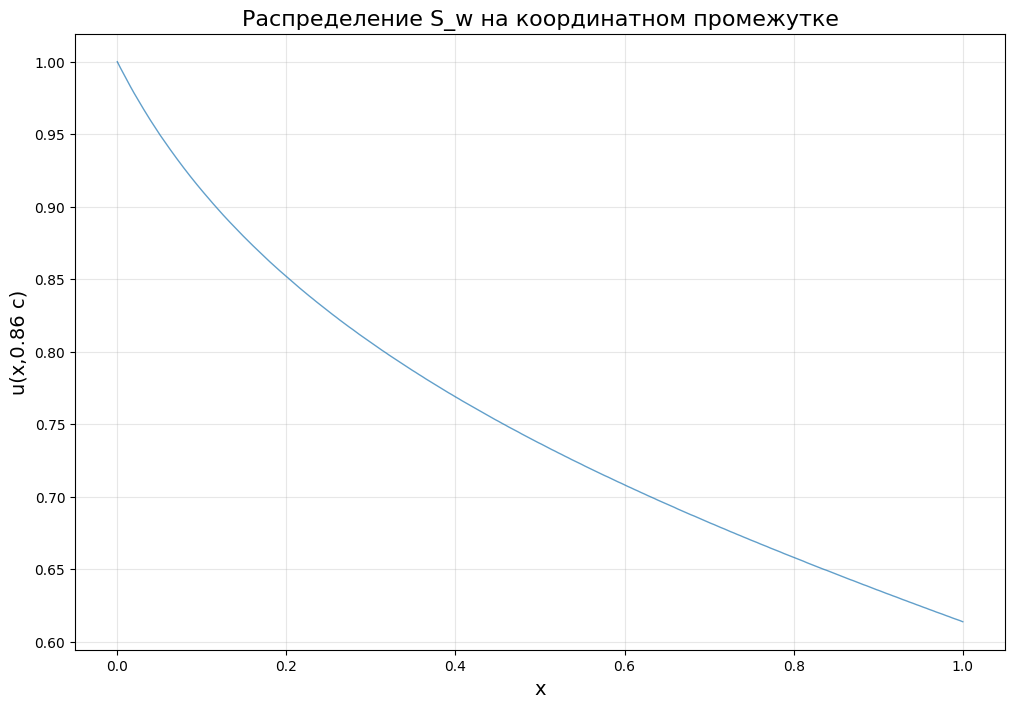

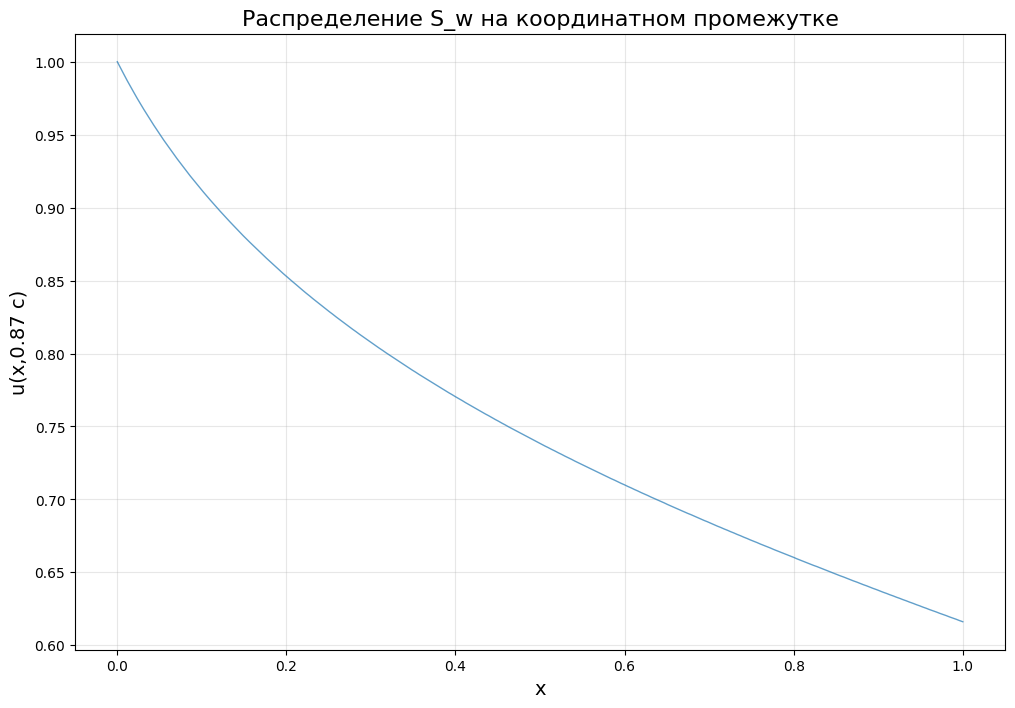

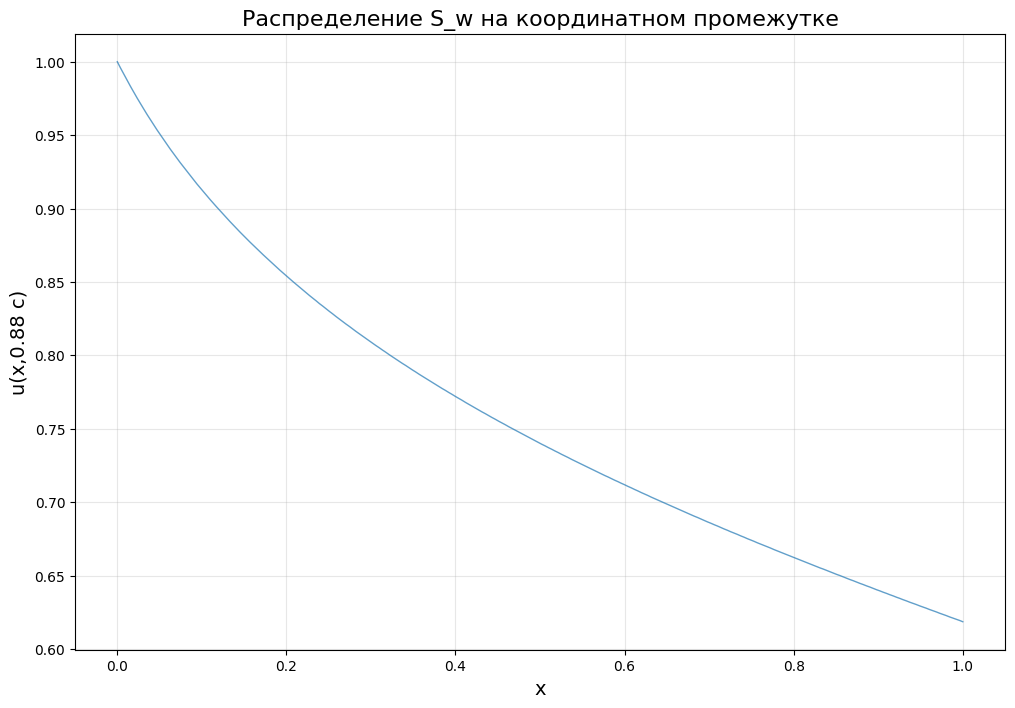

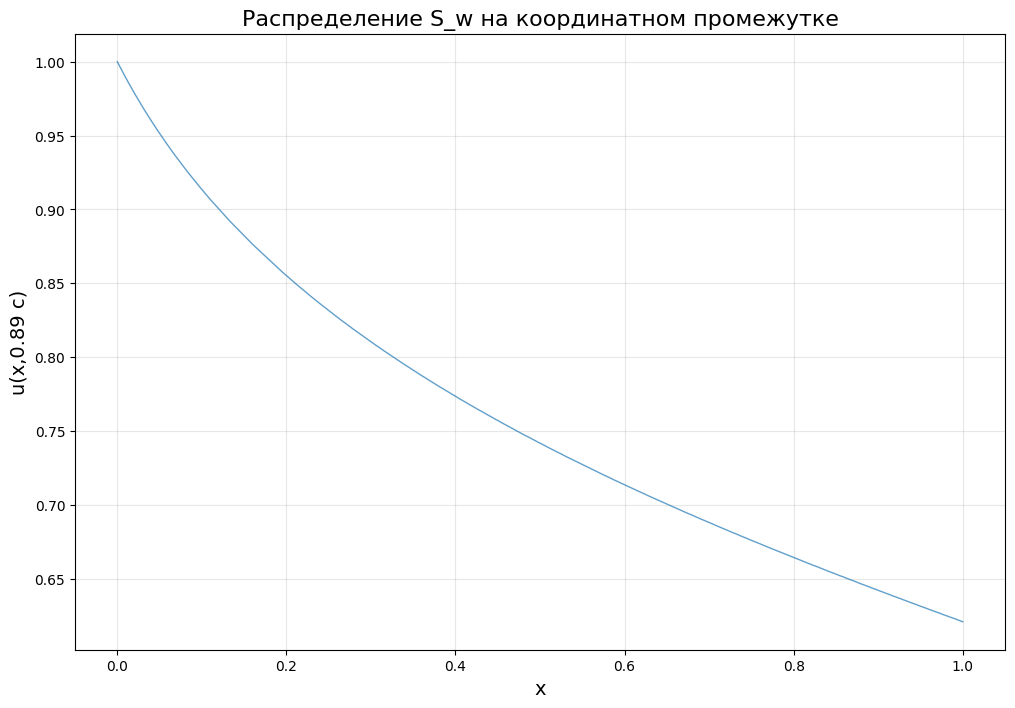

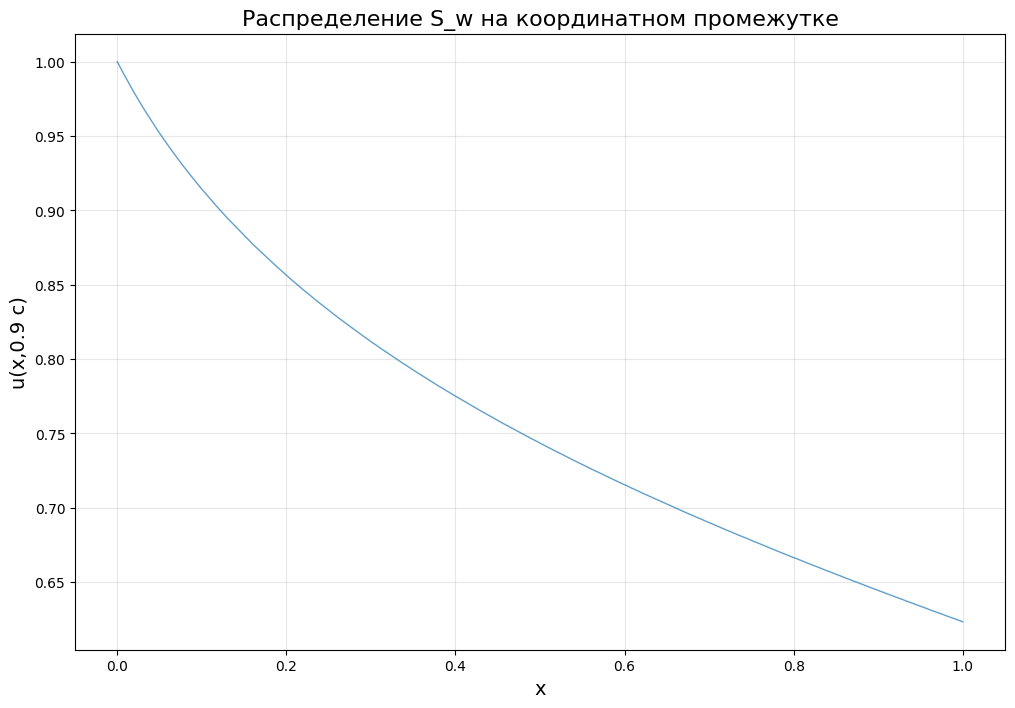

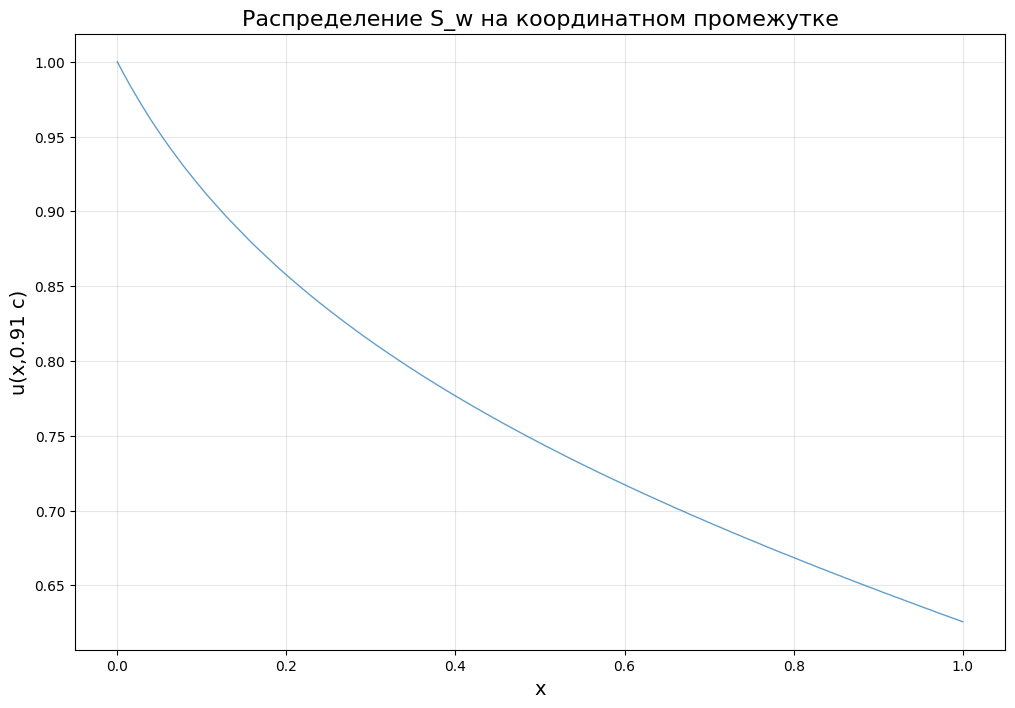

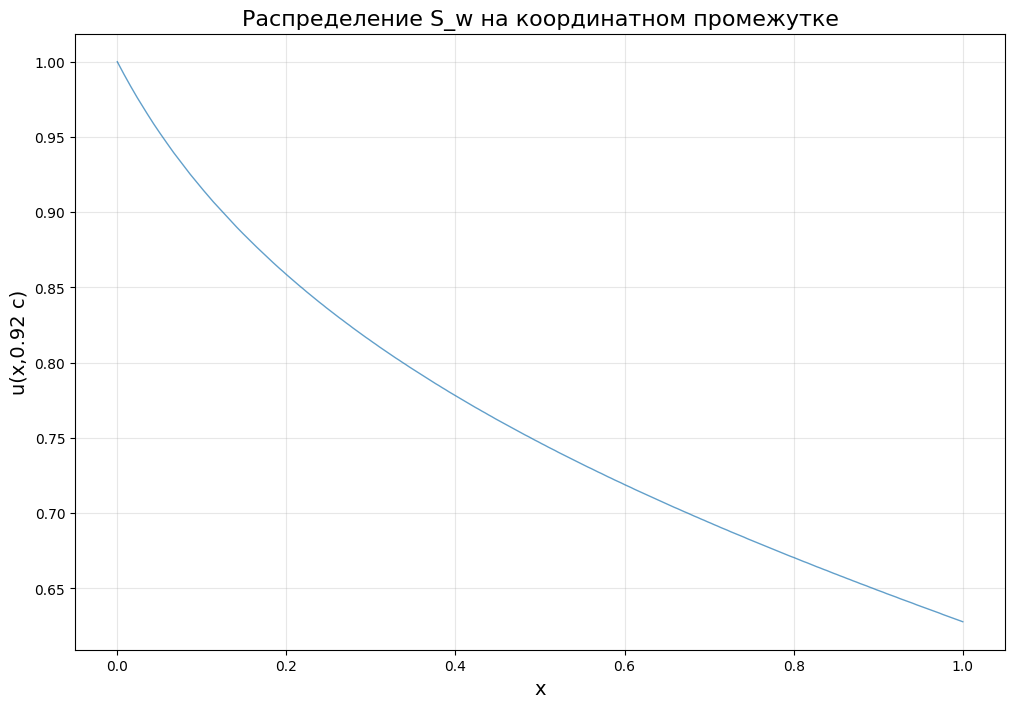

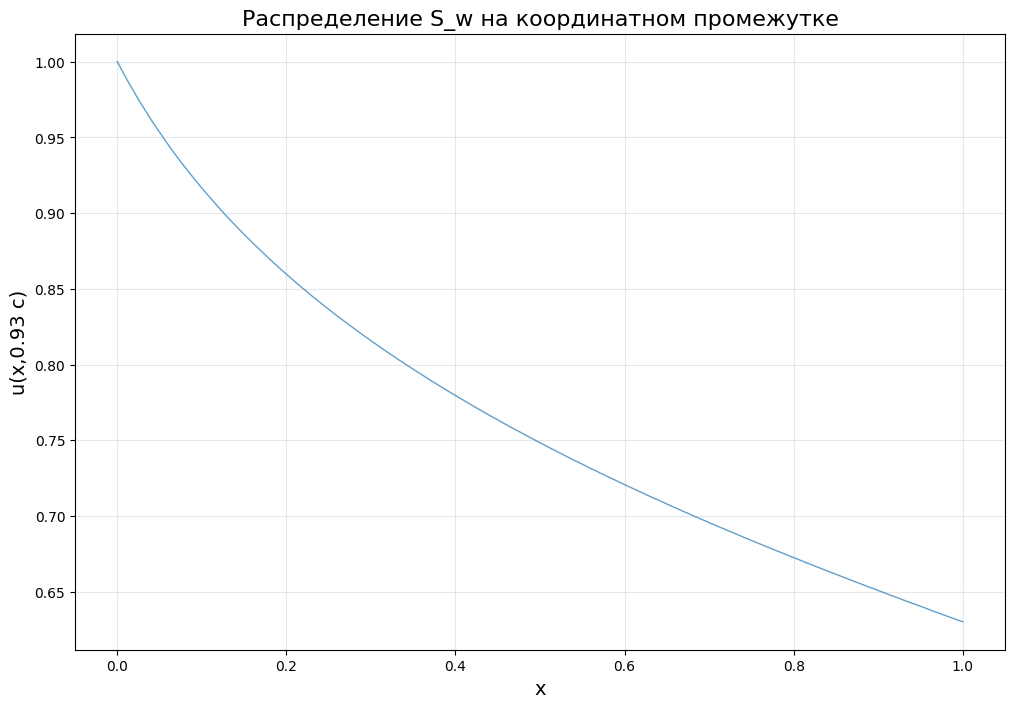

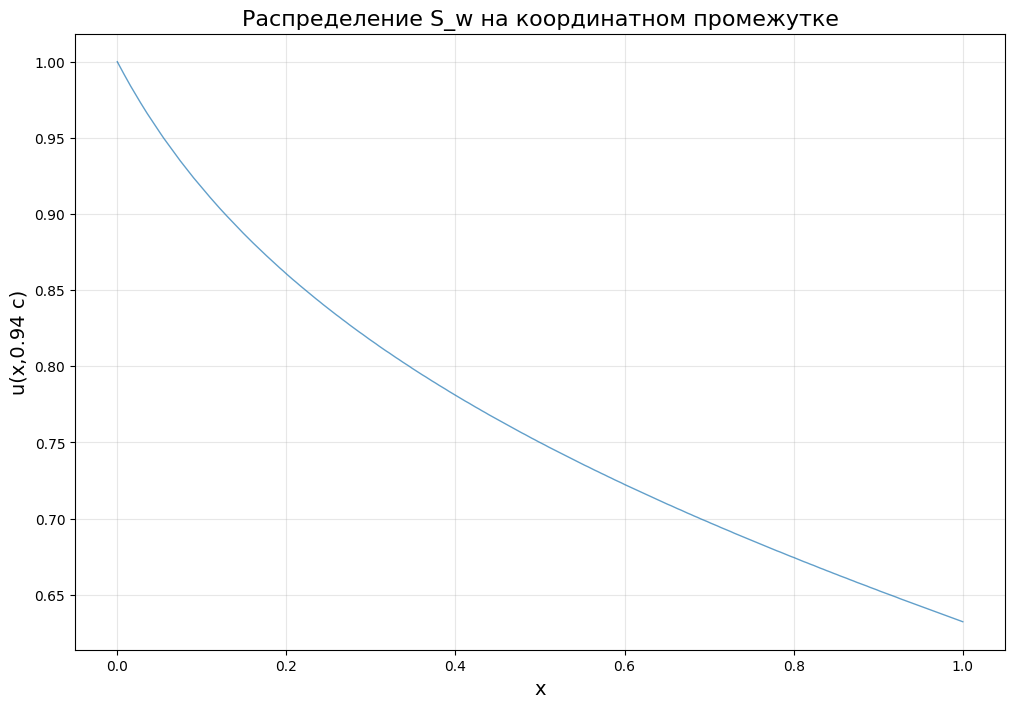

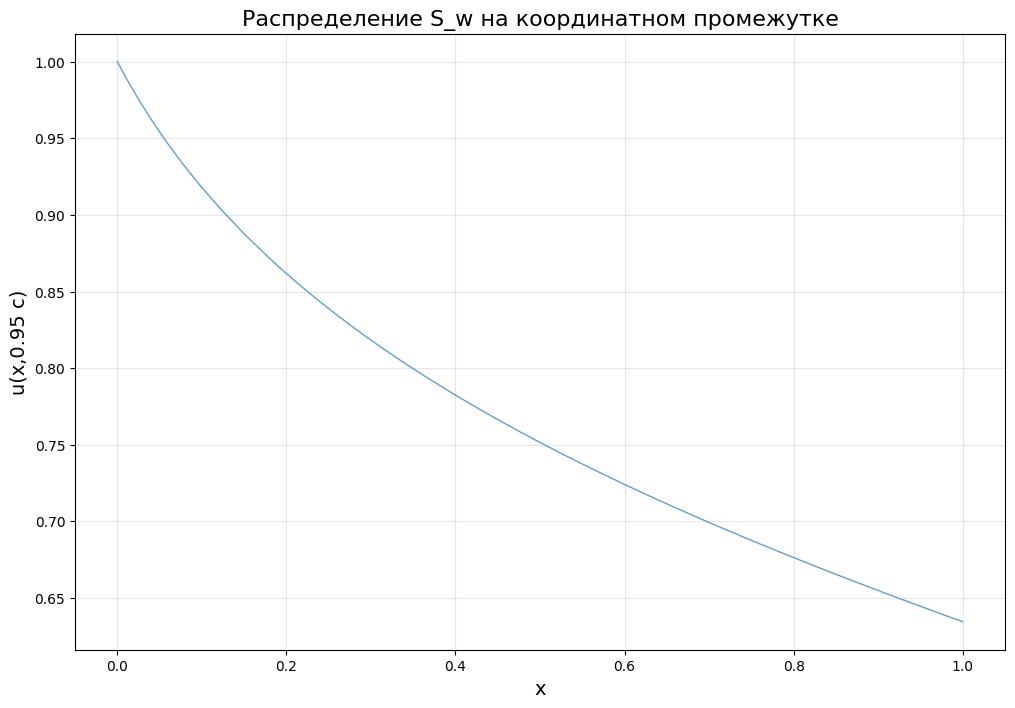

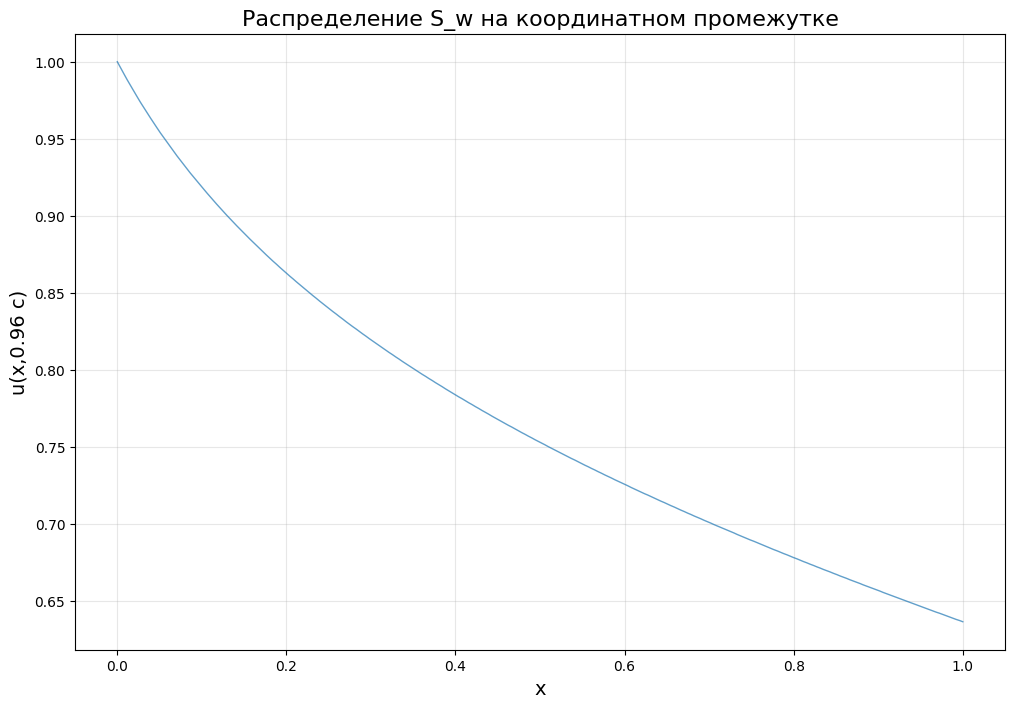

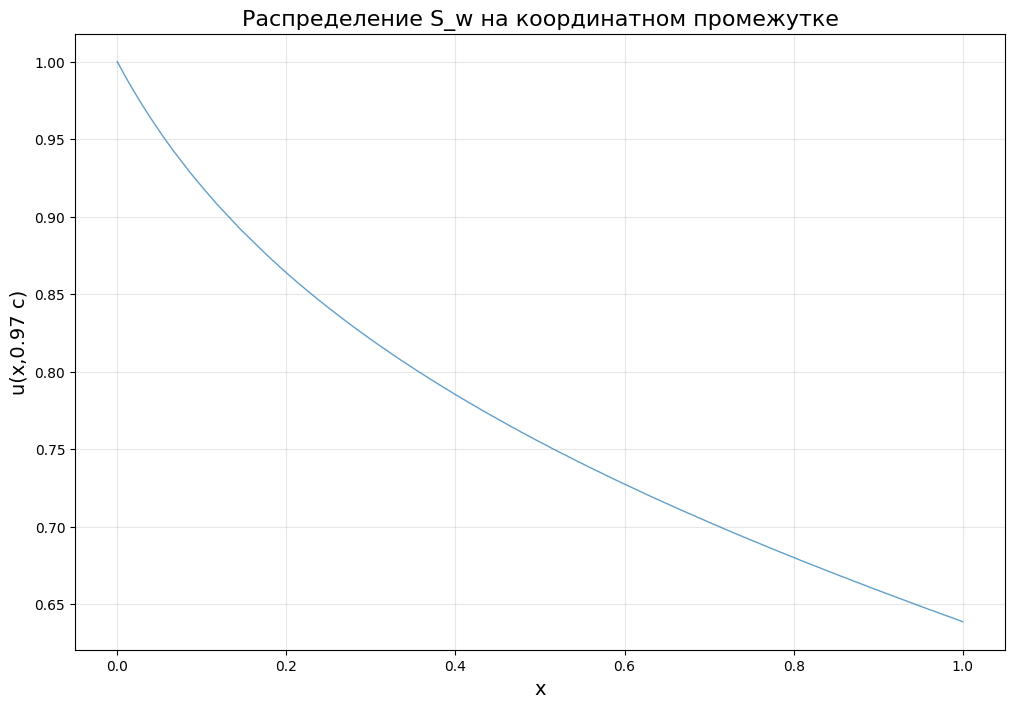

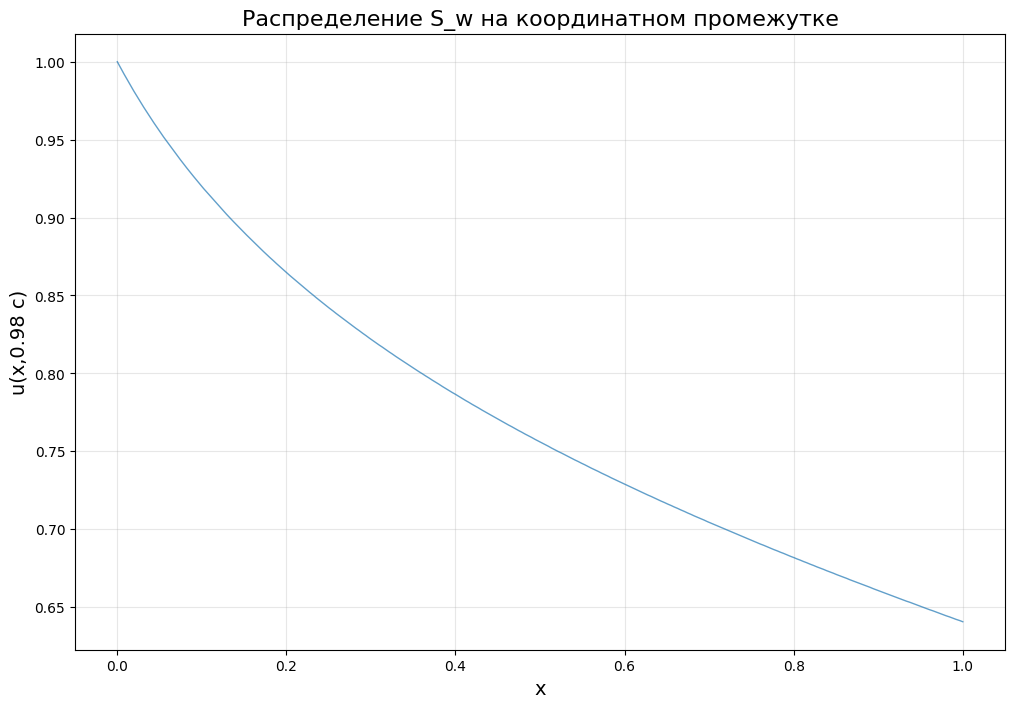

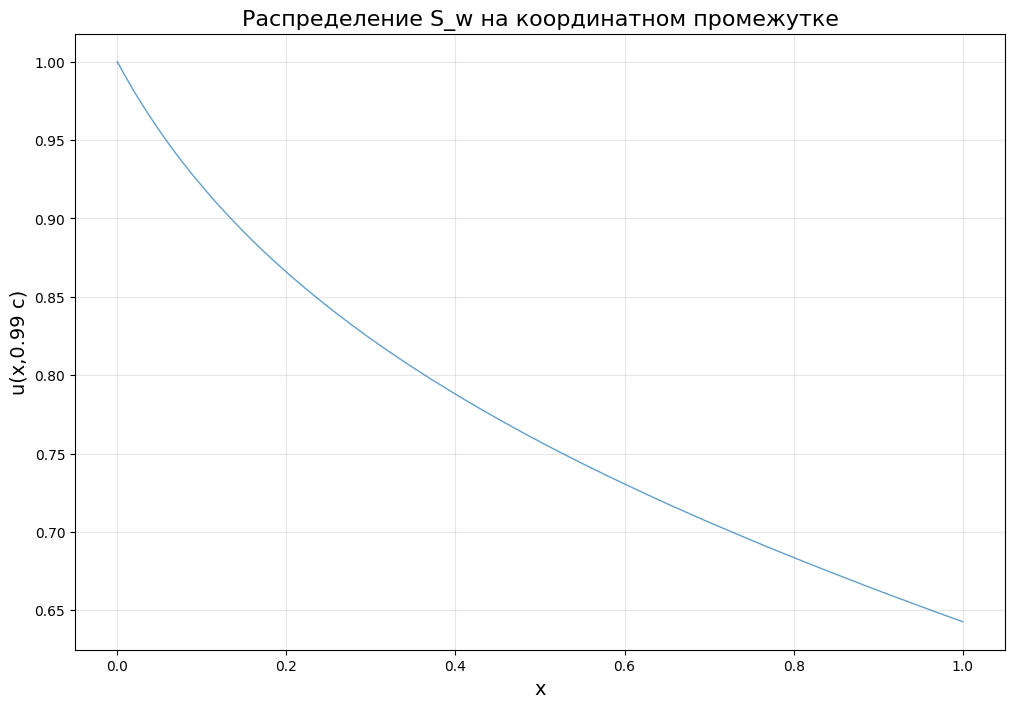

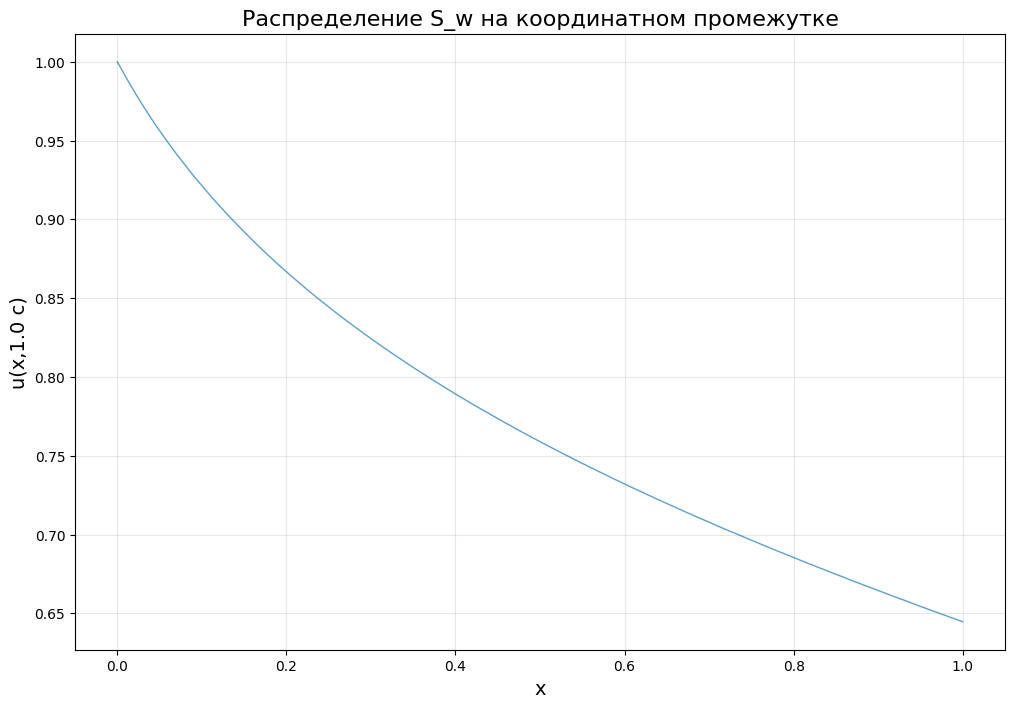

In [66]:
simple_plot_x_slices(x, t, value)

__Уравнение Баклея-Лаверетта в общем виде:__

_dS(x,t)/dt + N[S(x,t)] = 0, N - нелинейный дифф. оператор_

__Г.У.__: _S(x,0) = S_0(x)_

__Н.У.__: _S(x,t) = S_a(x,t) и S(x,t) = S_b(x,t)_



Т.е. для обучения модели нам нужно __три ошибки__: _значение_ __вычисленного уравнения__ _( поскольку оно равно нулю )_ + _ошибка по_ __Г.У.__ + _ошибка по_ __Н.У.__

In [8]:
import tensorflow as tf

In [ ]:
def create_dataset_from_grid(t, x, value, use_all_for_collocation=True):
    """
    Создает датасет для PINN из сеточных данных
    
    Parameters:
    t: array (N_t, 1) - временные координаты
    x: array (N_x, 1) - пространственные координаты  
    value: array (N_t, N_x) - значения решения
    use_all_for_collocation: bool - использовать ли все точки как коллокационные
    """
    
    T, X = np.meshgrid(t.flatten(), x.flatten())
    T_flat = T.flatten()[:,None]
    X_flat = X.flatten()[:,None]
    value_flat = value.T.flatten()[:,None]  # транспонируем чтобы совпало с meshgrid
    
    X_full = np.hstack([T_flat, X_flat])
    
    tmin, tmax = t.min(), t.max()
    xmin, xmax = x.min(), x.max()
    
    # Начальные условия
    mask_initial = np.isclose(T_flat, tmin).flatten()
    X_0 = tf.constant(X_full[mask_initial])
    u_0 = tf.constant(value_flat[mask_initial])
    
    # Граничные условия
    mask_boundary = (np.isclose(X_flat, xmin) | np.isclose(X_flat, xmax)).flatten()
    X_b = tf.constant(X_full[mask_boundary])
    u_b = tf.constant(value_flat[mask_boundary])
    
    # Коллокационные точки для диффура
    if use_all_for_collocation:
        X_r = tf.constant(X_full)
    else:
        mask_collocation = ~(mask_initial | mask_boundary)
        X_r = tf.constant(X_full[mask_collocation])
    
    return [X_0, X_b], [u_0, u_b], X_r

# Использование
X_data, u_data, X_r = create_dataset_from_grid(t, x, value)

In [13]:
X_data

[<tf.Tensor: shape=(256, 2), dtype=float64, numpy=
 array([[0.        , 0.        ],
        [0.        , 0.00392157],
        [0.        , 0.00784314],
        [0.        , 0.01176471],
        [0.        , 0.01568627],
        [0.        , 0.01960784],
        [0.        , 0.02352941],
        [0.        , 0.02745098],
        [0.        , 0.03137255],
        [0.        , 0.03529412],
        [0.        , 0.03921569],
        [0.        , 0.04313725],
        [0.        , 0.04705882],
        [0.        , 0.05098039],
        [0.        , 0.05490196],
        [0.        , 0.05882353],
        [0.        , 0.0627451 ],
        [0.        , 0.06666667],
        [0.        , 0.07058824],
        [0.        , 0.0745098 ],
        [0.        , 0.07843137],
        [0.        , 0.08235294],
        [0.        , 0.08627451],
        [0.        , 0.09019608],
        [0.        , 0.09411765],
        [0.        , 0.09803922],
        [0.        , 0.10196078],
        [0.        , 0.10588235